In [1]:
# -*- coding: utf-8 -*-
# Packages -----------------
import os
import sys
import shutil
import warnings
import datetime

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pedophysics import predict, Soil
import FDEM
from FDEM import Initialize

from scipy import constants
from utils.spatial_utils import utm_to_epsg, get_coincident
from utils.profile_utils import merge_layers, plot_profile, check_uniformity_and_interpolate

from PyPDF2 import PdfMerger

# Electromagnetic induction data inversion package
from plots import *
from PM import *

sys.path.insert(0,'../src/') # this add the emagpy/src directory to the PATH
from emagpy import Problem
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%load_ext autoreload

In [2]:
# User input
config = {}

only_samples = False

s_site = 'P'; # P = Proefhoeve; M = Middelkerke
# Define input datatype and source folder
datafolder = 'data' # data folder
em_intype = 'rec'   # 'rec' = rECa transect; 'lin' = LIN ECa transect; 
                    # 'survey' = rEC full survey

# Sensor settings
config['instrument_code'] = 'Dualem-21HS' # instrument code
config['instrument_height'] = 0.165     # instrument height
config['instrument_orientation'] = 'HCP'    # instrument orientation

# Remove coils for inversion?
config['remove_coil'] = True    # set to True if you want to remove coils in the inversion process
config['coil_n'] = [0,1]    # indexes of coils to remove (cf. emagpy indexing)
                            # for Proefhoeve, coils 0 (HCP05) and 1 (PRP06) are best
                            # removed, for Middelkerke coils 4 (HCP4.0) and 5 (PRP4.1)

# Inversion parameters
config['fs_emp'] = 'FSeq' #'CS', 'FSlin' or 'FSeq'
config['opt_method'] = 'Gauss-Newton'  # mMinimize = ['L-BFGS-B','TNC','CG','Nelder-Mead'] --> https://docs.scipy.org/doc/scipy/reference/optimize.html 
                                # mMCMC = ['ROPE','DREAM', 'MCMC'] # ??? 'SCEUA' ??? --> https://spotpy.readthedocs.io/en/latest/ 
                                # mOther = ['ANN','Gauss-Newton','GPS'] (ANN requires tensorflow)
config['constrain']=True
config['regularization'] = 'l2'
config['alpha'] = 0.5

# Reference profile for starting model (conductivity values)
config['start_avg'] = True     # take average of input resistivity profiles per layer as starting model
                                # if false, reference profile is taken as starting model
config['reference_profile'] = 11 # ID of ERT (conductivity) profile to be used 
                                 #  to generate starting model
                                 # For proefhoeve nr 15 is used, for middelkerke 65

# Define the interfaces depths between layers for starting model and inversion
#           (number of layers = len(config['interface'])+1)
config['n_int'] = True # if True custom interfaces are defined (via config['interface']), 
                        # otherwise reference profile interfaces are used
config['interface'] = [0.3, 
                       0.6, 
                       1.0,
                       2.0
                        ] # depths to custom model interfaces
# Inversion constraining
# if constrained inversion is used, you can set custom EC bounds (and other params)
'''
    config['bounds'] is the 'bnds' used in emagpy constraining
    if you fix 2 interface and fit 3 layer EC:
    [(layer1_ec_min, layer1_ec_max), 
    (layer2_ec_min, layer2_ec_max), 
    (layer3_ec_min, layer3_ec_max)]

    If you fit 2 interfaces and fit 3 layer EC:
    [(int1_min, int1_max), 
    (int2_min, int2_max), 
    (layer1_ec_min, layer1_ec_max), 
    (layer2_ec_min, layer2_ec_max), 
    (layer3_ec_min, layer3_ec_max)]

    autobounds MDK:[(22.877321099166068, 83.29767890083818), 
    (50.6150000000018, 381.79940055200086), 
    (75.5445000000012, 819.2347232074701), 
    (124.346000000001, 1108.1655185859772), 
    (188.4700000000009, 1025.8167426267287)]   
'''

config['custom_bounds'] = True
config['bounds'] = [(10, 55), (20, 120), (50, 335), (50, 250), (10, 50)]

# !!! ---

# [  6.  43.]
#  [ 27. 183.]
#  [ 36. 307.]
#  [ 63. 335.]
#  [ 47. 337.]
#  [ 82. 224.]
#  [ 53. 103.]
#  [ 39.  73.]

if config['n_int'] == False and config['custom_bounds']:
    print('Check if bounds and number of interfaces match')

# Geographic operations (if needed)
c_transform = False
c_utmzone = '31N'
c_target_cs = 'EPSG:31370'

# remove profiles at transect edges
config['n_omit'] =  10 # number of profiles to exclude from the start
                       # and end of the ERT transect (none = 0) for the inversion
                       # a total of 60 profiles is available, for middelkerke
                       # 120 profiles are available  

# ---------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------- #

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if config['instrument_code'] == 'Dualem-21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'
inv_folder = os.path.join(datafolder, 'inverted')
os.makedirs(inv_folder, exist_ok=True) 
cal_folder = os.path.join(datafolder, 'calibrated')
ert_file = os.path.join(datafolder, f'{profile_prefix}-profiles.csv')
em_rec = os.path.join(cal_folder, f'{emfile_prefix}_transect_calibrated_rECa.csv')
em_lin = os.path.join(cal_folder,f'{emfile_prefix}_transect_calibrated.csv')
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_calibrated_rECa.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samps.csv')

if em_intype == 'rec':
    infile = em_rec
elif em_intype == 'survey':
    infile = em_survey
else:
    infile = em_lin

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                    instrument_orientation=config['instrument_orientation']
                                    )

# Column names for emapgy input
emp_21HS = [f"HCP0.5f9000{config['instrument_height']}", 'PRP0.6f9000h0.165', 'HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165',
            'HCP0.5f9000h0.165_inph', 'PRP0.6f9000h0.165_inph', 'HCP1.0f9000h0.165_inph',
            'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph'
            ]

emp_421S = ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165', 
            'HCP1.0f9000h0.165_inph', 'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph',
            'HCP4.0f9000h0.165_inph', 'PRP4.1f9000h0.165_inph',
            ]

if config['opt_method'] == 'Gauss-Newton':
    config['regularization'] = 'l2'

# Datetime for filename
now = (datetime.datetime.now())
now = now.strftime("%y%m%d_%H%M")

# 1.0 Data import and structuring into dataframe
ert_p = pd.read_csv(ert_file, sep=',', header=0)
em_rec = pd.read_csv(em_rec, sep=',', header=0)
em_lin = pd.read_csv(em_lin, sep=',', header=0)
em_survey = pd.read_csv(em_survey, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)


if c_transform:
    # Create a new filename with the target EPSG code
    em_rec = utm_to_epsg(em_rec, c_utmzone, target_epsg=c_target_cs)
    em_lin = utm_to_epsg(em_lin, c_utmzone, target_epsg=c_target_cs)
    em_survey = utm_to_epsg(em_survey, c_utmzone, target_epsg=c_target_cs)

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                        instrument_orientation=config['instrument_orientation']
                                        )

print('samples.head()', samples.head())
print('em_survey.head()', em_survey.head())

em_samples = get_coincident(em_survey,samples)

# ---------------------------------------------------------------------------- #
# Get ERT profiles
# ---------------- #
# Group the data by profile ID for efficient access to each profile
profiles = ert_p.groupby('ID')

# Exclude the first and last n_omit profiles
unique_ids = ert_p['ID'].unique()

if config['n_omit'] == 0:
    ert_final = ert_p.copy()
else:
    if config['n_omit']*2 >= len(unique_ids):
        warnings.warn('!!! You removed all profiles !!! Change value for config[n_omit]')
        raise KeyboardInterrupt
    else:
        selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
        ert_p = ert_p.loc[ert_p['ID'].isin(selected_ids)]
        ert_final = ert_p.copy()

dataset_name = 'Resistivity(ohm.m)'  # The variable of interest

# convert resistivity to conductivity and modify column names

ert_final[dataset_name] = (1/ert_final[dataset_name])
dc_corr = ert_final.copy()
dc_corr[dataset_name] = predict.BulkEC(Soil(
                                                frequency_ec = 9000,
                                                bulk_ec_dc = dc_corr[dataset_name].values
                                                ))

ert_final.loc[:, dataset_name] = ert_final[dataset_name]*1000
dc_corr.loc[:,dataset_name] = dc_corr[dataset_name]*1000
ert_final = ert_final.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})
dc_corr = dc_corr.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})

# ------------------------------------------------------------------------------

# Columns containing the resistivity data
data_column = ['EC(mS/m)']
# Assuming ert_final is your DataFrame with profile data
all_profiles_df, uniform_intervals = check_uniformity_and_interpolate(
    dc_corr, 'ID', 'z', *data_column
)

dataset_name = 'EC(mS/m)'  # The variable of interest
# #Plotting combined profiles
# plot_combined_profiles(ert_final, all_profiles_df, 
#                        data_column, compare_name = data_column)


samples.head()       name  code           x           y  ec_i-10cm  ec_i-50cm
0  p_clhs1     1  107719.853  183326.516     36.495    176.853
1  p_clhs2     2  107755.838  183331.095     16.470     20.230
2  p_clhs3     3  107797.963  183278.886     25.741    146.100
3  p_clhs4     4  107764.388  183318.416     18.340     19.270
4  p_clhs5     5  107723.617  183309.551     44.544    293.703
em_survey.head()                x              y      z         t      HCPHQP      PRPHQP  \
0  107775.418001  183252.432351  28.55  40376.03  178.202938  122.666572   
1  107775.418002  183252.432351  28.55  40376.12  178.202938  122.666572   
2  107775.418002  183252.432351  28.55  40376.21  178.202938  122.666572   
3  107775.418003  183252.432351  28.55  40376.31  177.709112  122.666572   
4  107775.418004  183252.432351  28.55  40376.41  177.462220  122.666572   

       HCP1QP      PRP1QP      HCP2QP      PRP2QP    HCPHIP    PRPHIP  \
0  216.258416  168.209524  186.540978  183.249567  0.980775 

<Figure size 1000x800 with 0 Axes>

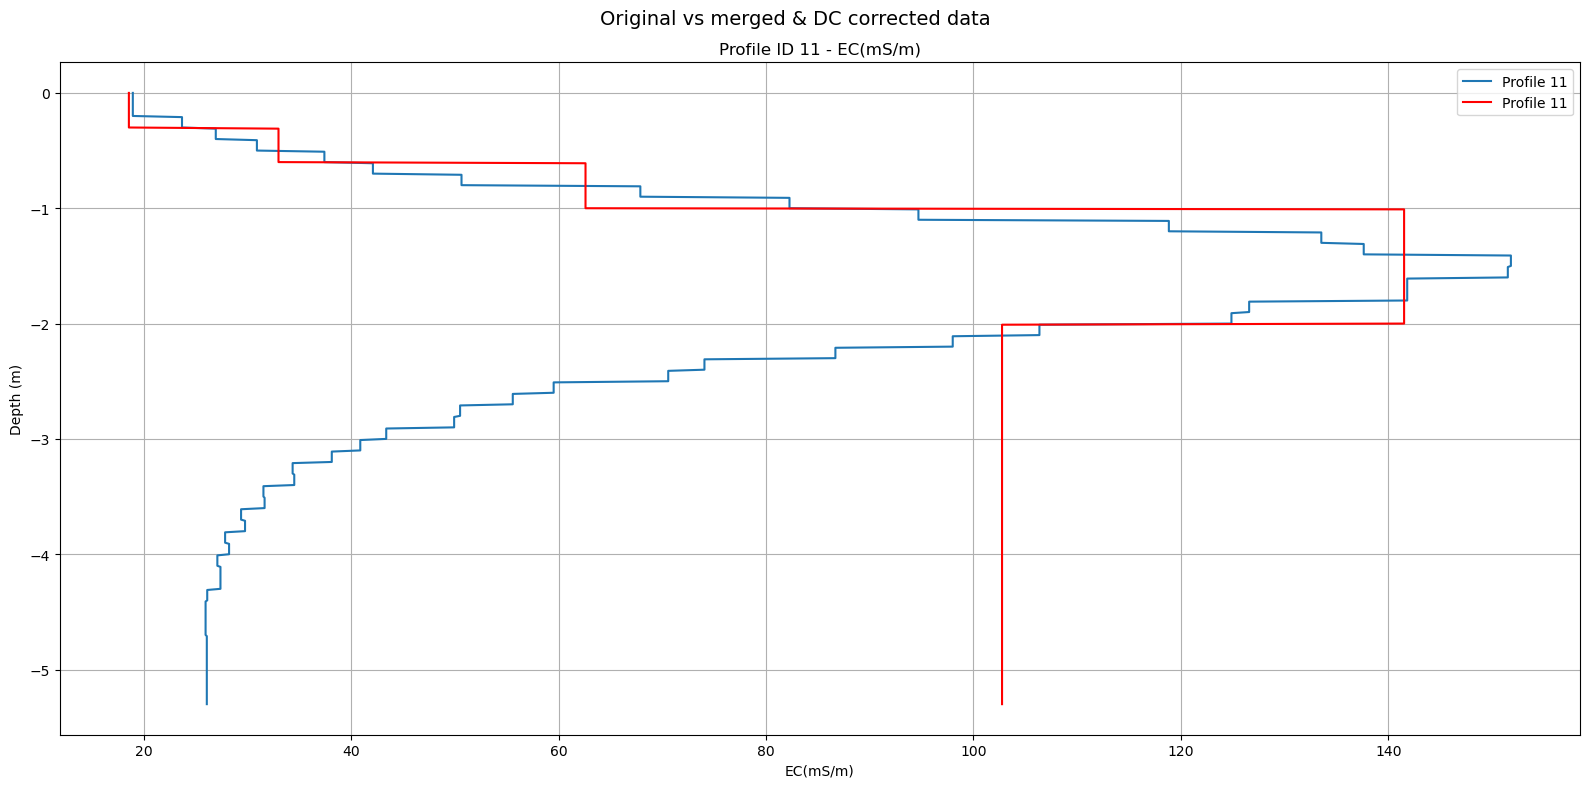

In [3]:
# config['reference_profile'] = 11

if config['reference_profile'] not in all_profiles_df['ID'].unique():
    warnings.warn("Warning: the reference profile ID does not exist. Provide correct profile ID.")
    raise KeyboardInterrupt
else:
    profile_id = config['reference_profile']

# Create new layer configuration for prior model based on ERT data
if config['n_int']:
    new_int = config['interface']
    merged_df = merge_layers(all_profiles_df, new_int,'EC(mS/m)')
else:
    merged_df = all_profiles_df
comparedf = merged_df.copy()

# Plot original and (merged and) DC corrected reference profile
if config['n_int']:
    plot_title = 'Original vs merged & DC corrected data'
    first_in = .1
else: 
    plot_title = 'Original vs DC corrected data'
    first_in = .0
ert_eval = ert_final.copy()
ert_eval['z'] = ert_eval['z'].values + first_in

plot_profile(ert_eval, profile_id, dataset_name, compare=True, compare_df = comparedf, compare_name = 'EC(mS/m)', block=True, plot_title=plot_title)

# Get prior model info
def generate_forward_model_inputs(df, profile_id_col, depth_col, res_col):
    models = {}  # Dictionary to store models by profile ID

    for profile_id, group in df.groupby(profile_id_col):
        # Assuming uniform interval after previous interpolation
        uniform_interval = abs(group[depth_col].diff().iloc[1])
        #print(uniform_interval)
        num_layers = len(group[res_col])
                # Thicknesses are the intervals between depths, except for the last value which does not define a new layer
        thick = np.full(num_layers - 1, uniform_interval)
        thick[0] = 2 * thick[0]
        # Conductivity is the inverse of resistivity
        con = group[res_col].values/1000
        # Permittivity is the epsilon_0 for all layers
        perm = np.full(num_layers, constants.epsilon_0)
        sus = np.zeros(num_layers)
        # Create model instance
        M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])
        
        # Store the model instance in the dictionary with the profile ID as the key
        models[profile_id] = M
    return models

models = generate_forward_model_inputs(merged_df, 'ID', 'z', 'EC(mS/m)')

C:\Users\mendo\AppData\Local\Temp\ipykernel_9632\1399804804.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ec_df = pd.concat([ec_df, pd.DataFrame([np.flip(con_m)], columns=ec_cols_ref)])


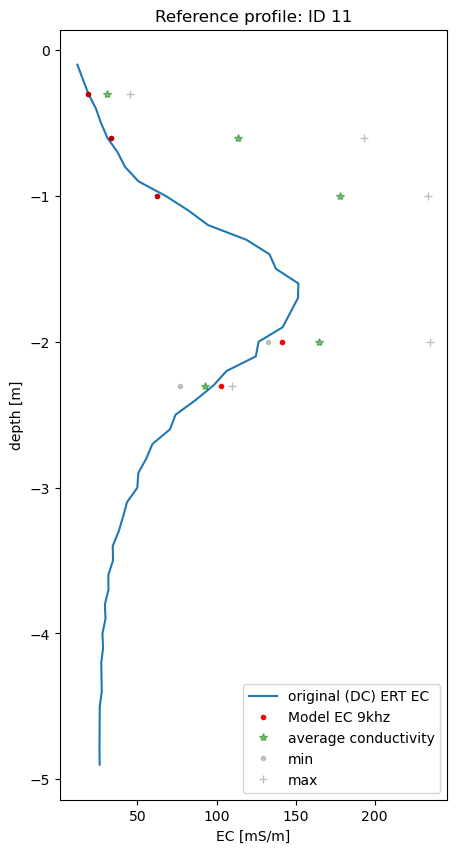

In [4]:
# 
# -------------------------------------------------------------------- #

# 
profile_data = merged_df[merged_df['ID'] == profile_id].copy()
res_col = 'EC(mS/m)'
depth = 'z'
max_ert_depth = ert_final['z'].abs().max()

# 
# ------------------------------------------------------------------------------

# A. Test run on the reference profile (config['reference_profile'])
#       and plot the results

if not config['n_int']:
    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)
    if first_lay == 0:
        profile_data[depth]=profile_data[depth] +second_lay
    else:
        profile_data[depth]=profile_data[depth] +first_lay
    thick = -profile_data[depth].iloc[1:].values
    #thick = -profile_data[depth].values
else:
    thick = -profile_data[depth].values

con = profile_data[res_col].values/1000
ref_len = len(con)
num_layers = len(con)
perm = np.full(num_layers, constants.epsilon_0)
sus = np.zeros(num_layers)

# # Create model instance
M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])

# ----------------------------------------------------------------------

dataset_name = 'EC(mS/m)'
layers_interfaces = np.cumsum(models[profile_id].thick)
layers_interfaces = np.insert(layers_interfaces, 0, 0)
profile_data = ert_final[ert_final['ID'] == profile_id]

fig, axr = plt.subplots(figsize=(5, 10))
axr.set_xlabel('EC [mS/m]')
axr.set_ylabel('depth [m]')
axr.plot((profile_data[dataset_name]),profile_data['z'], label='original (DC) ERT EC',)
if not config['n_int']: 
    axr.plot(con[:-1]*1000,-thick, '.', label='Model EC 9khz',color = 'red')
else:
    axr.plot(con*1000,-thick, '.', label='Model EC 9khz',color = 'red')
axr.set_title(f'Reference profile: ID {profile_id}')

conductivities = con*1000

ec_cols_ref = []
if 'end' in config['interface']:
    config['interface'].remove('end')
# Get conductivity stats for bounds
if config['n_int']:
    if 'end' in ec_cols_ref:
        ec_cols_ref.remove('end')
    ec_cols_ref = config['interface']
    ec_cols_ref.append('end')
    mod_layers = thick[1:]
else:
    if len(conductivities) == len(thick):
        mod_layers = thick[1:]
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    elif len(conductivities) == (len(thick)+1):
        mod_layers = thick
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    else:
        raise ValueError(f"Check length of conductivities ({len(conductivities)}) and layers ({len(thick)}) arrays!!")
    
    ec_cols_ref = np.round(layers_interfaces,decimals=1).tolist()
ec_df = pd.DataFrame(columns=ec_cols_ref)

# 
for i in merged_df['ID'].unique(): 
    profile_data = merged_df[merged_df['ID'] == i].copy()
    if not config['n_int']:
        if abs(profile_data.iloc[0]['z']) > max((list(map(abs, ec_cols_ref)))):
            #print(f'removed {profile_data.iloc[0]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[0].name)
        elif abs(profile_data.iloc[-1]['z']) < 0.1:
            #print(f'removed {profile_data.iloc[-1]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[-1].name)
    res_col = 'EC(mS/m)'
    depth = 'z' 
    con_m = profile_data[res_col].values
    layers_interfaces = np.cumsum(models[i].thick)
    layers_interfaces = np.insert(layers_interfaces, 0, 0)
    num_layers = len(con)
    perm = np.full(num_layers, constants.epsilon_0)
    sus = np.zeros(num_layers)

    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)

    if not config['n_int']:
        first_lay = profile_data[depth].iloc[-1].round(decimals=1)
        second_lay = profile_data[depth].iloc[-2].round(decimals=1)
        if first_lay == 0:
            profile_data[depth]=profile_data[depth] +second_lay
        else:
            profile_data[depth]=profile_data[depth] +first_lay
        thick = -profile_data[depth].iloc[1:].values
    else:
        thick = -profile_data[depth].values

    ec_df = pd.concat([ec_df, pd.DataFrame([np.flip(con_m)], columns=ec_cols_ref)])

    # if a == 1:
    #     fig, ax = plt.subplots(figsize=(5, 10))
    #     ax.set_xlabel('EC [mS/m]')
    #     ax.set_ylabel('depth [m]')
    #     profile_data = ert_final[ert_final['ID'] == i]
    #     ax.plot((profile_data[dataset_name]),profile_data['z'], label='original (DC) ERT EC',)
    #     if not config['n_int']:
    #         ax.plot(con[:-1],-thick, '.', label='Model EC 9khz',color = 'red')
    #     else:
    #         ax.plot(con,-thick, '.', label='Model EC 9khz',color = 'red')
    #     ax.set_title(f'profile {i}')
    #     ax.legend()
    #     a = a +1

ec_df.reset_index(drop=True, inplace=True)

ec_stats = ec_df.describe().loc[['min', 'max', 'std', '50%', 'mean']]
ec_stats.rename(index={'50%': 'median'}, inplace=True)
ec_stats.loc['min_sd'] = ec_stats.loc['min'] - 2 * ec_stats.loc['std']
ec_stats.loc['max_sd'] = ec_stats.loc['max'] + 2 * ec_stats.loc['std']

position = -thick


# define parameters for inversion starting model
# --------------------------------------------- #

if not config['n_int']:
    minstat = np.flipud(ec_stats.loc['min'].values[1:])
    maxstat = np.flipud(ec_stats.loc['max'].values[1:])
    start_mod = ec_stats.loc['mean'].values[1:]
    boundcols = ec_cols_ref[:-1]
else:
    minstat = np.flipud(ec_stats.loc['min'].values)
    maxstat = np.flipud(ec_stats.loc['max'].values)
    start_mod = ec_stats.loc['mean'].values

axr.plot(np.flipud(start_mod),position, 
            '*', 
            label='average conductivity',
            color = 'green',
            alpha = 0.5)
axr.plot(minstat,position, 
            '.', 
            label='min',
            color = 'black',
            alpha = 0.2)
axr.plot(maxstat,position, 
            '+', 
            label='max',
            color = 'black',
            alpha = 0.25)

axr.legend()
if config['constrain']:
    if config['custom_bounds']:
        bounds = config['bounds']
    else:
        bounds = []
        for i, name in enumerate(ec_cols_ref):
            if ec_stats.loc['min_sd'][name] > 0:
                min = ec_stats.loc['min_sd'][name]
            elif ec_stats.loc['min'][name] > 0:
                min = ec_stats.loc['min'][name]
            else:
                min = 10
            max = ec_stats.loc['max_sd'][name]
            min_max = tuple([min,max])
            bounds.append(min_max)
        bounds = np.round(bounds, decimals=0)
        if not config['n_int'] and not config['custom_bounds']:
            bounds = bounds[1:]
        print(f'autobounds = {bounds}')

In [5]:
print(f'conductivities = {len(conductivities)}')
#print(f'con = {con*1000}')
print(f'thicknesses = {len(thick)}')
print(f'mod_layers = {len(mod_layers)}')

conductivities = 5
thicknesses = 5
mod_layers = 4


length modlayers = 4 with 5 conductivities
Data used for inversion: ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165', 'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165']
lengths: mod_layers = 4; bounds =  5; con = 5


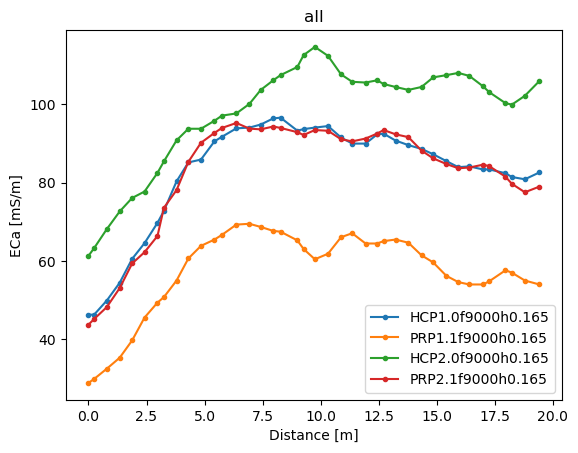

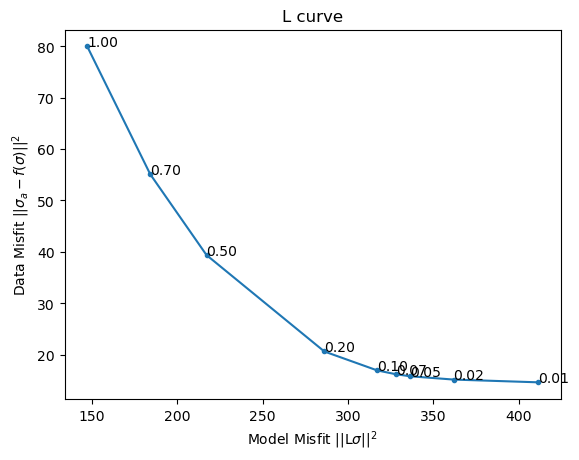

In [6]:
# FDEM inversion along ERT transect
# --------------------------------

if em_intype == 'rec':
    em_input = em_rec.copy()
elif em_intype == 'survey':
    em_input = em_survey.copy()
else:
    em_input = em_lin.copy()

if config['start_avg']:
    conductivities = start_mod
    if len(conductivities) == len(mod_layers):
        mod_layers = mod_layers[1:]
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    elif len(conductivities) == (len(mod_layers)+1):
        mod_layers = mod_layers
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")

if 'p_ID' in em_input.columns:
    em_input = em_input.rename(columns={"p_ID": "ID"})

temp_dir = 'temp_emp' 
infile_name = 'infile.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
n = 4
em_input.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_input.columns.values[n:n+i] = new_columns

em_input.to_csv(temp_file)

# transect inversion settings
t_rec = Problem()
t_rec.createSurvey(temp_file)

t_rec.setInit(
    depths0=np.flipud(mod_layers),
    conds0=np.flipud(conductivities)
    # fixedDepths=startmodel['fixedDepths'],
    # fixedConds=startmodel['fixedConds']
    )
shutil.rmtree(temp_dir)

if config['remove_coil']:
    if type(config['coil_n']) == list:
        config['coil_n'] = sorted(config['coil_n'])
        for i in enumerate(config['coil_n']):
            r_coil = t_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
            t_rec.removeCoil(config['coil_n'][i[0]]-i[0])
    else:
        t_rec.removeCoil(config['coil_n'])
print(f'Data used for inversion: {t_rec.coils}')
t_rec.show()

# n = -2
# m = 1
# inc = 0.01
# n_alph = 10

# alphas = np.logspace(n,m,n_alph)
t_rec.lcurve(alphas=[0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5, 0.7, 1])
if config['constrain']:
    print(f'lengths: mod_layers = {len(mod_layers)}; bounds =  {len(bounds)}; con = {len(conductivities)}')
else:
    print(f'lengths: mod_layers = {len(mod_layers)}; con = {len(conductivities)}')

Inversion using FSeq with Gauss-Newton, reg=l2, alpha=0.5
40/40 inverted

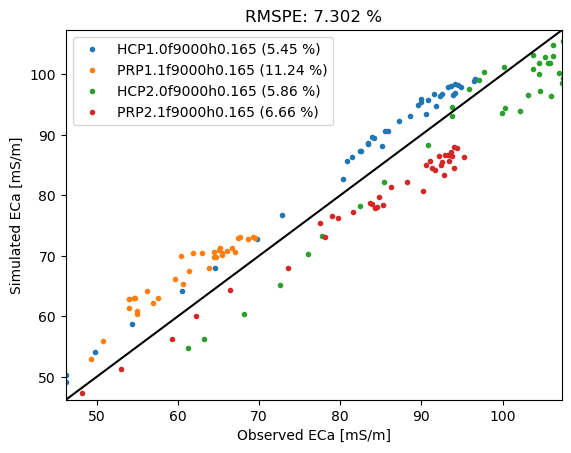

In [7]:
if not only_samples:
    # invert using ROPE solver (RObust Parameter Estimation)
    warnings.filterwarnings('ignore')
    
    inv_meth = config['fs_emp']
    opt_meth = config['opt_method']
    reg_meth = config['regularization']
    alph_param = config['alpha']

    if opt_meth in ['MCMC', 'ROPE']:
        if config['constrain']:
            print(f'Constrained inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
            print(f'Bounds are: {bounds}')
            t_rec.invert(forwardModel=inv_meth, 
                         method=opt_meth, 
                         regularization=reg_meth, 
                         alpha=alph_param, 
                         bnds=bounds,
                         rep=3000,
                         njobs=-1
                        )
        else:
            print(f'Inversion using {inv_meth} with {opt_meth},reg={reg_meth}, alpha={alph_param}')
            t_rec.invert(forwardModel=inv_meth, 
                         method=opt_meth, 
                         regularization=reg_meth, 
                         alpha=alph_param, 
                         njobs=-1
                        )  

    else:
        print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        t_rec.invert(forwardModel=inv_meth, 
                     method=opt_meth, 
                     alpha=alph_param,
                     regularization=reg_meth
                     )
    t_rec.showOne2one()

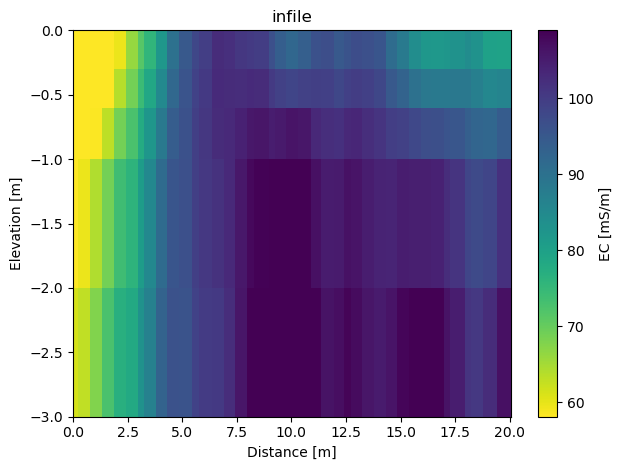

In [8]:
if not only_samples:
    # 4.1: Plot the inversion results and put outcomes into a pandas dataframe
    # ------------------------------------------------------------------------
    csv_filename = f'{now}_{emfile_prefix}_inverted_transect_{opt_meth}.csv'

    # ******************************************************************** #

    # Plot inversion outcomes down to a max depth of 2 m, and plotting the data
    # based on their true coordinates along the transect (dist=True).
    t_rec.showResults(dist=True, errorbar = True) 

    # Extracting the values from the first row of the transect.depths[0] array
    depth_values = t_rec.depths[0][0]

    # Creating the custom column names for layer_cols
    layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

    # Combining the data from the 'x', 'y' columns and the transect.models[0] array
    data = np.c_[t_rec.surveys[0].df[['x', 'y']].values, t_rec.models[0]]

    # Creating the final dataframe with the desired column names
    dt_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
    dt_inv['pos'] = em_input['ID']
    # ----------------------------------------------------------------------

    # Export the dataframe as a csv-file
    outfile_transect = os.path.join(inv_folder, csv_filename)
    dt_inv.to_csv(outfile_transect)

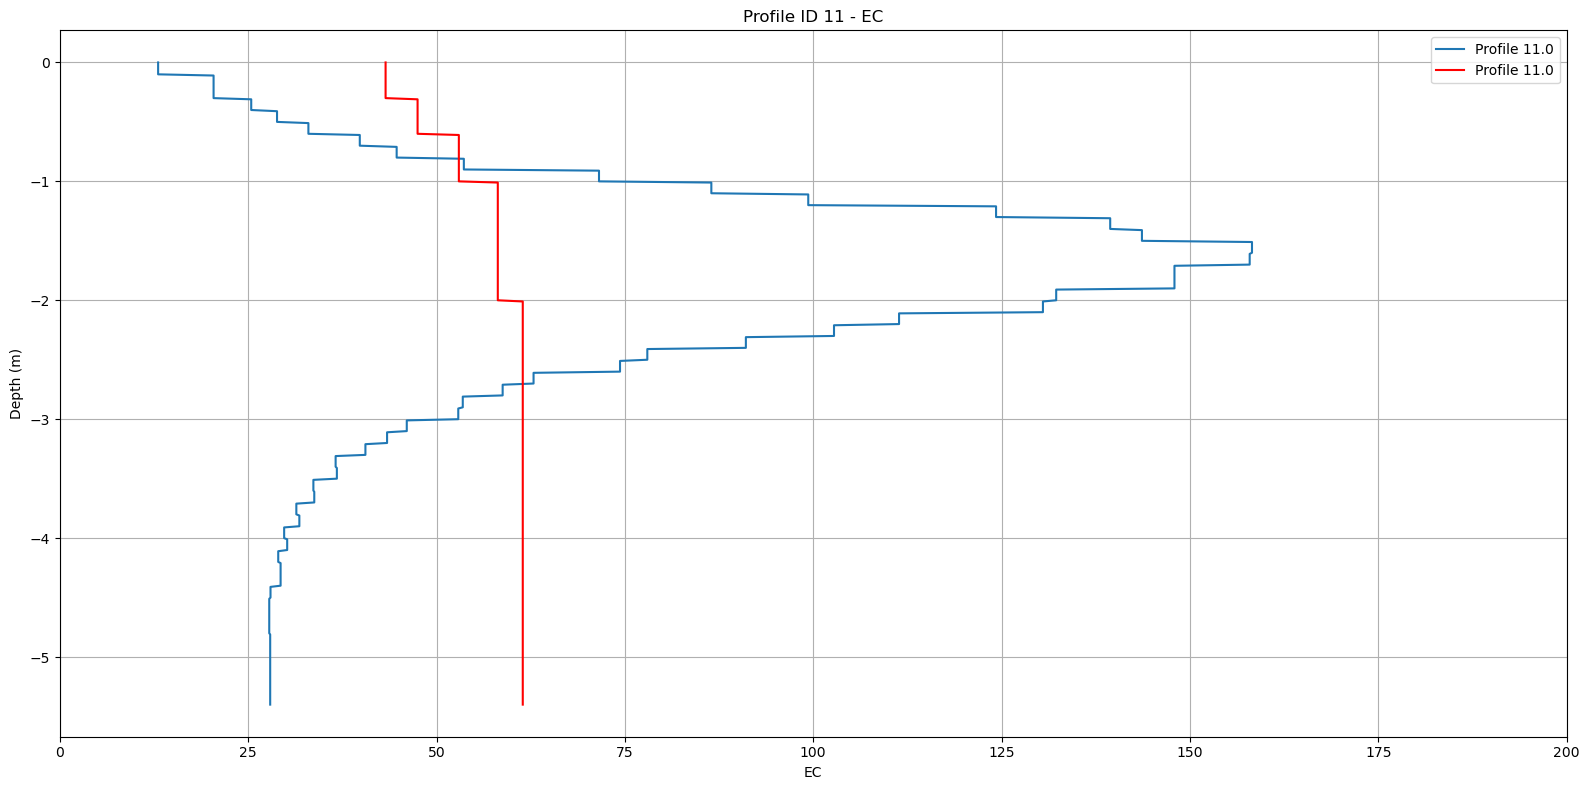

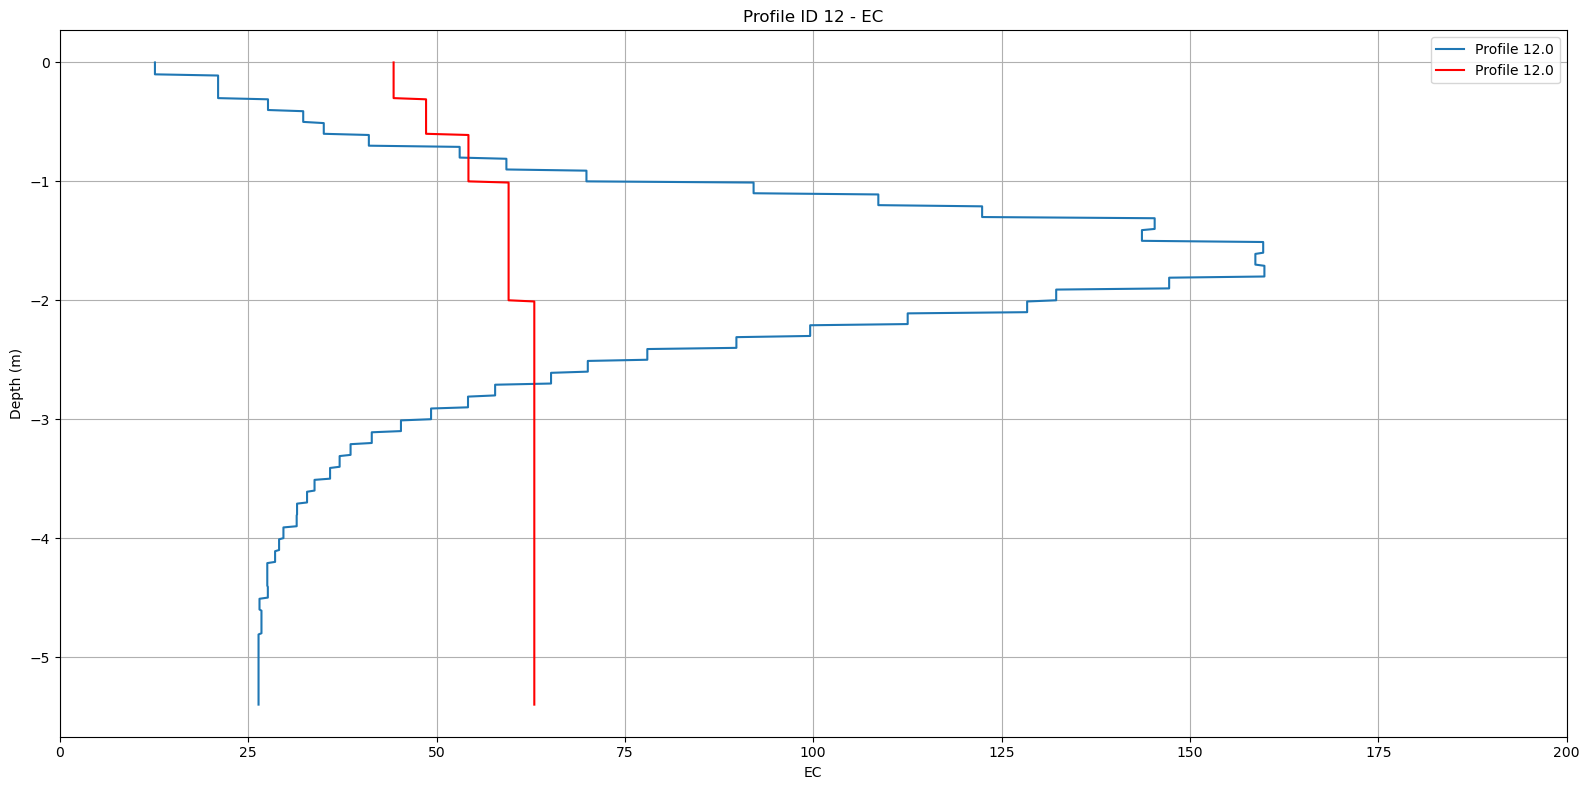

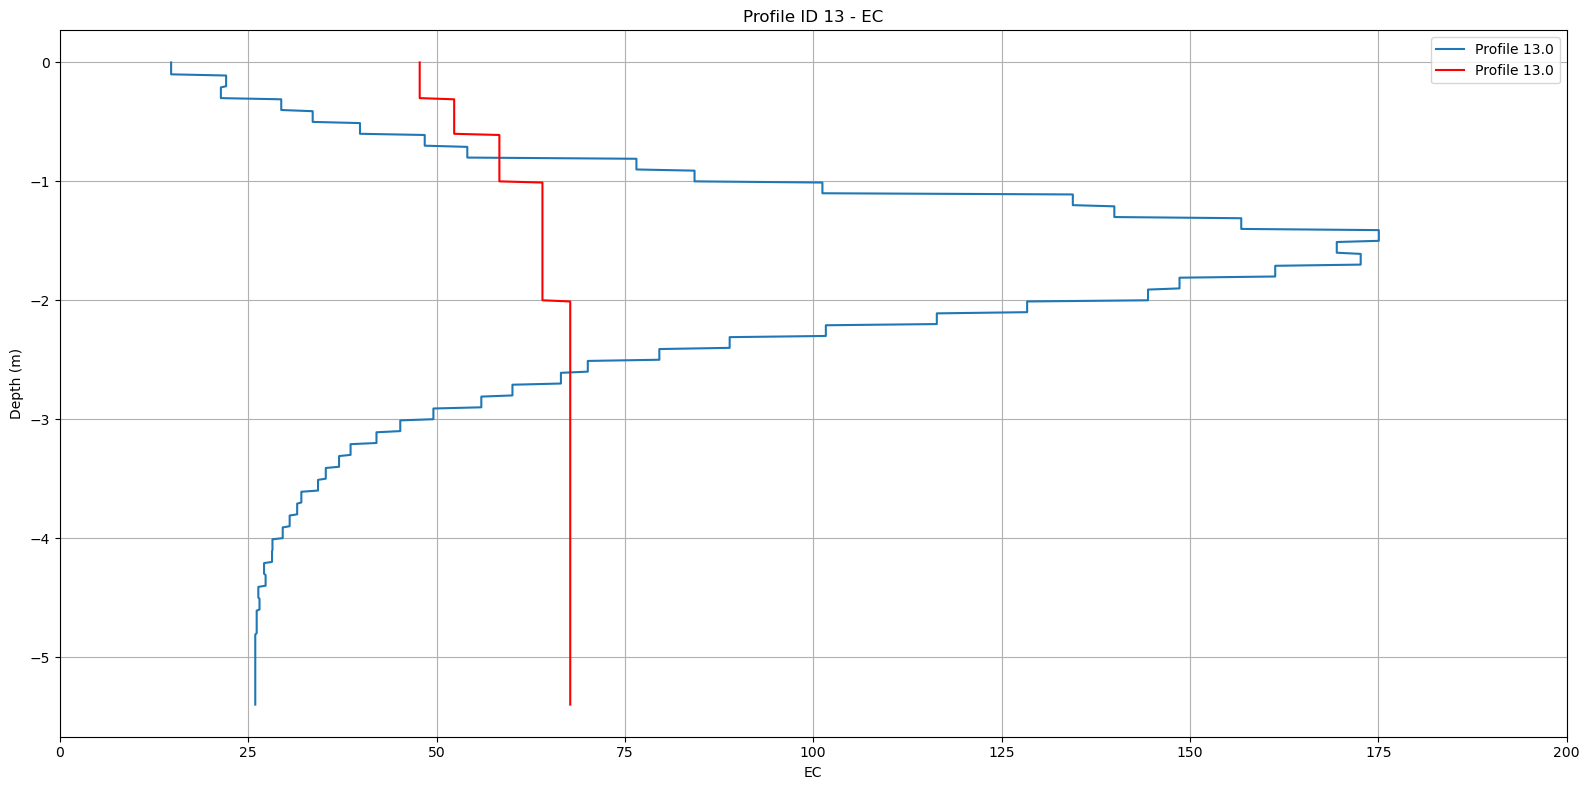

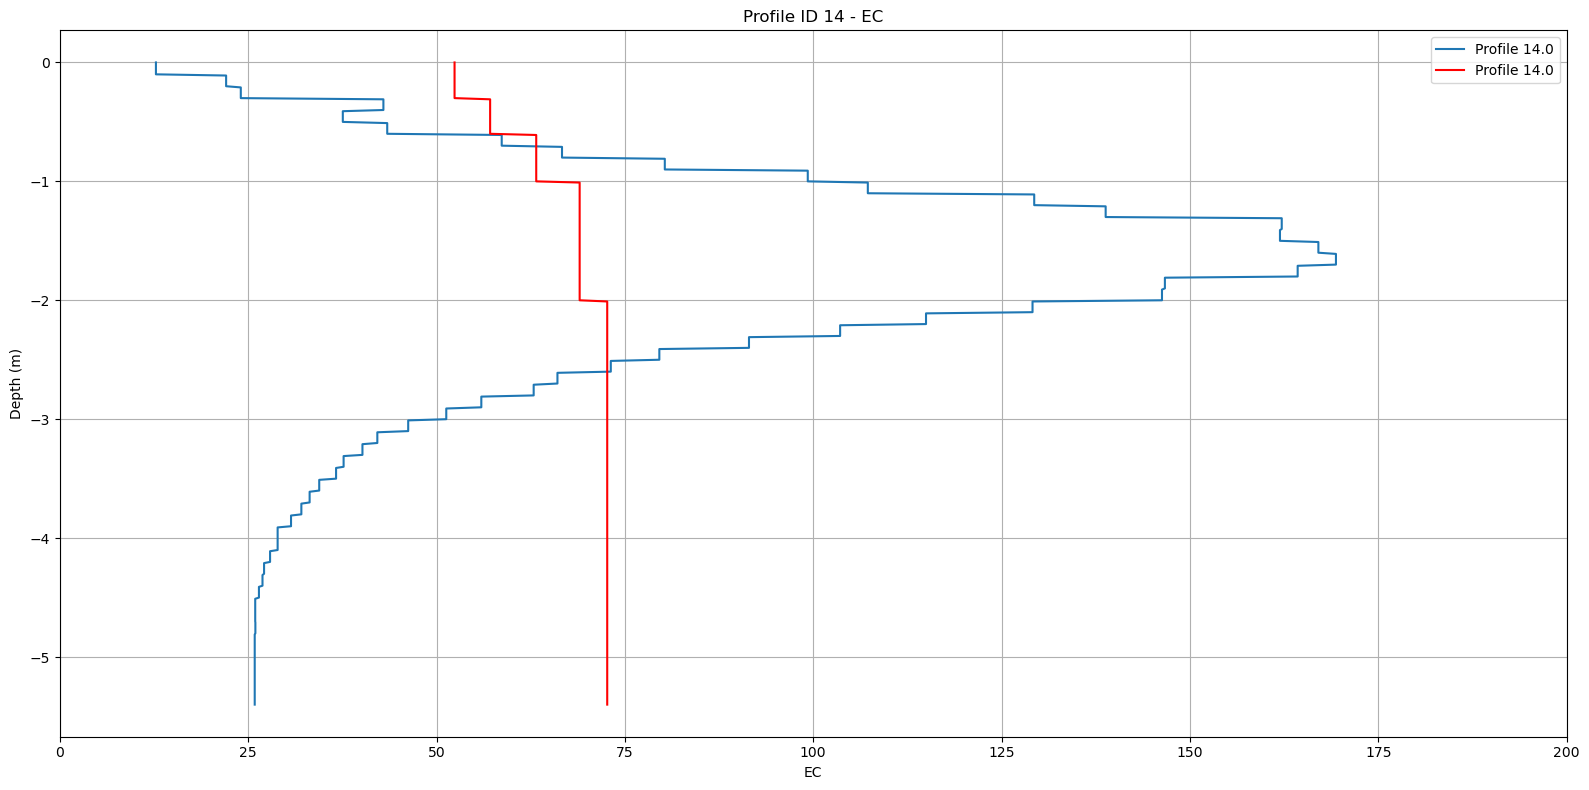

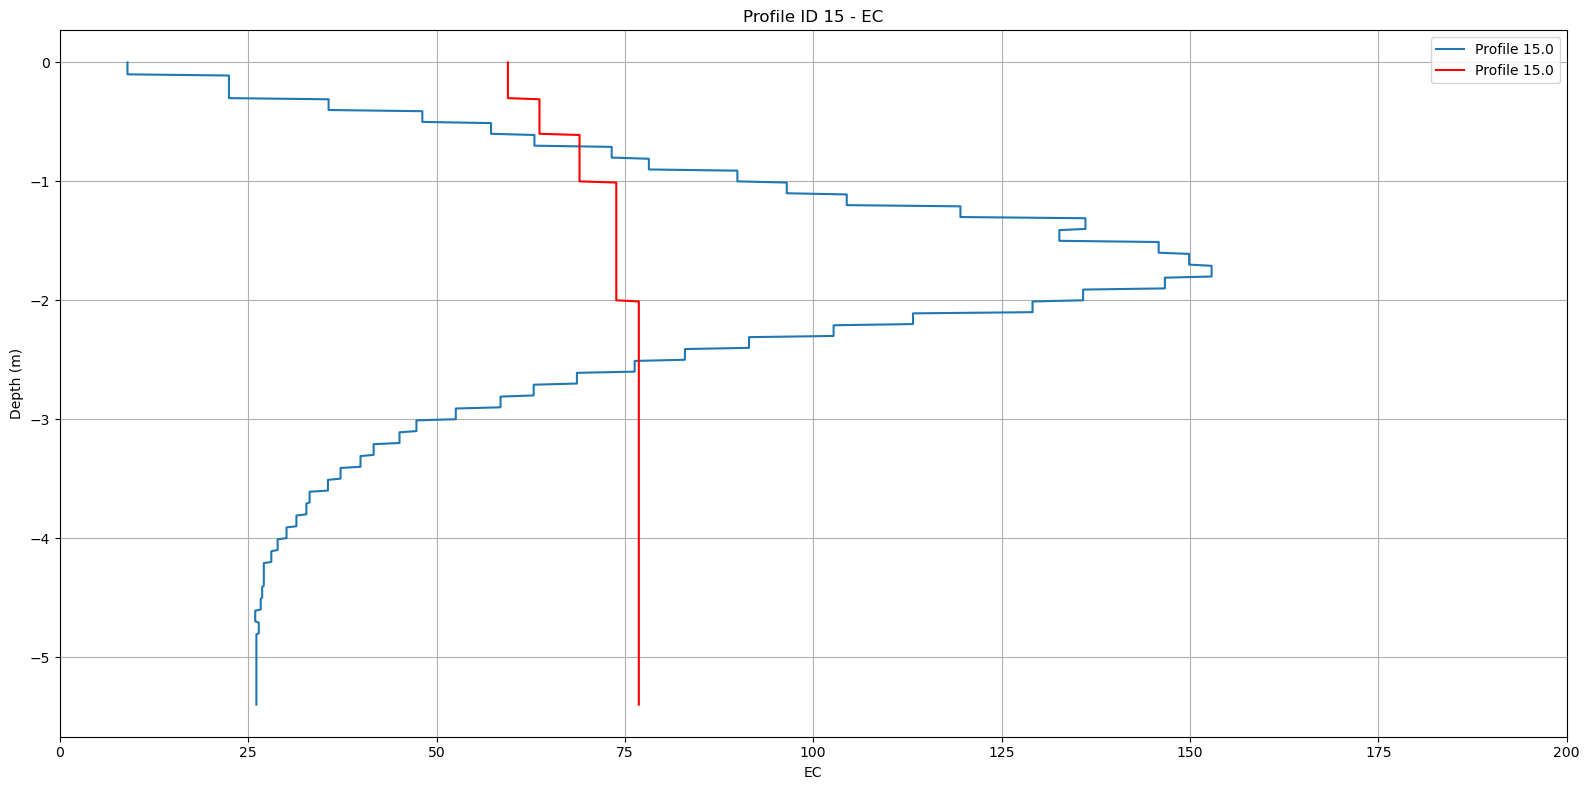

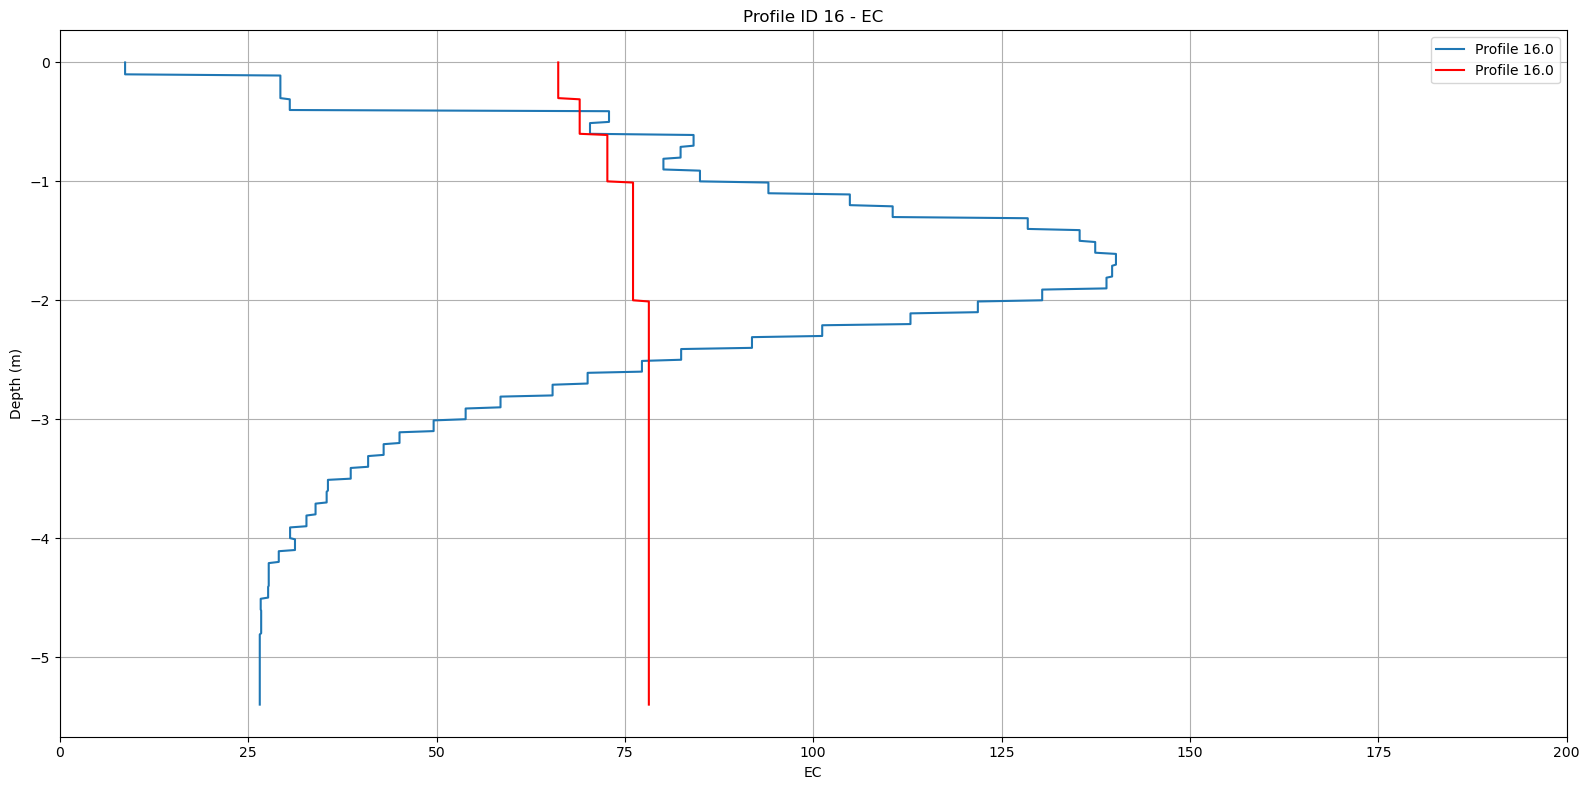

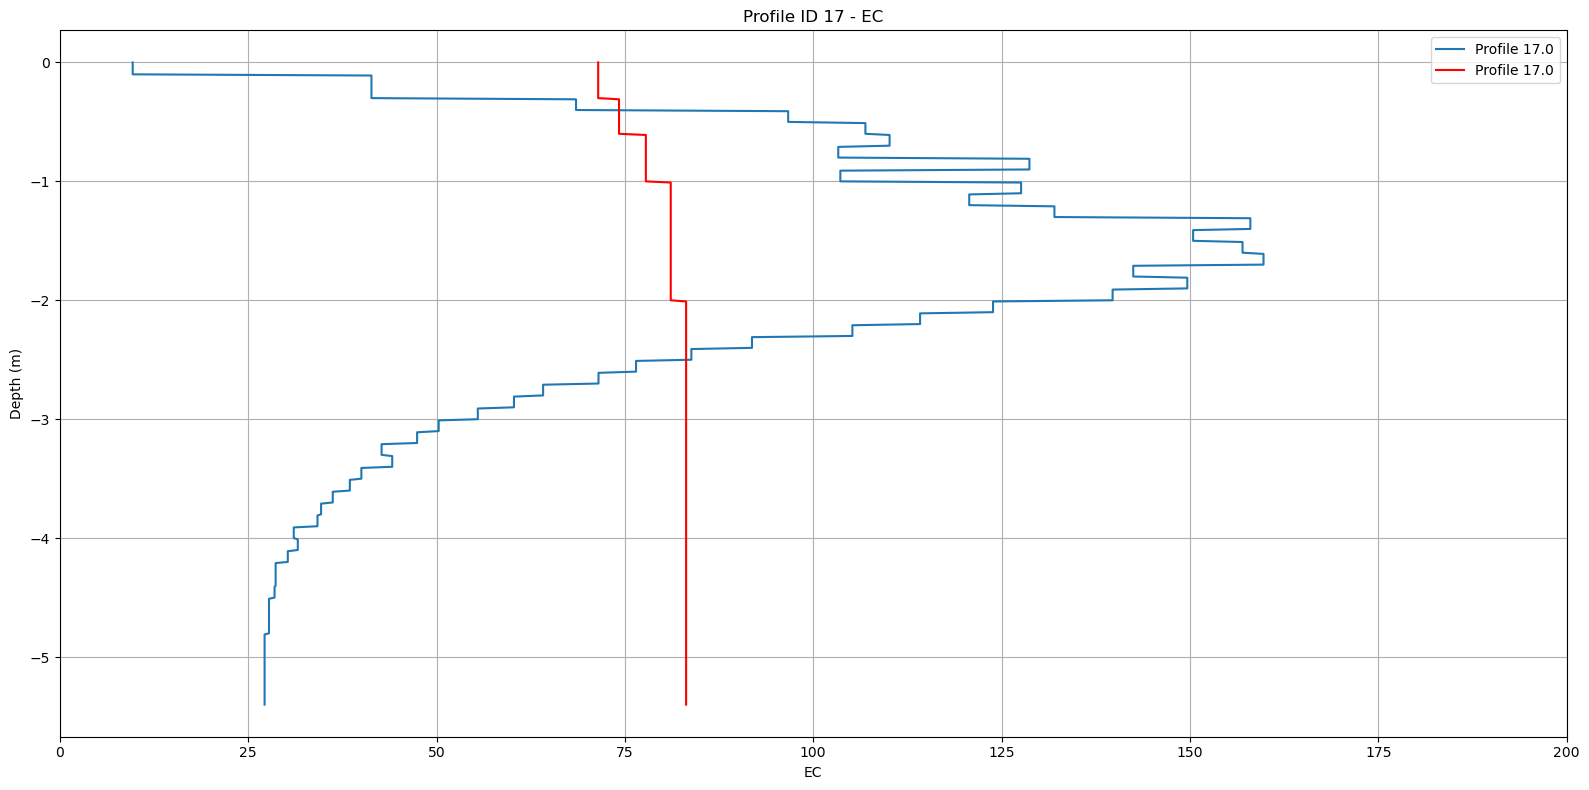

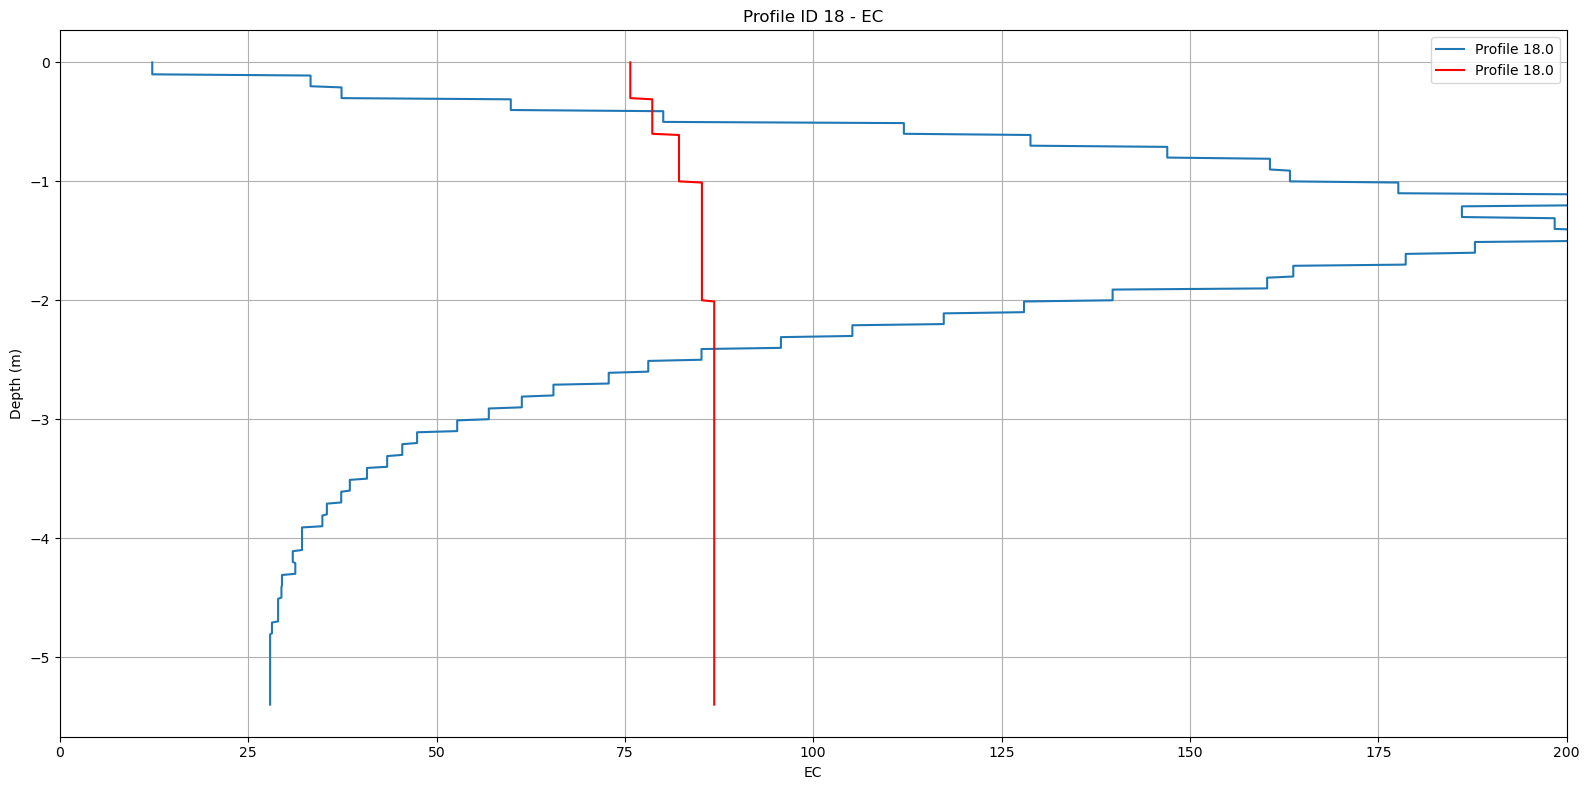

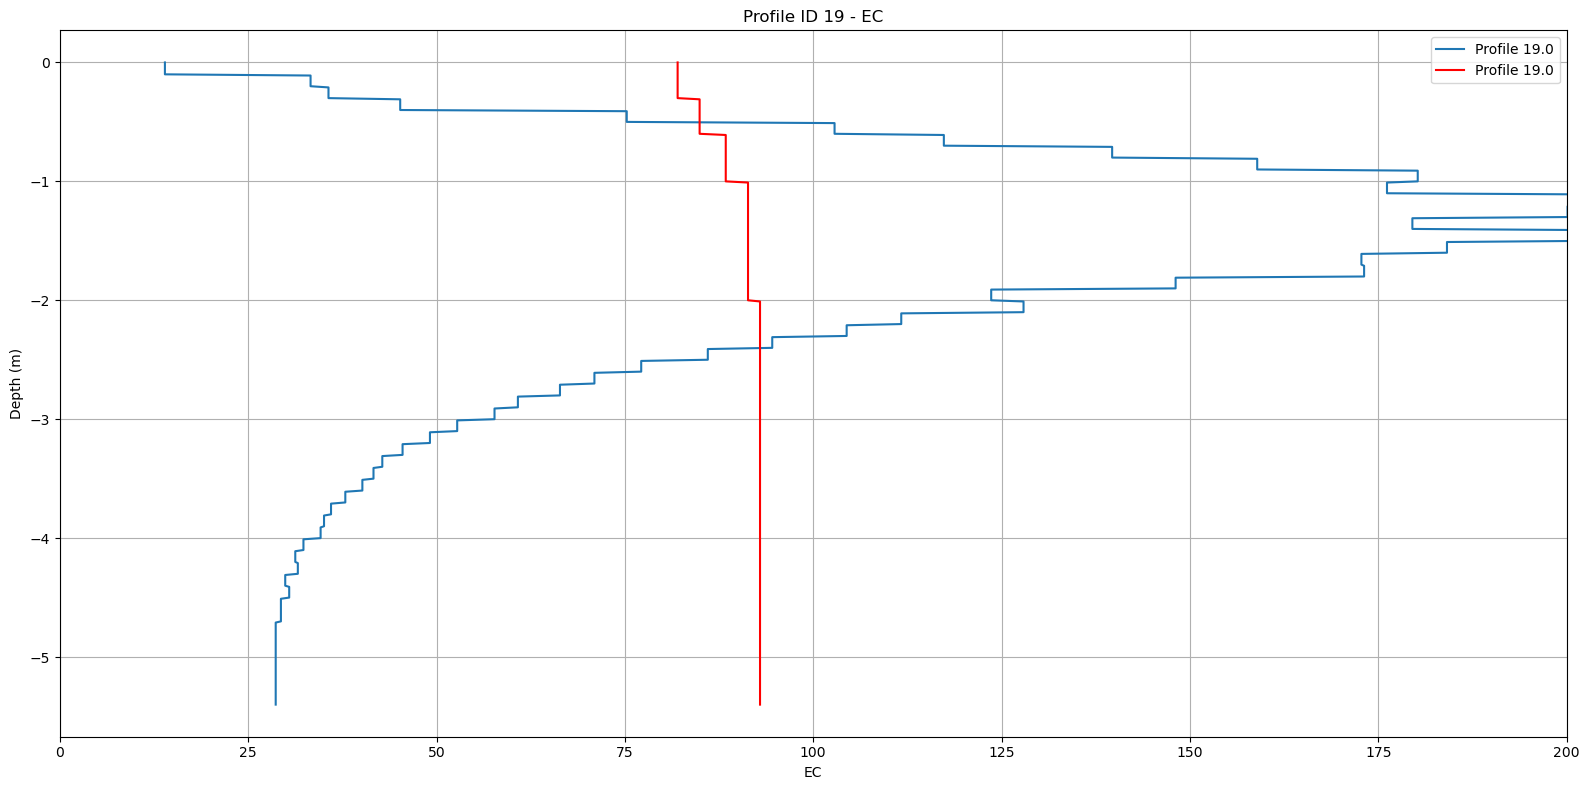

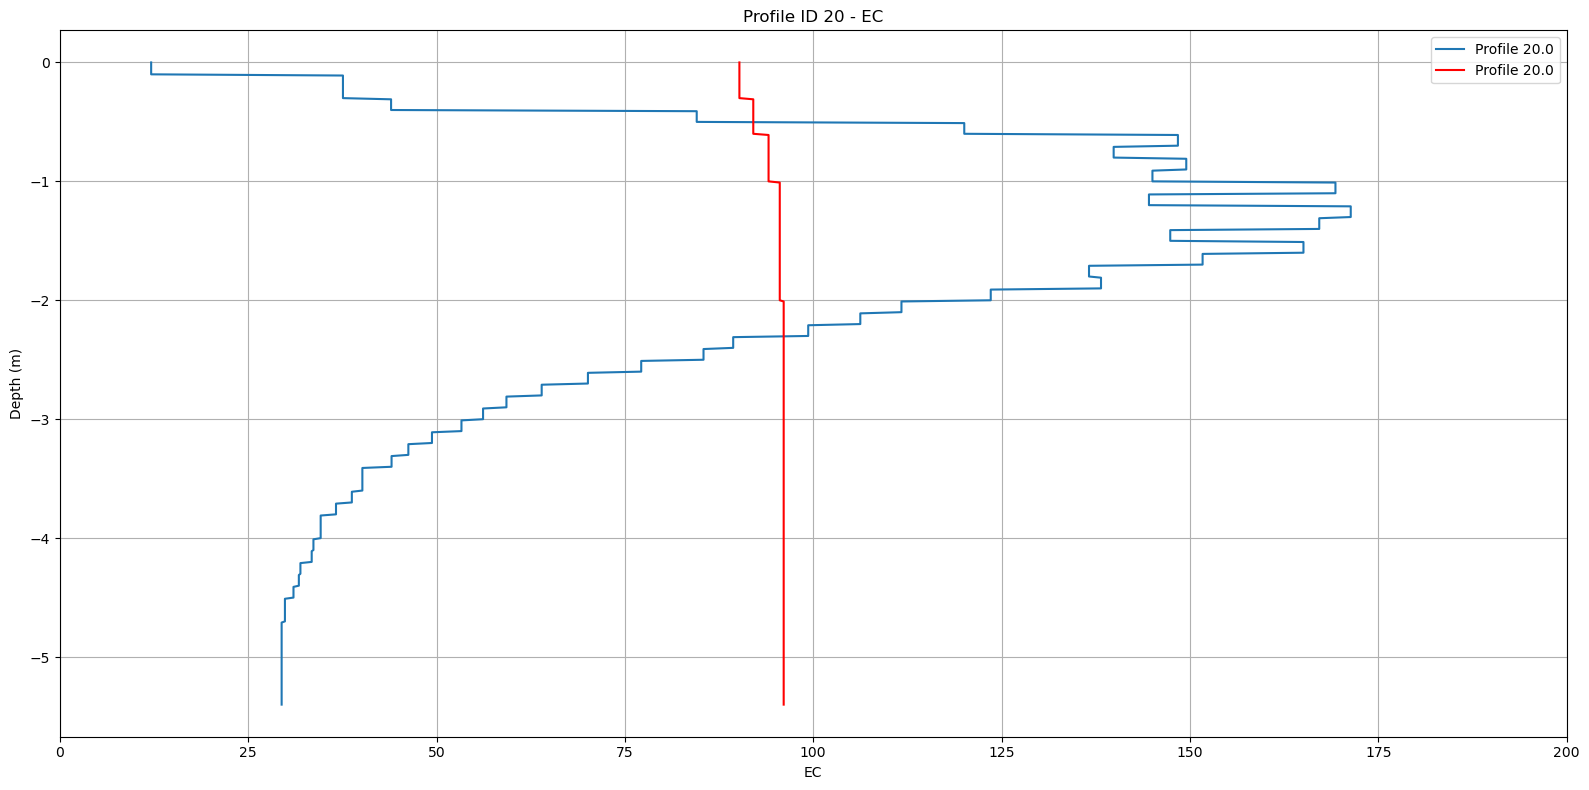

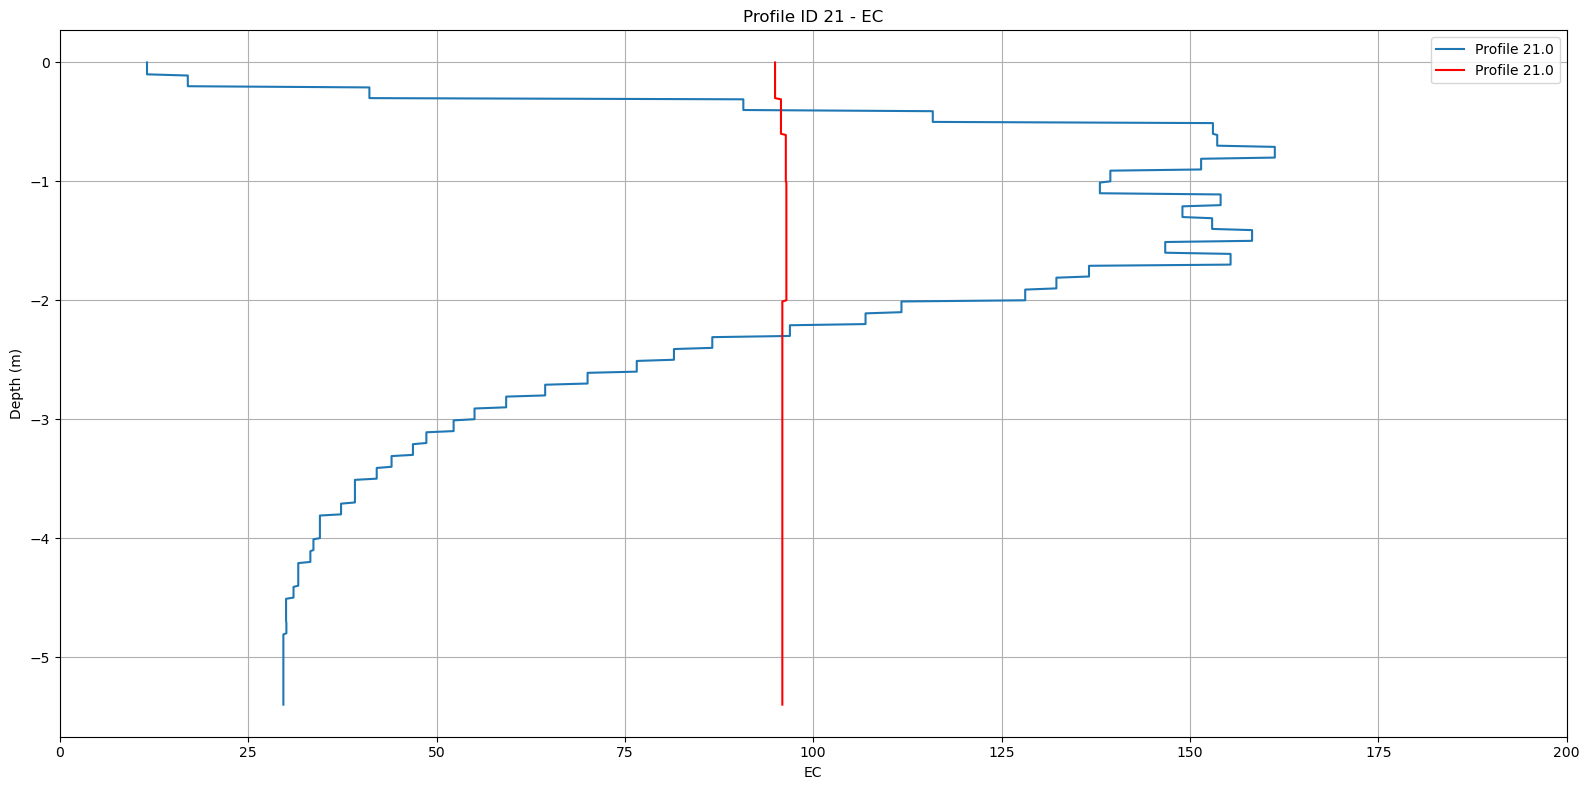

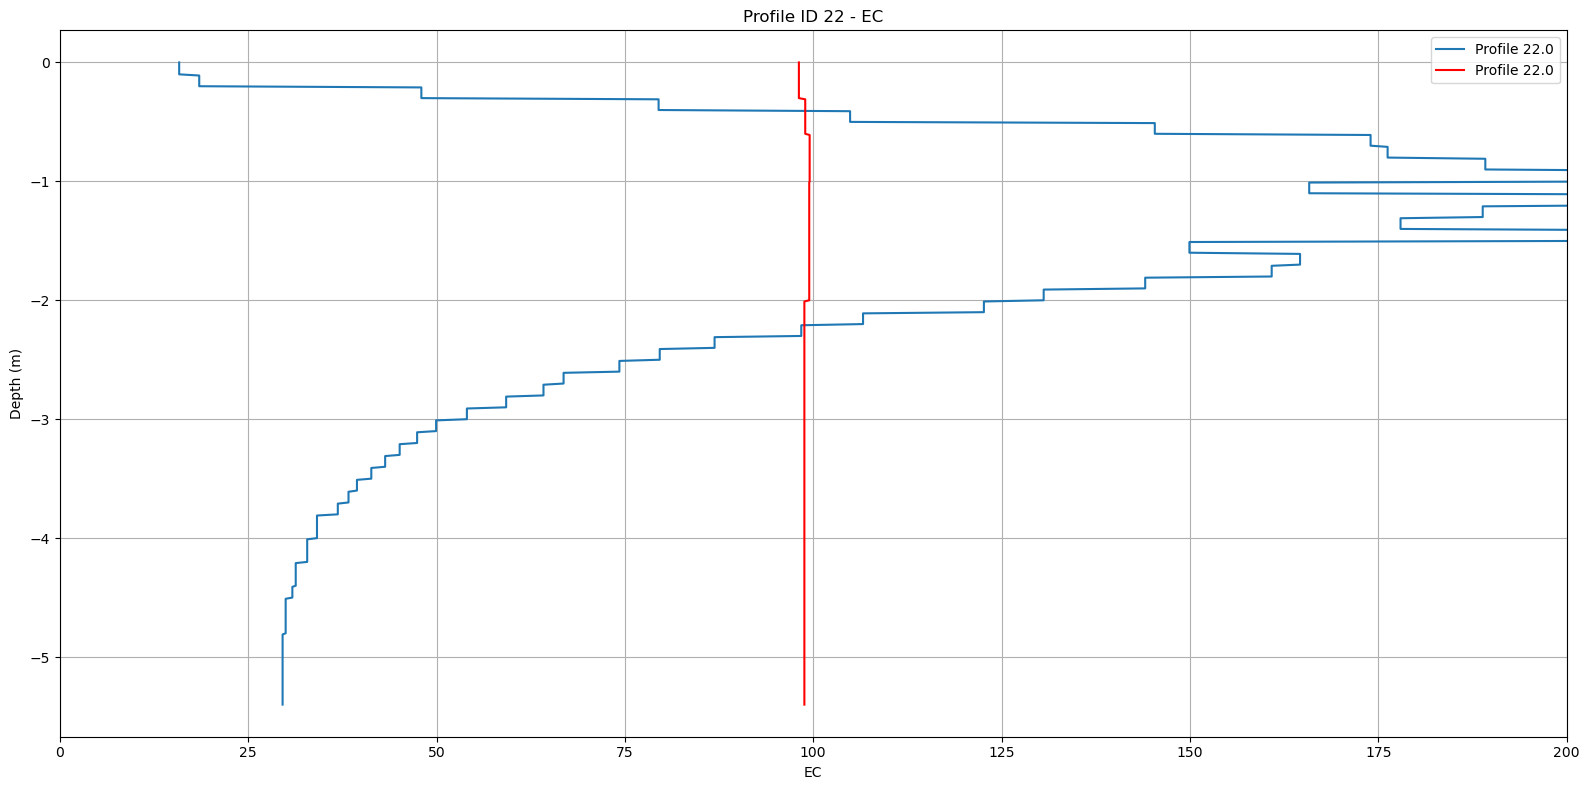

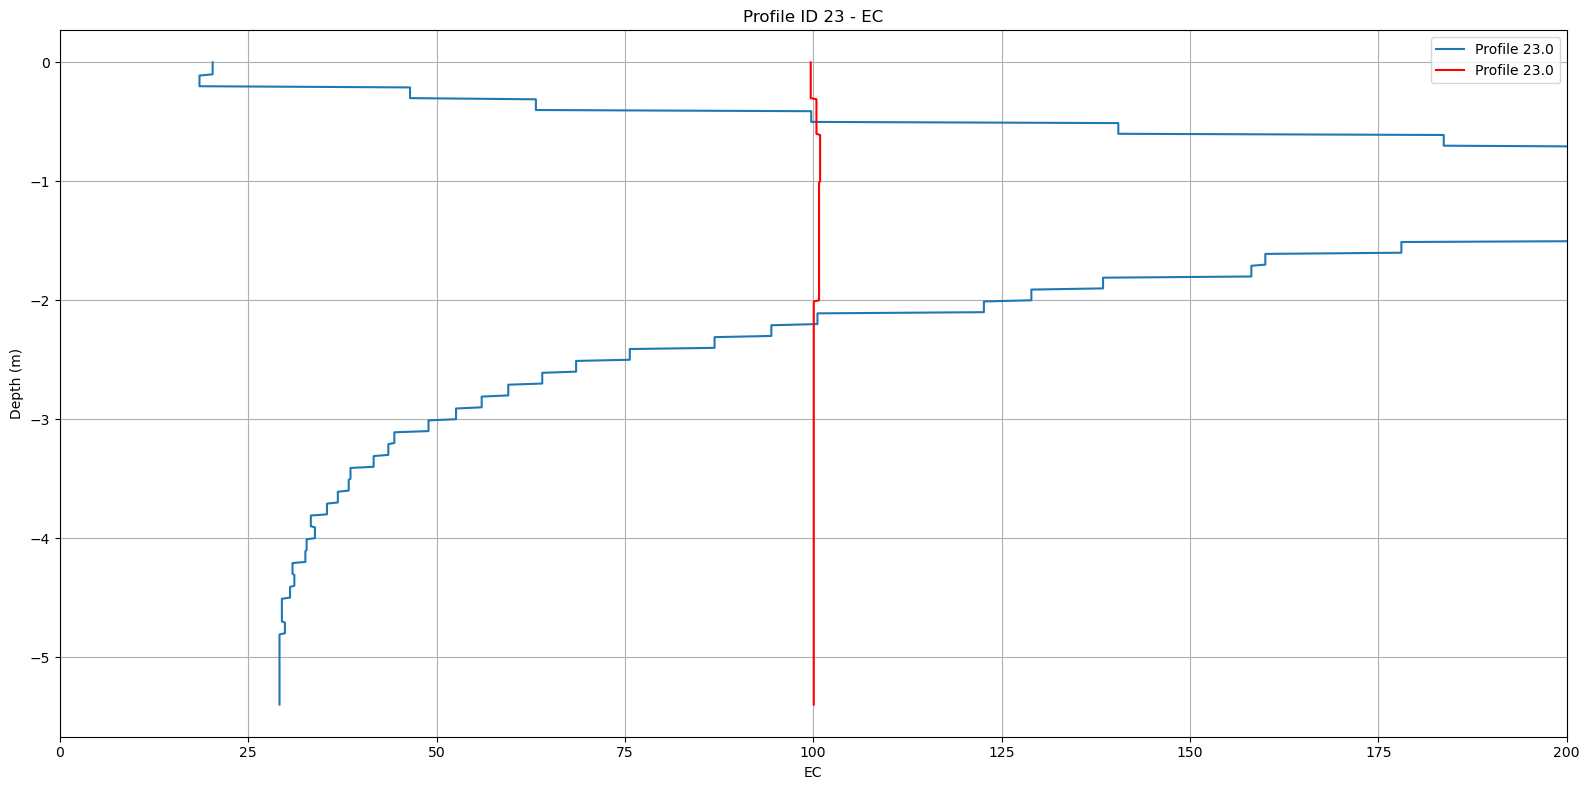

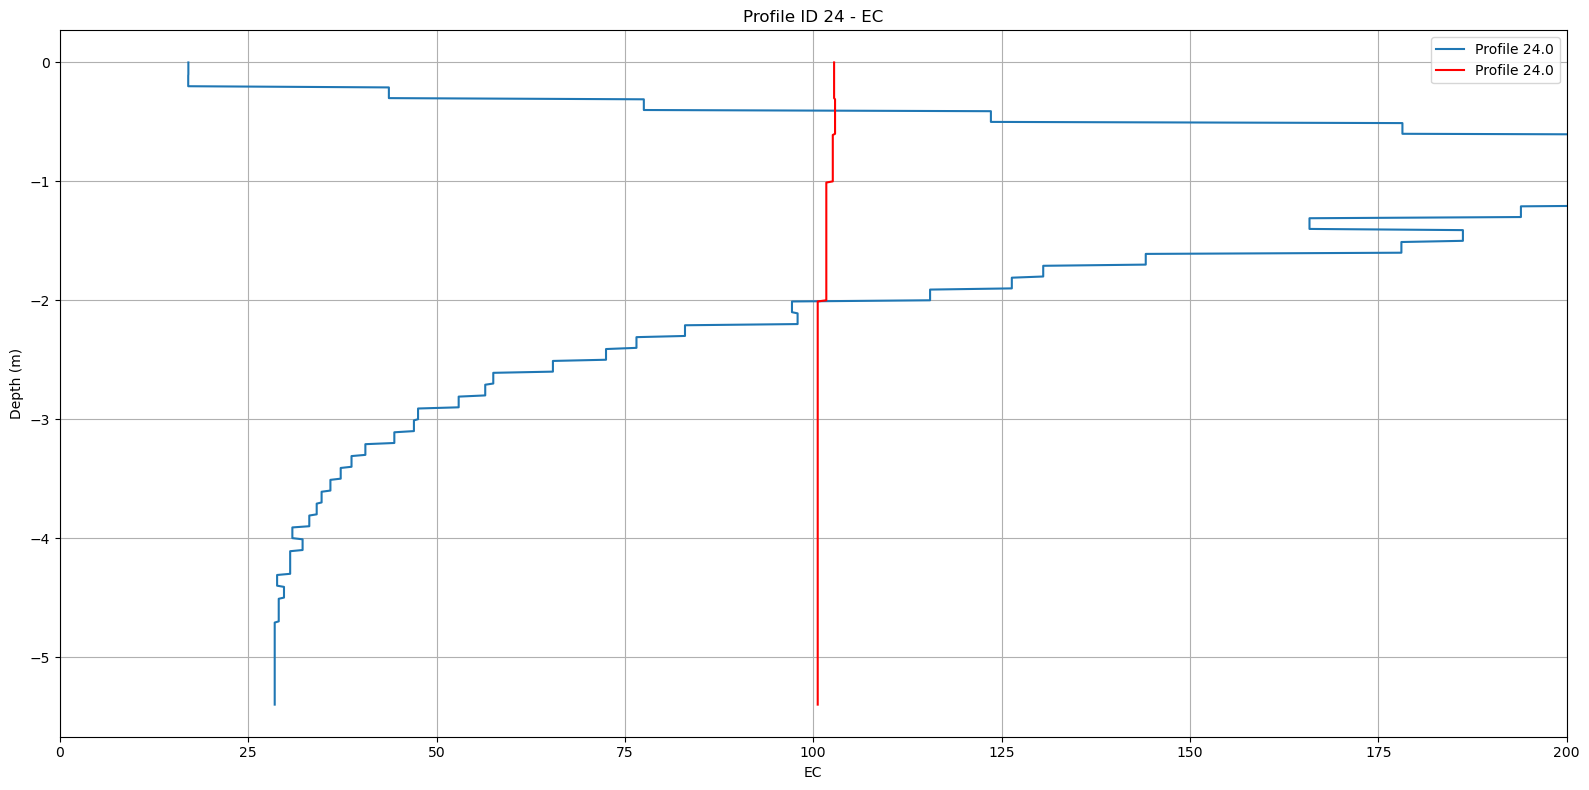

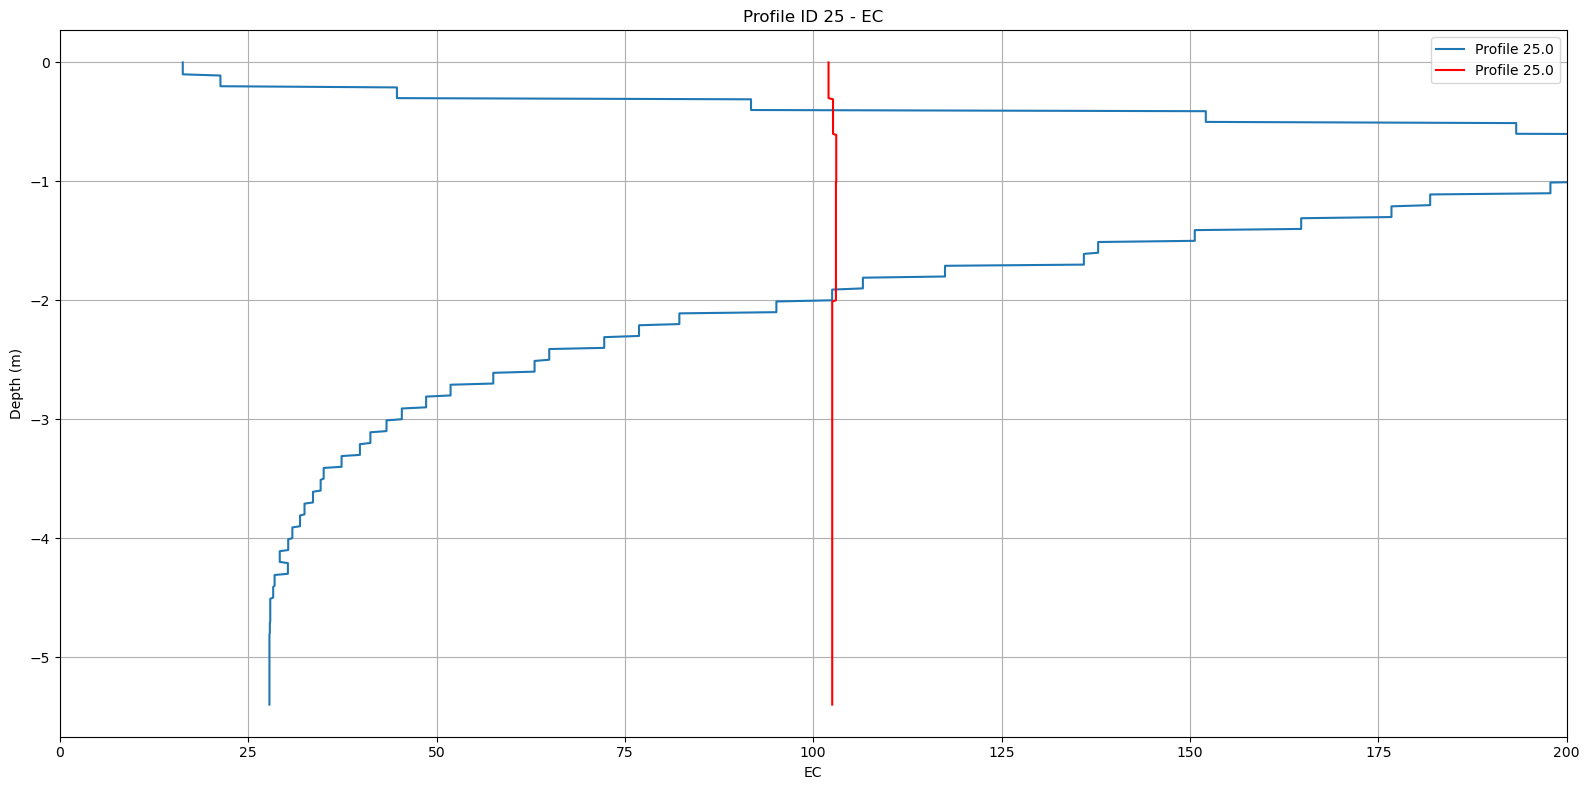

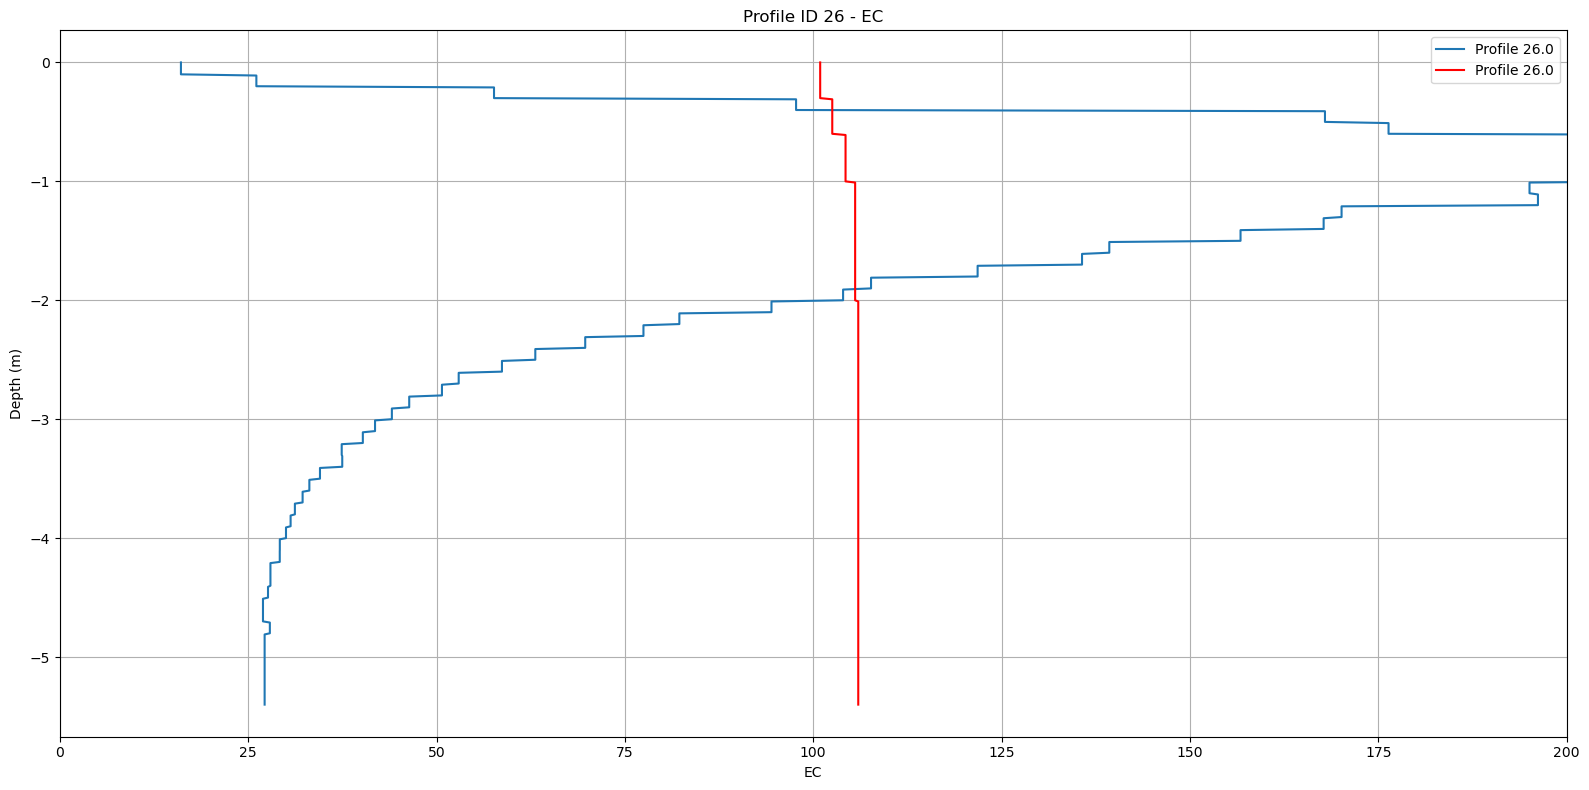

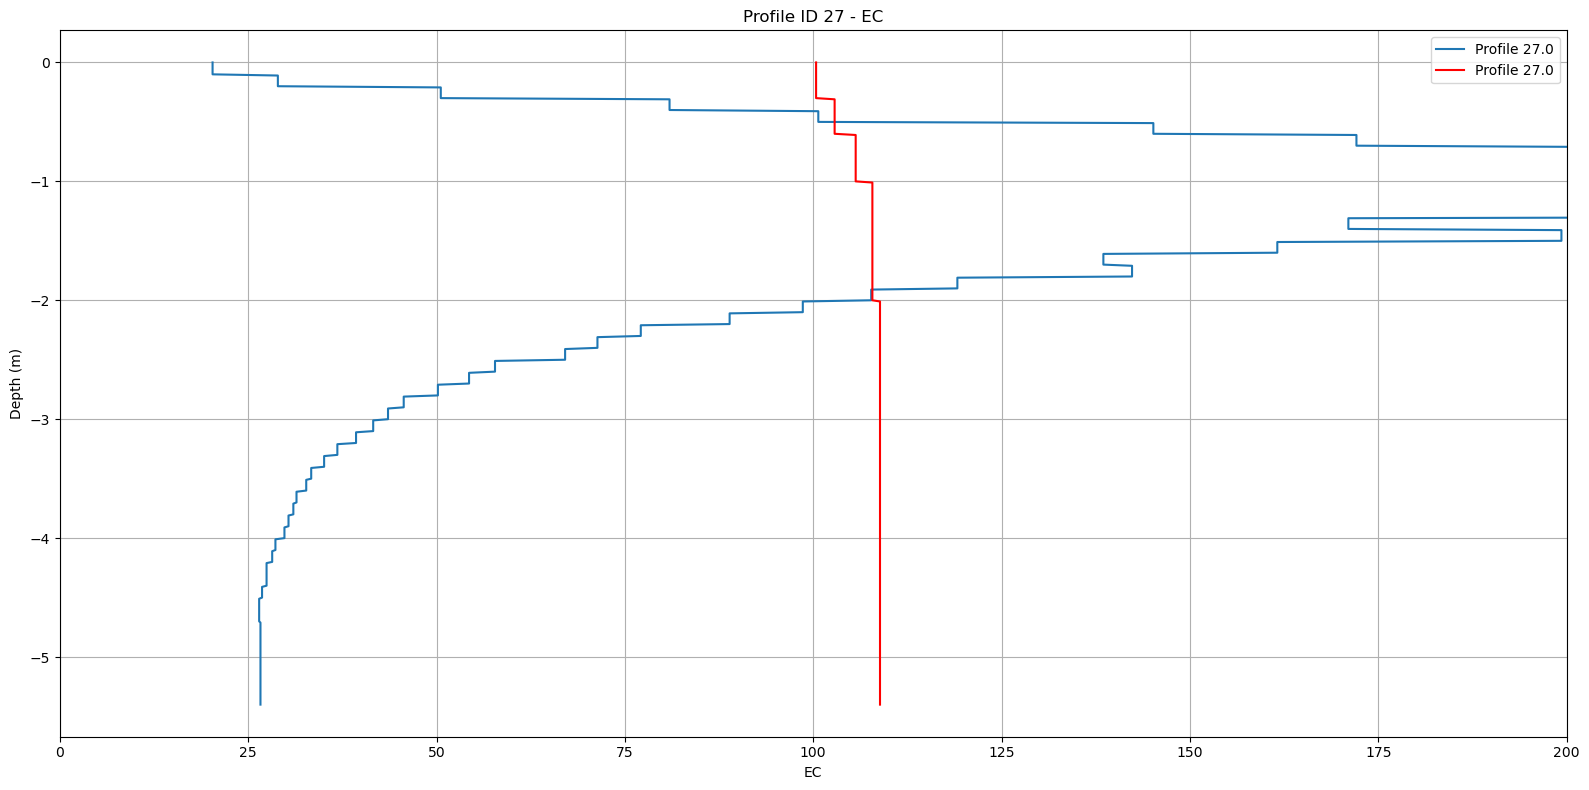

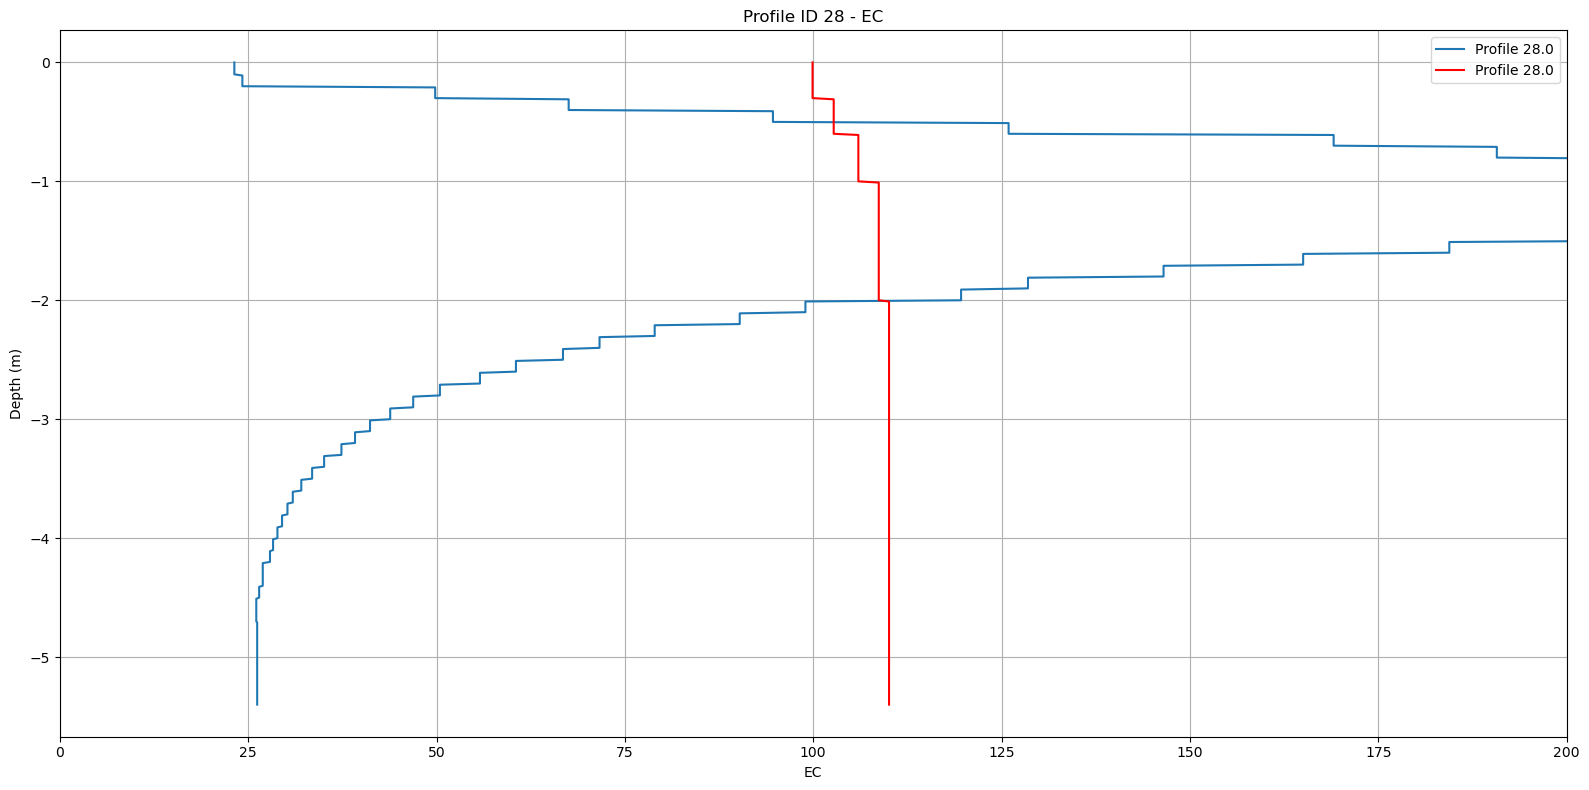

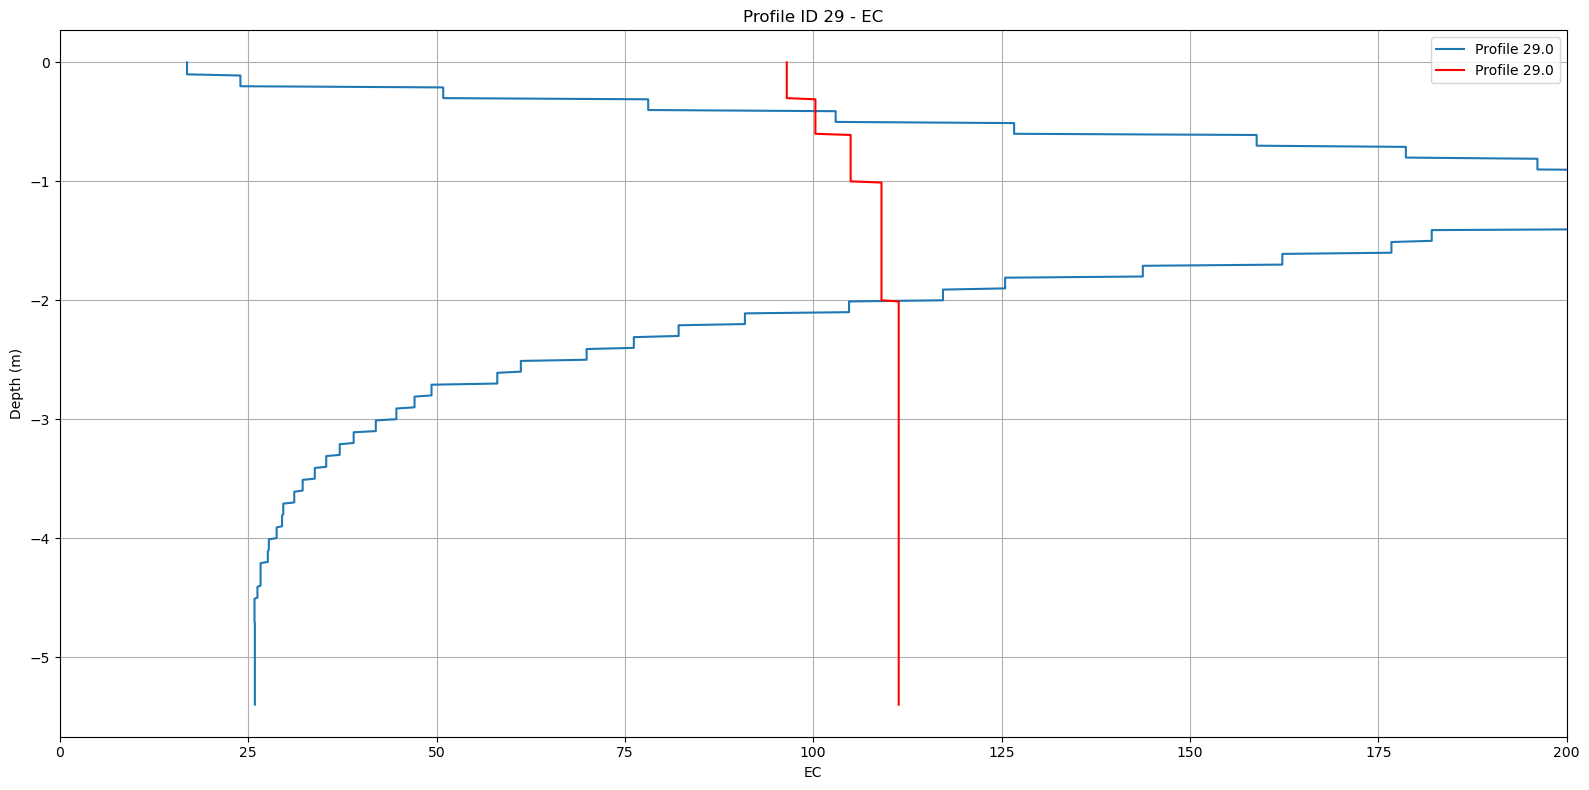

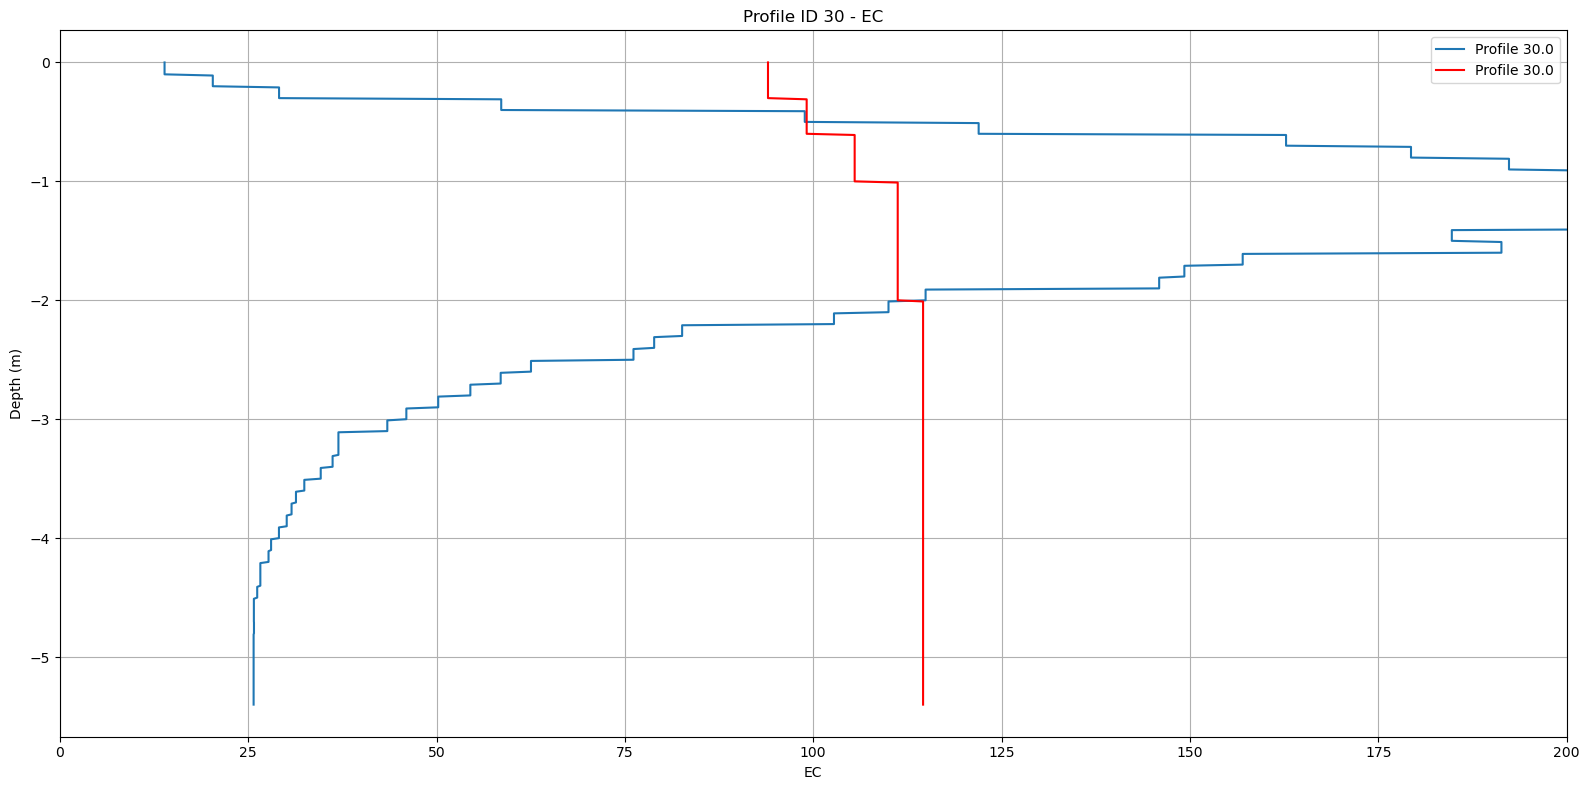

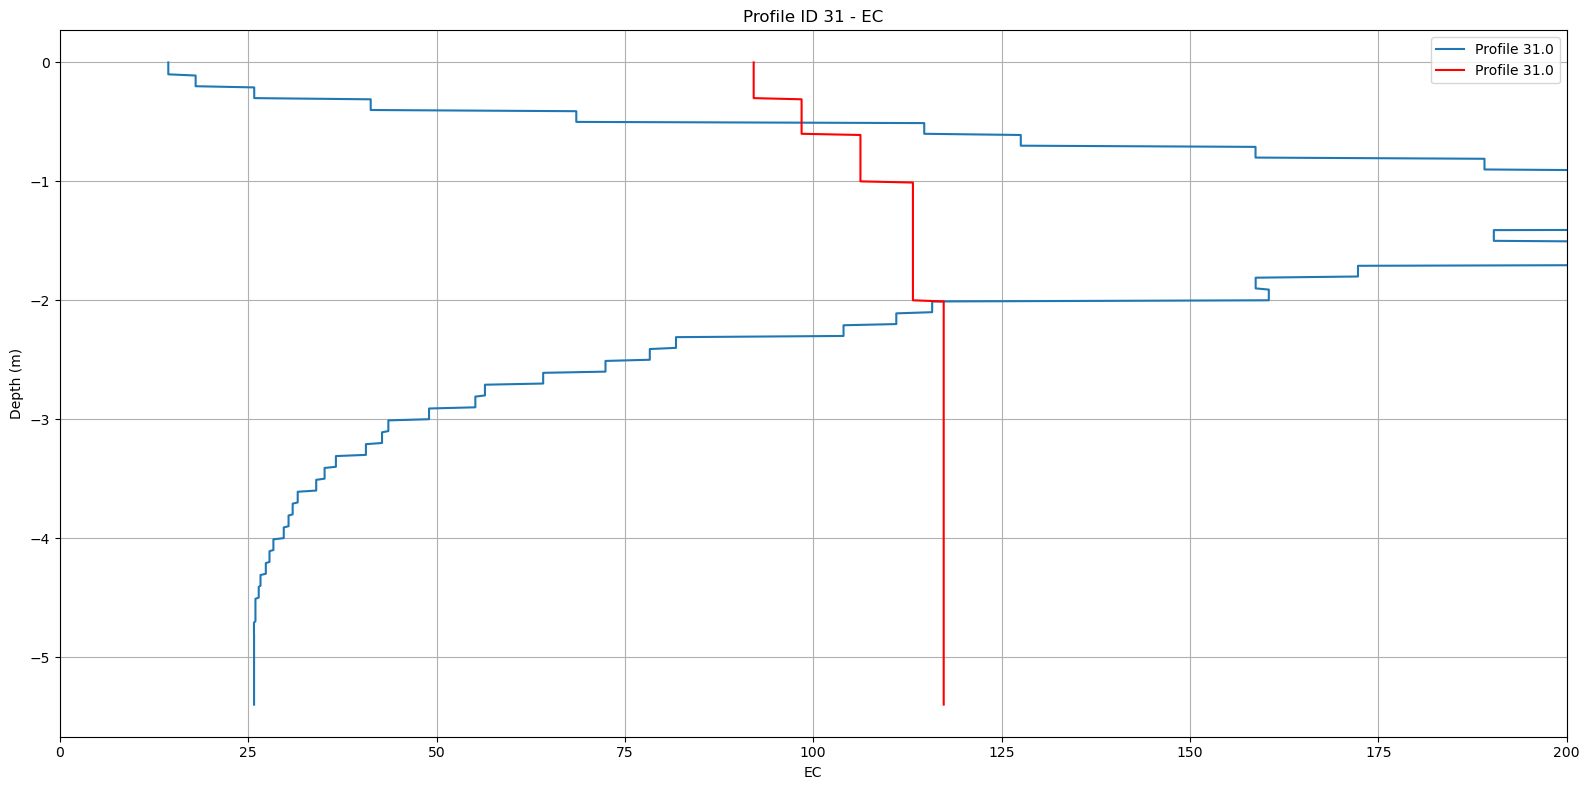

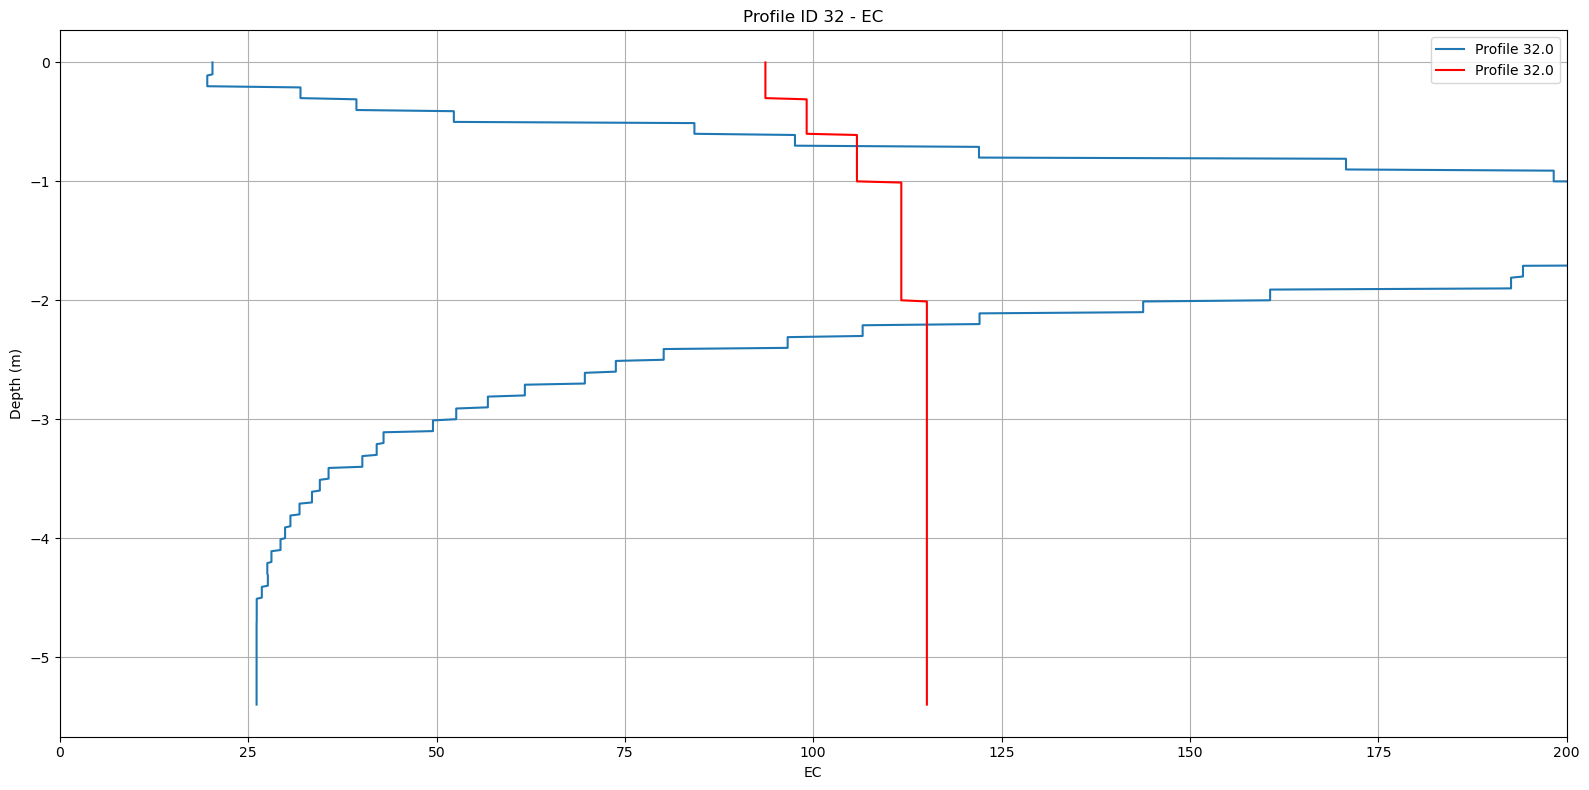

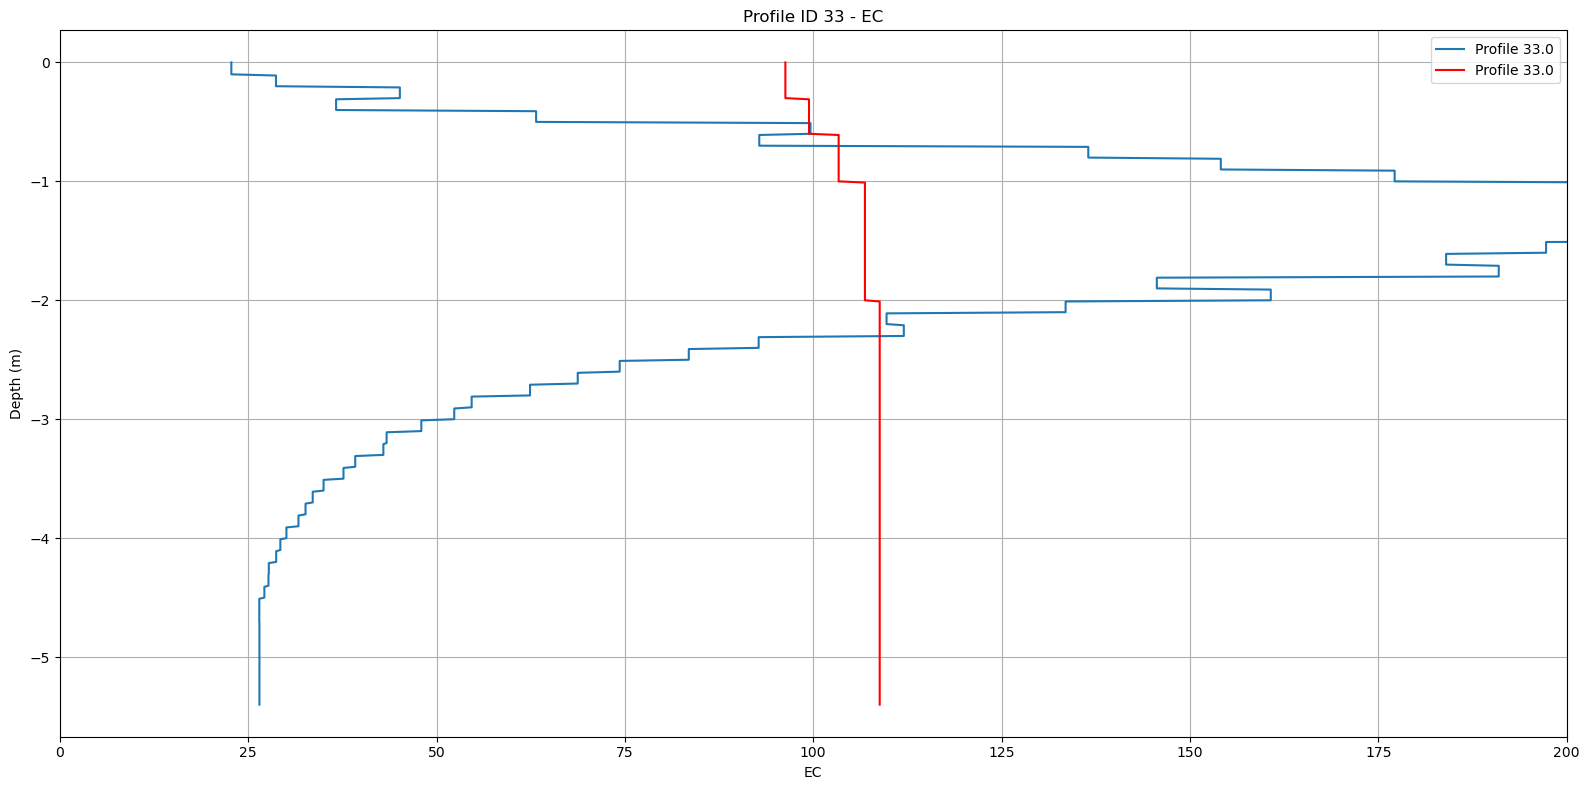

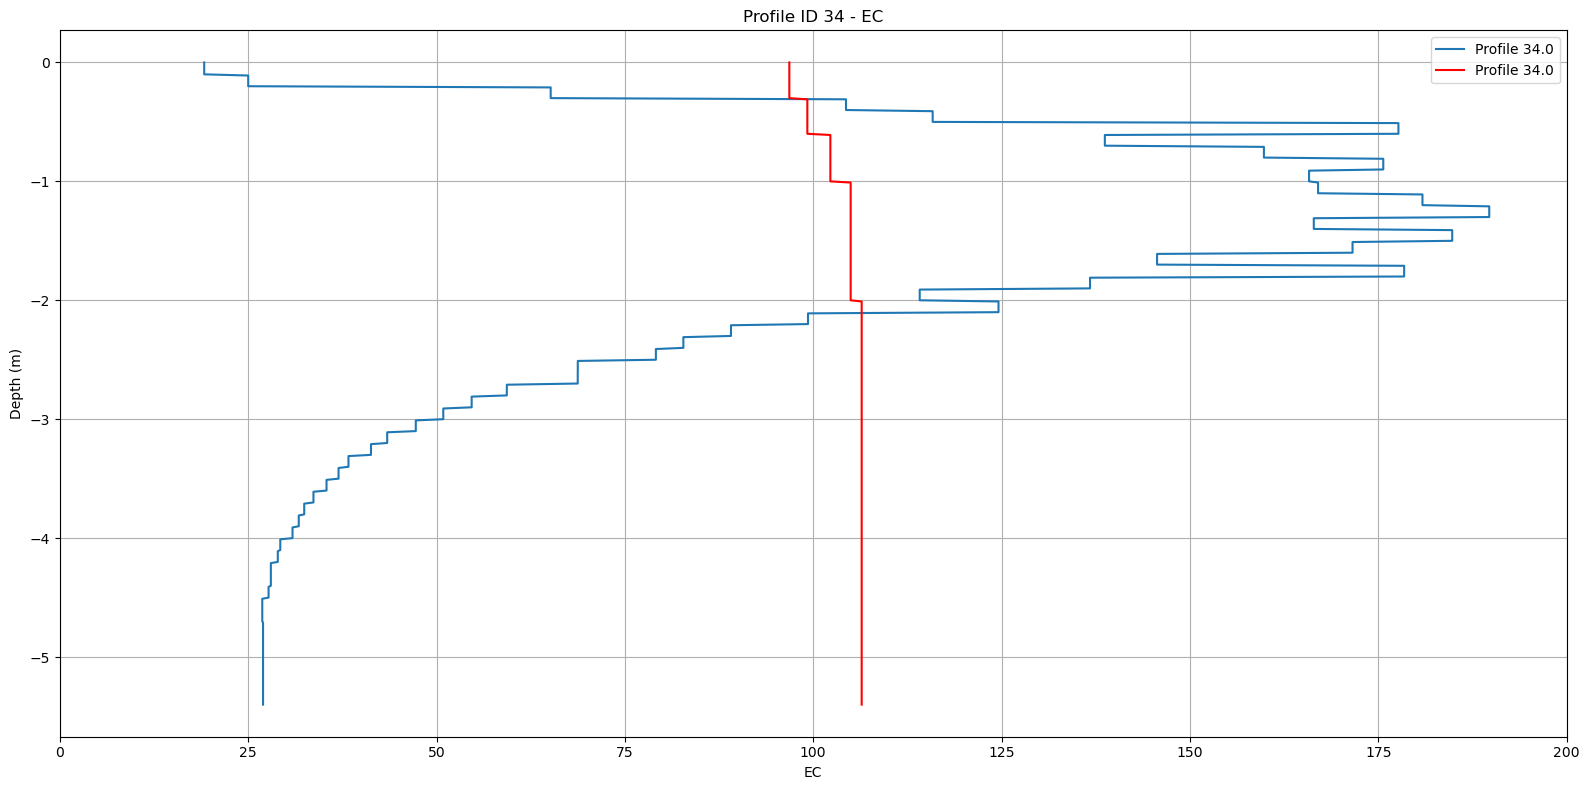

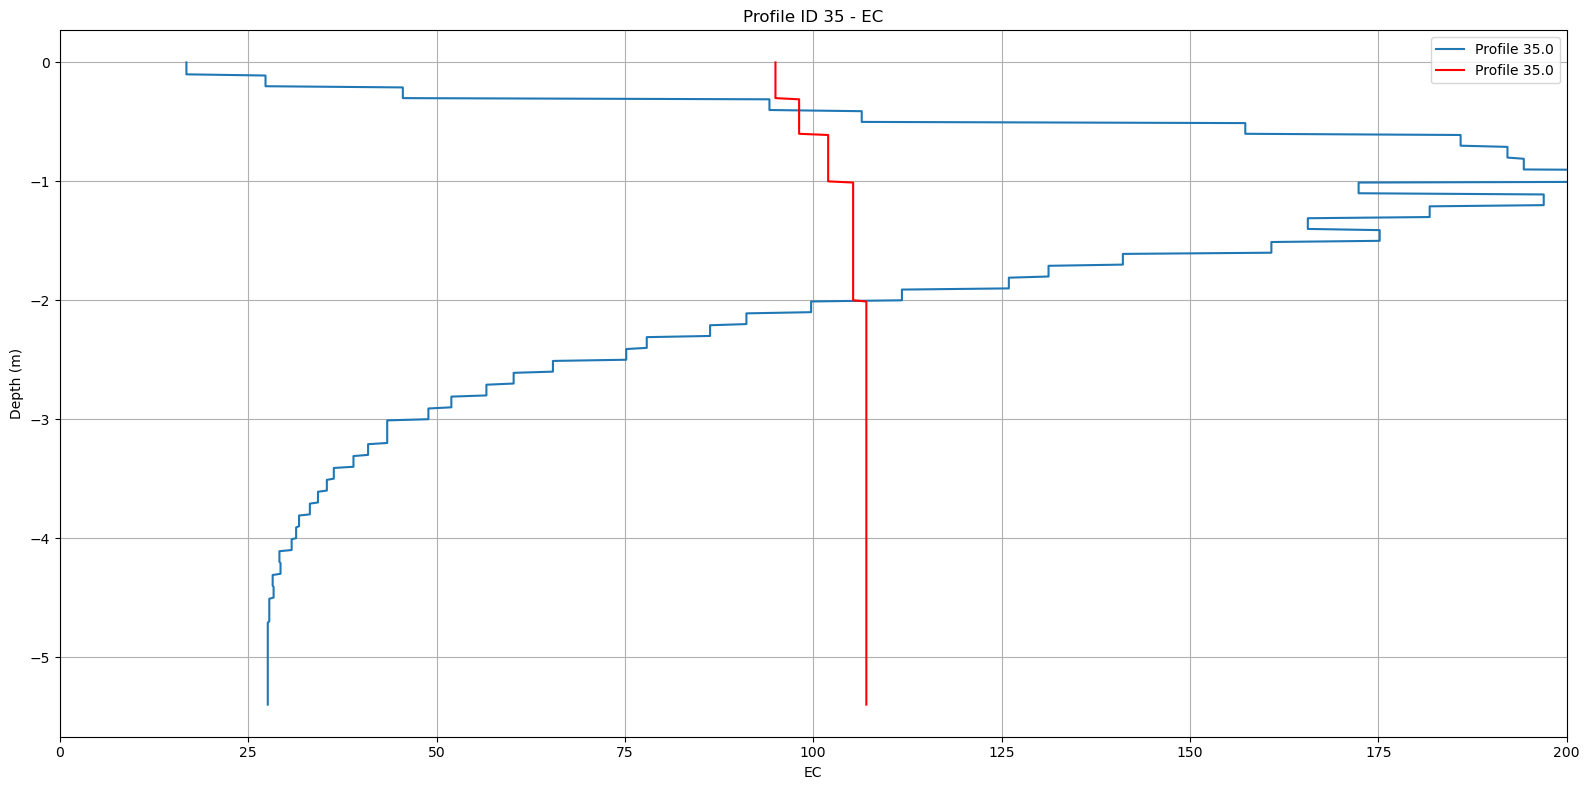

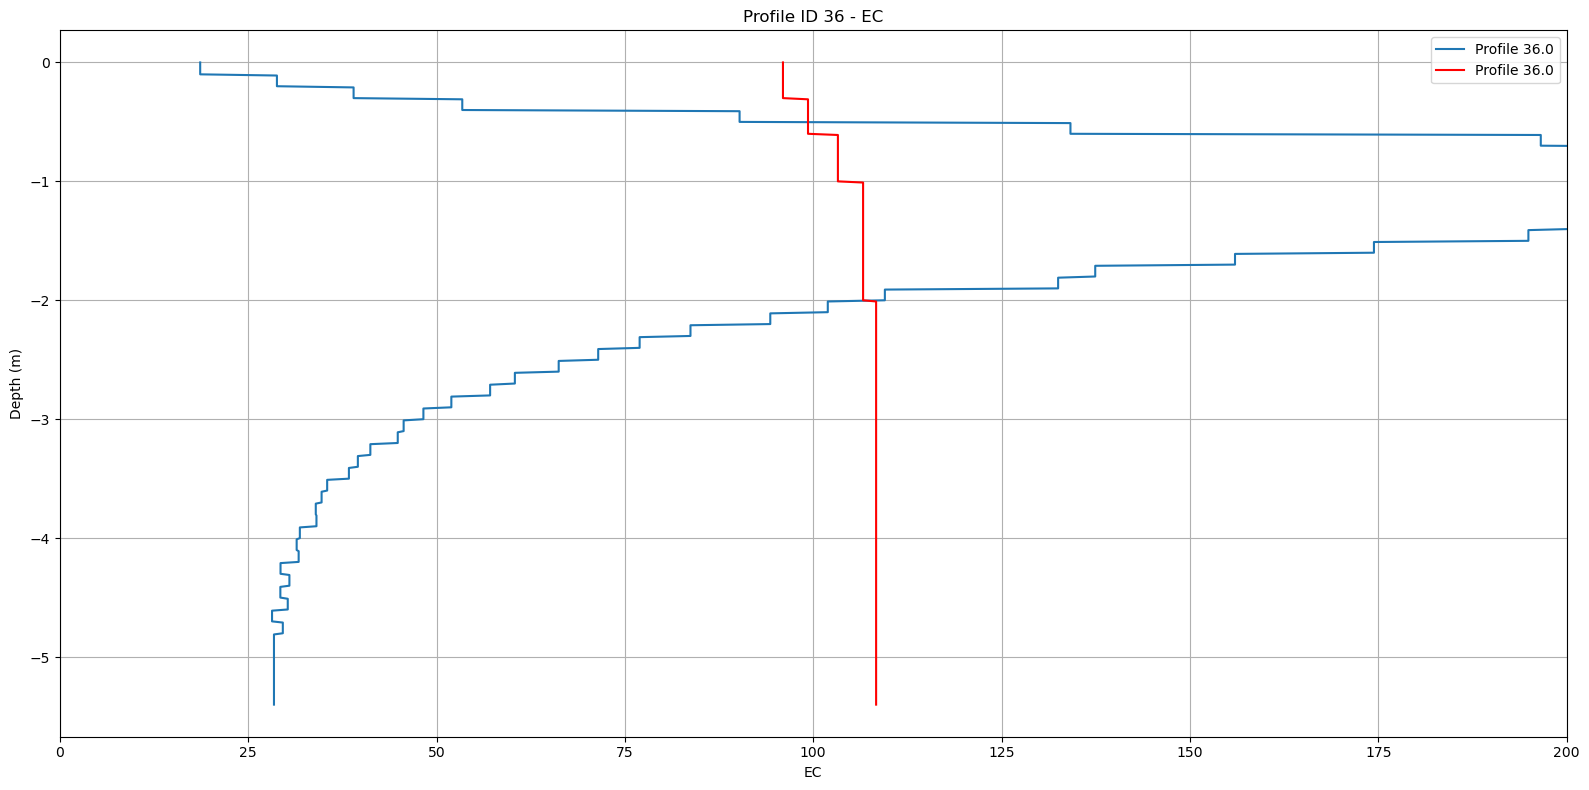

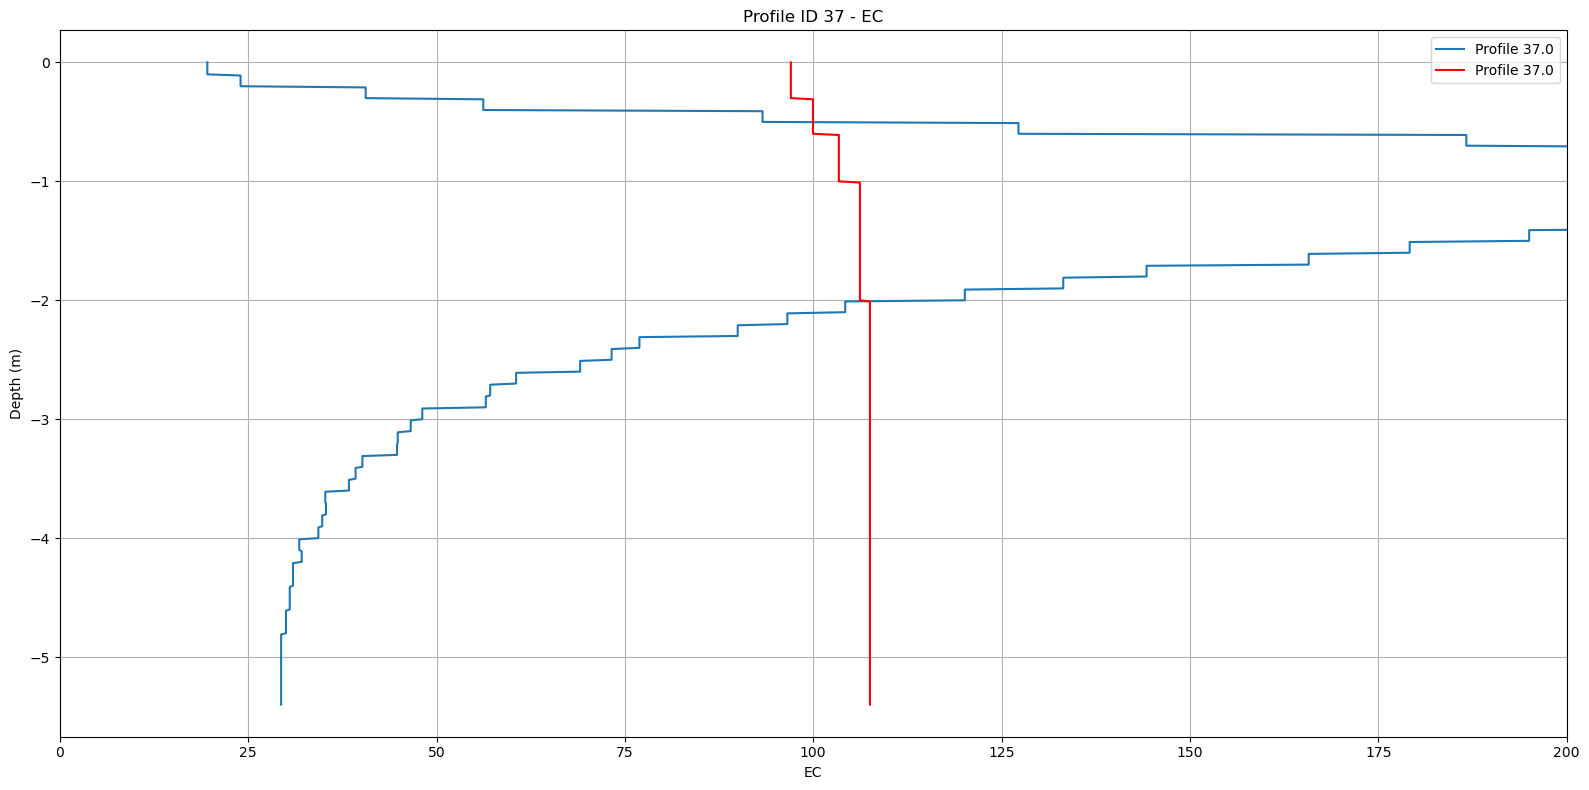

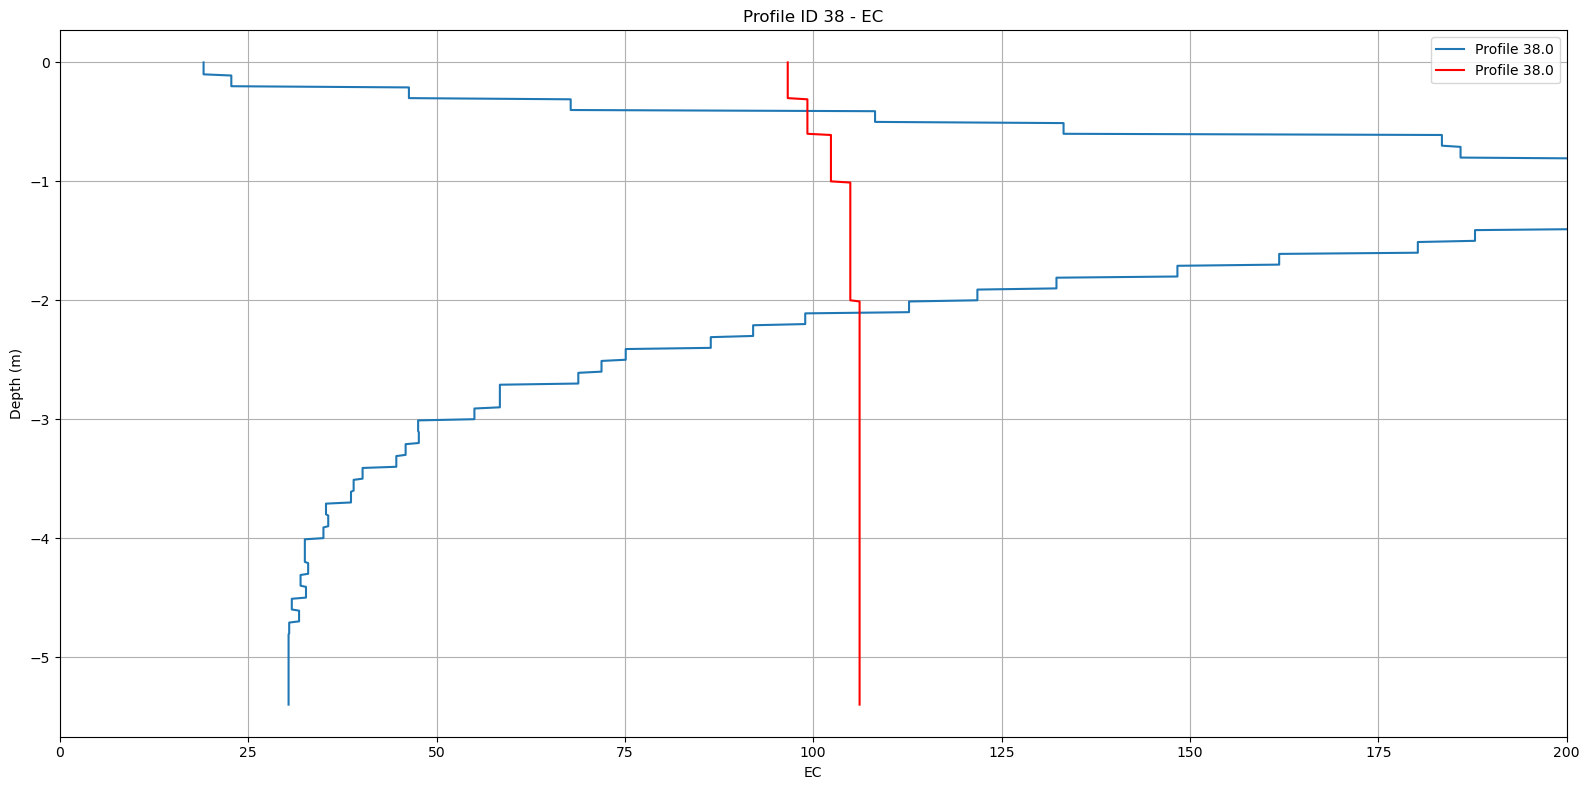

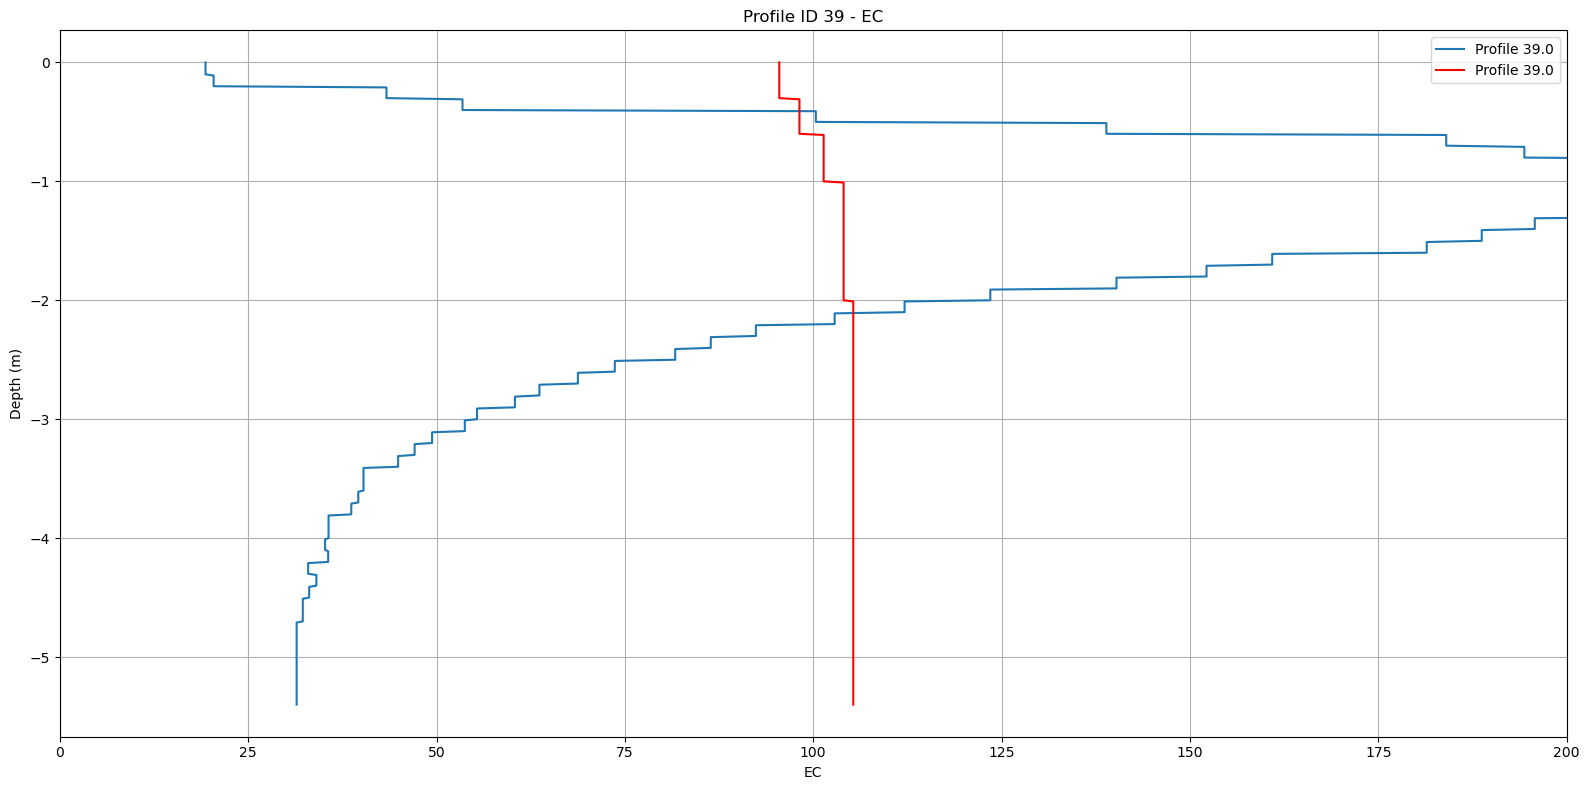

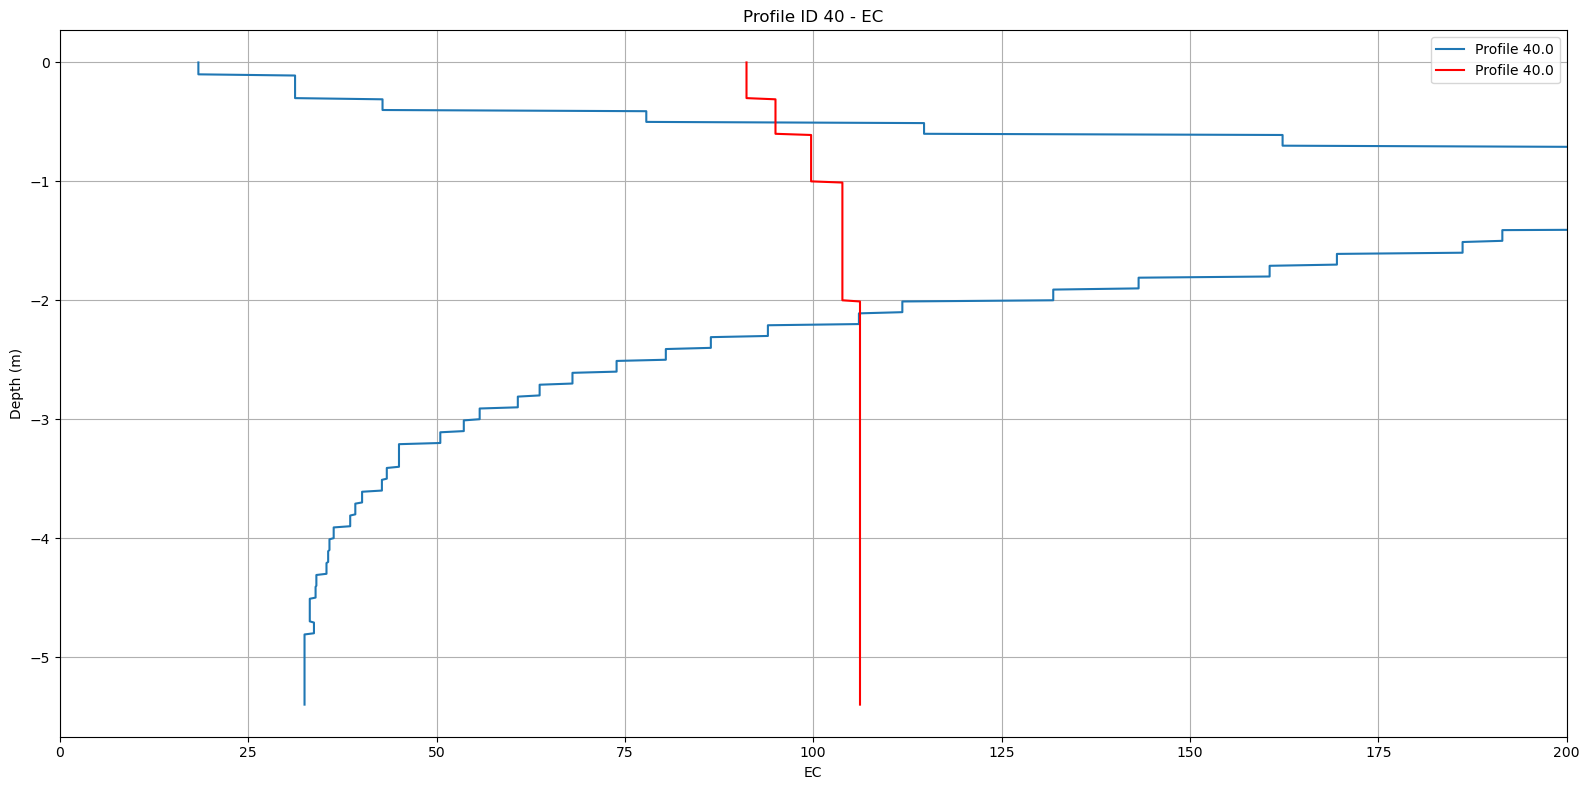

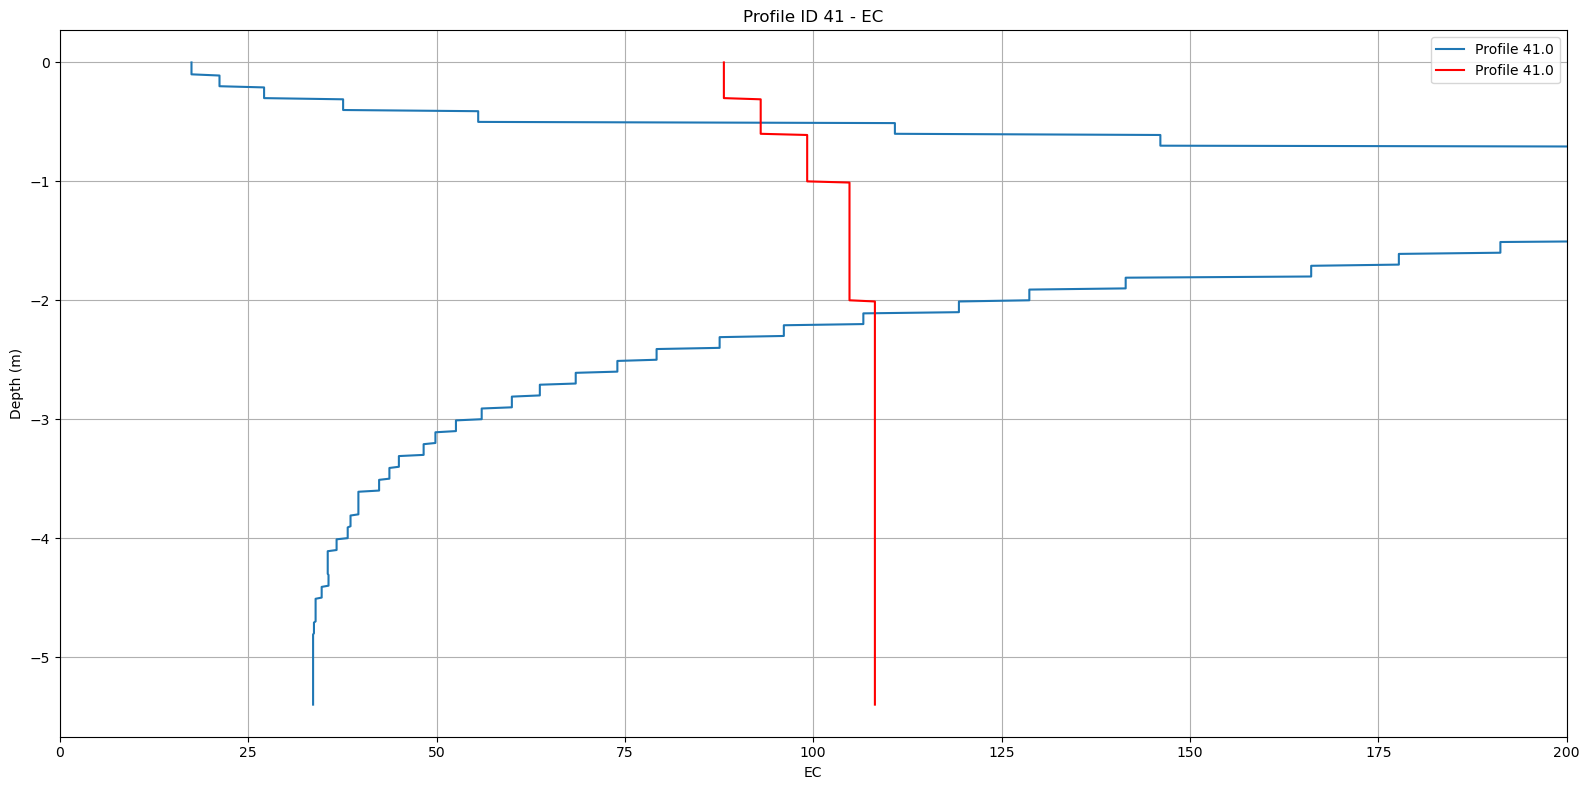

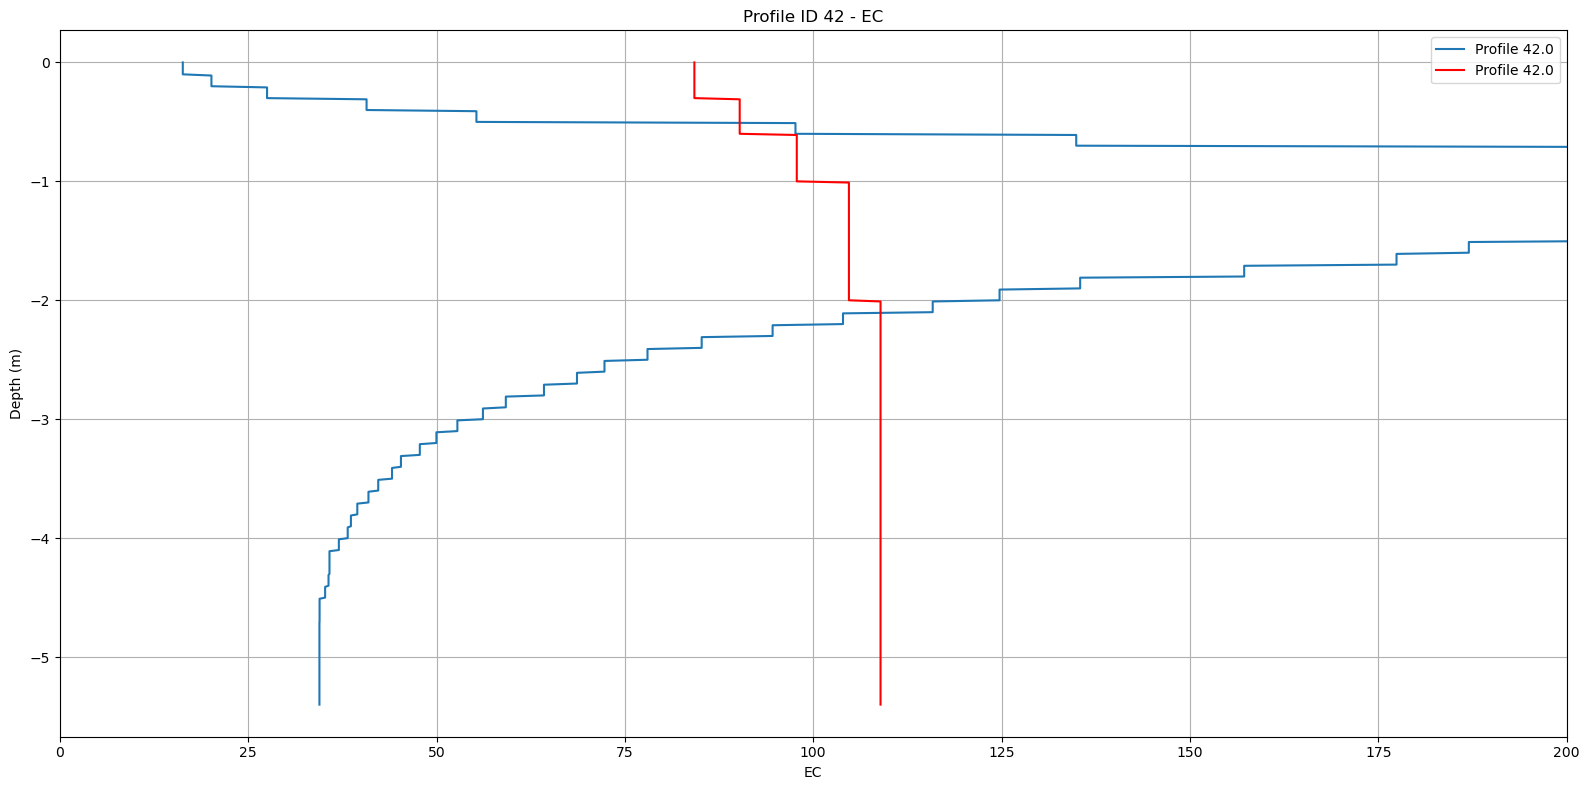

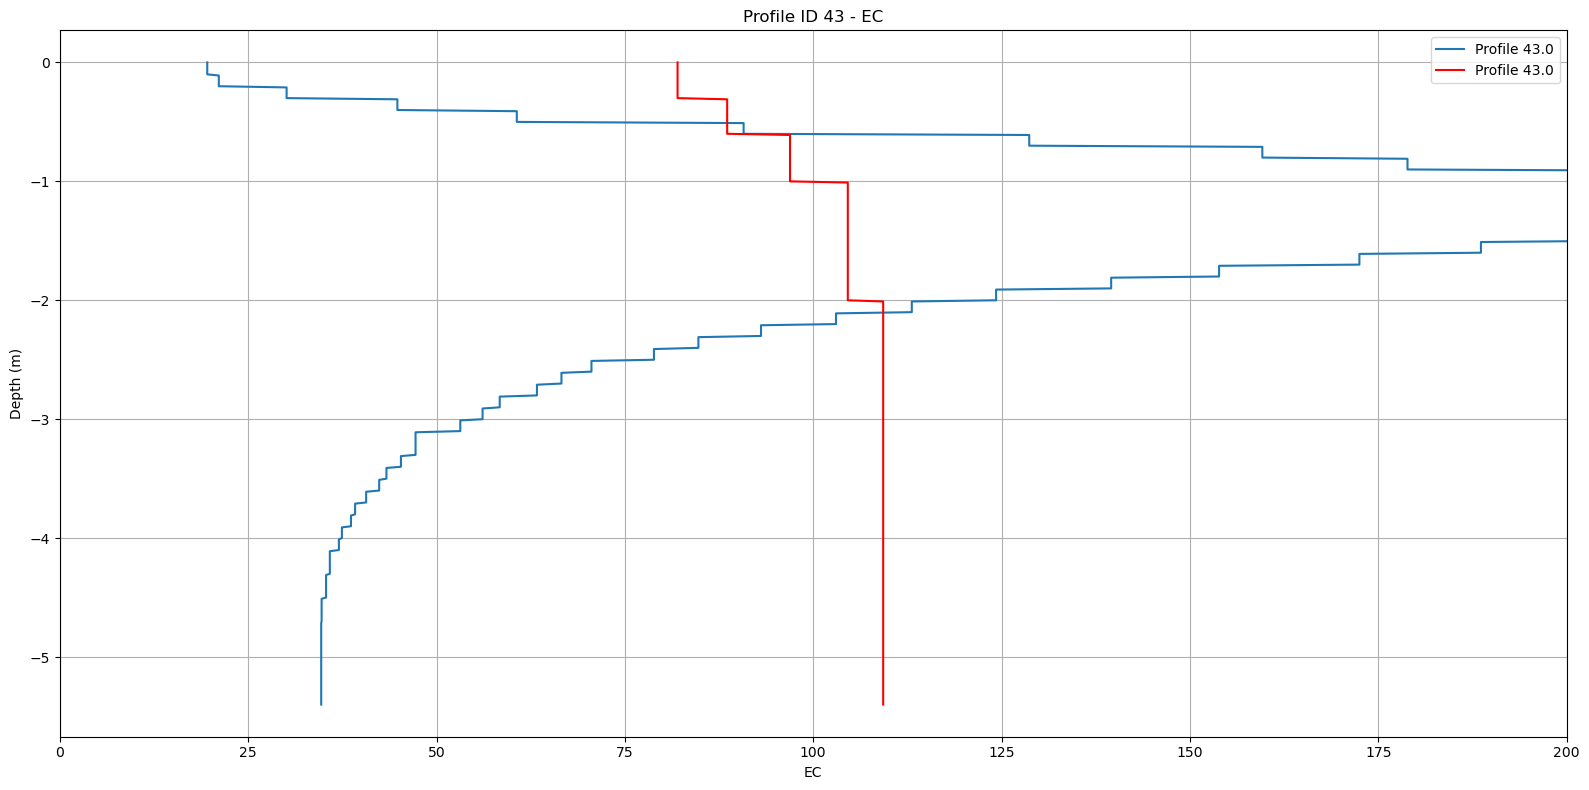

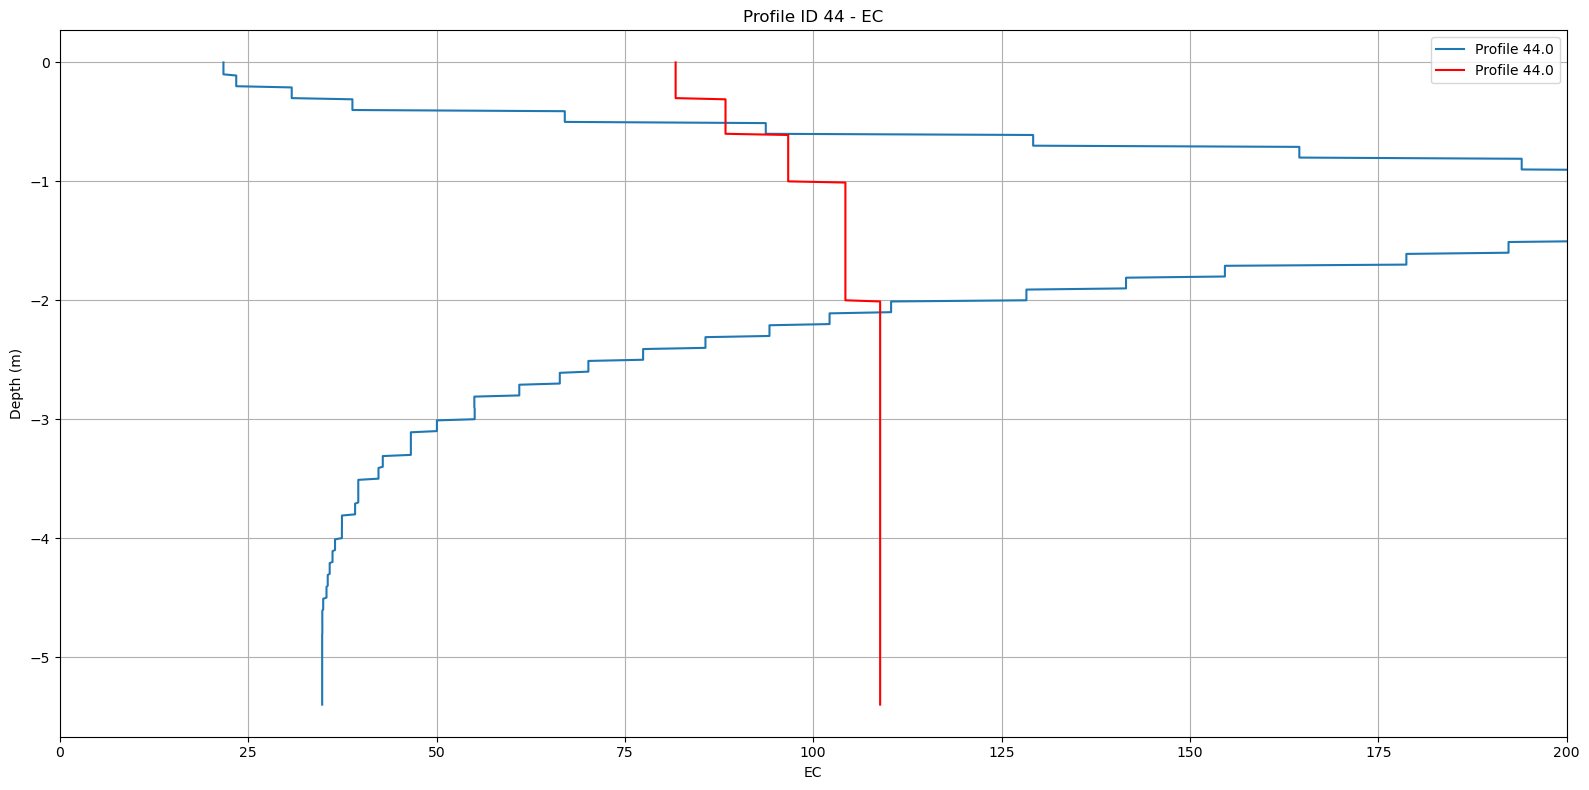

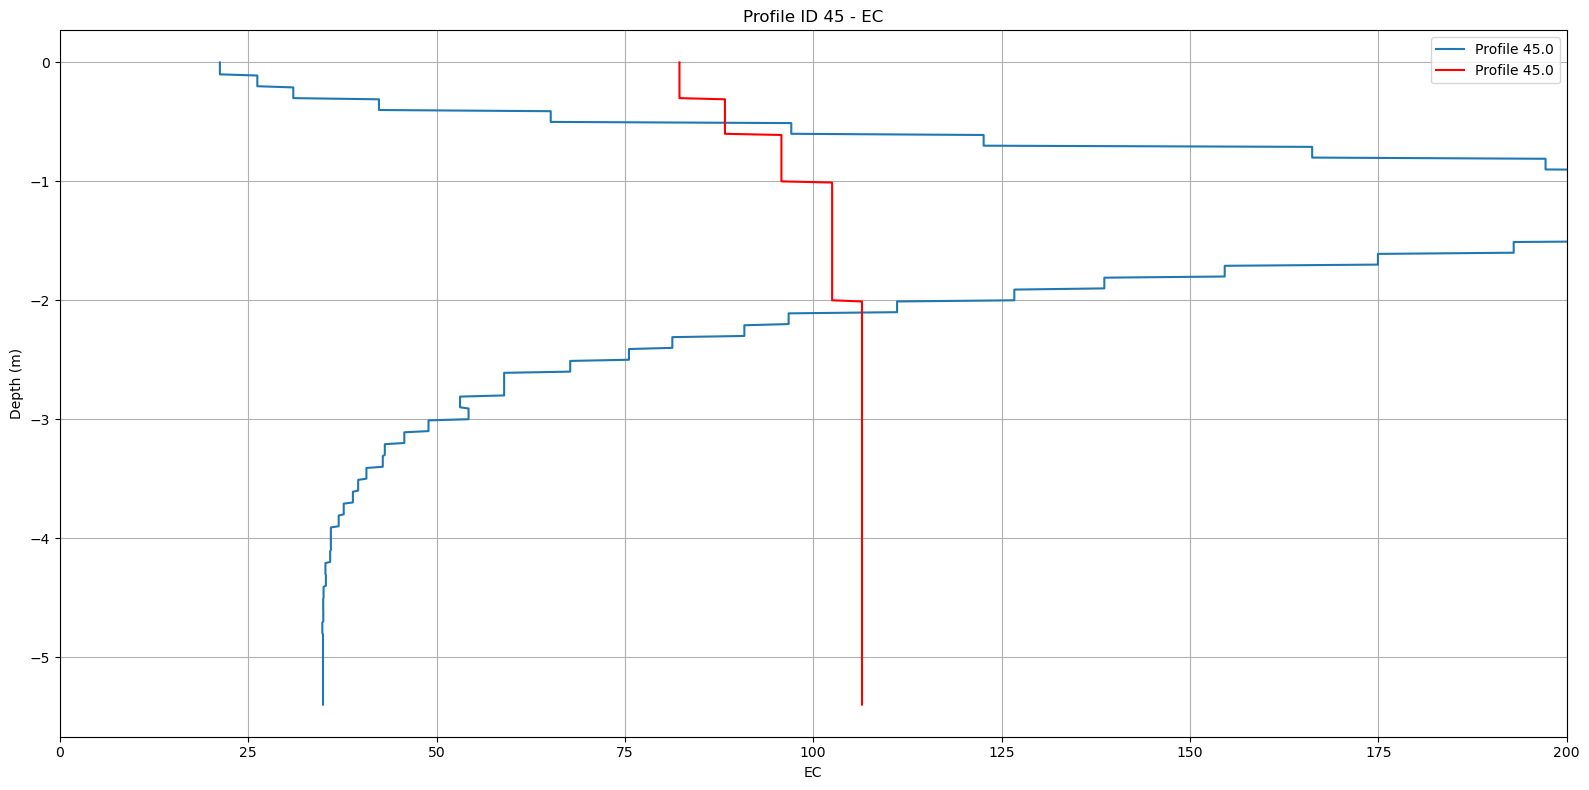

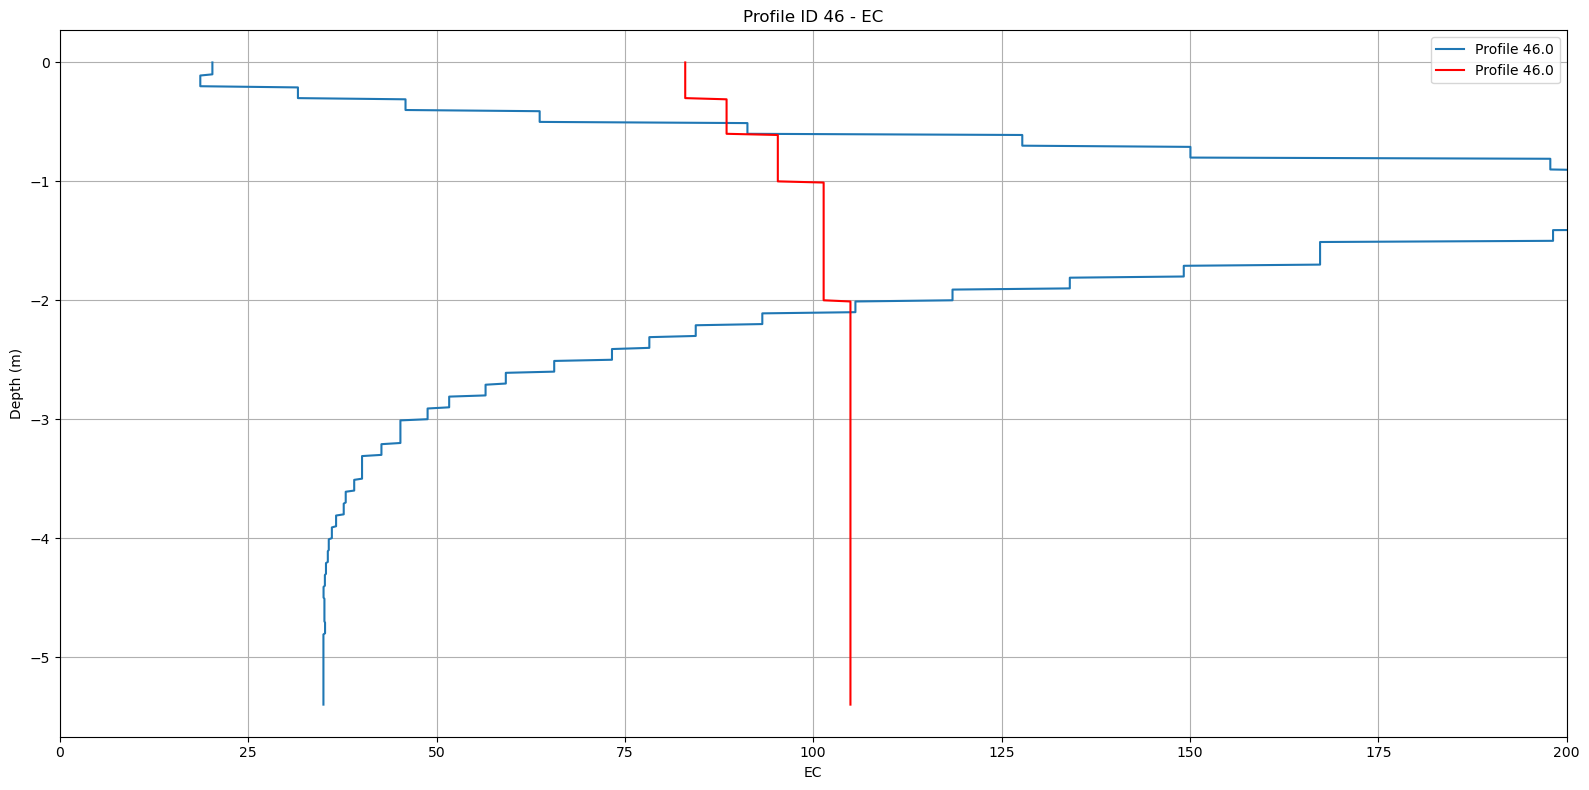

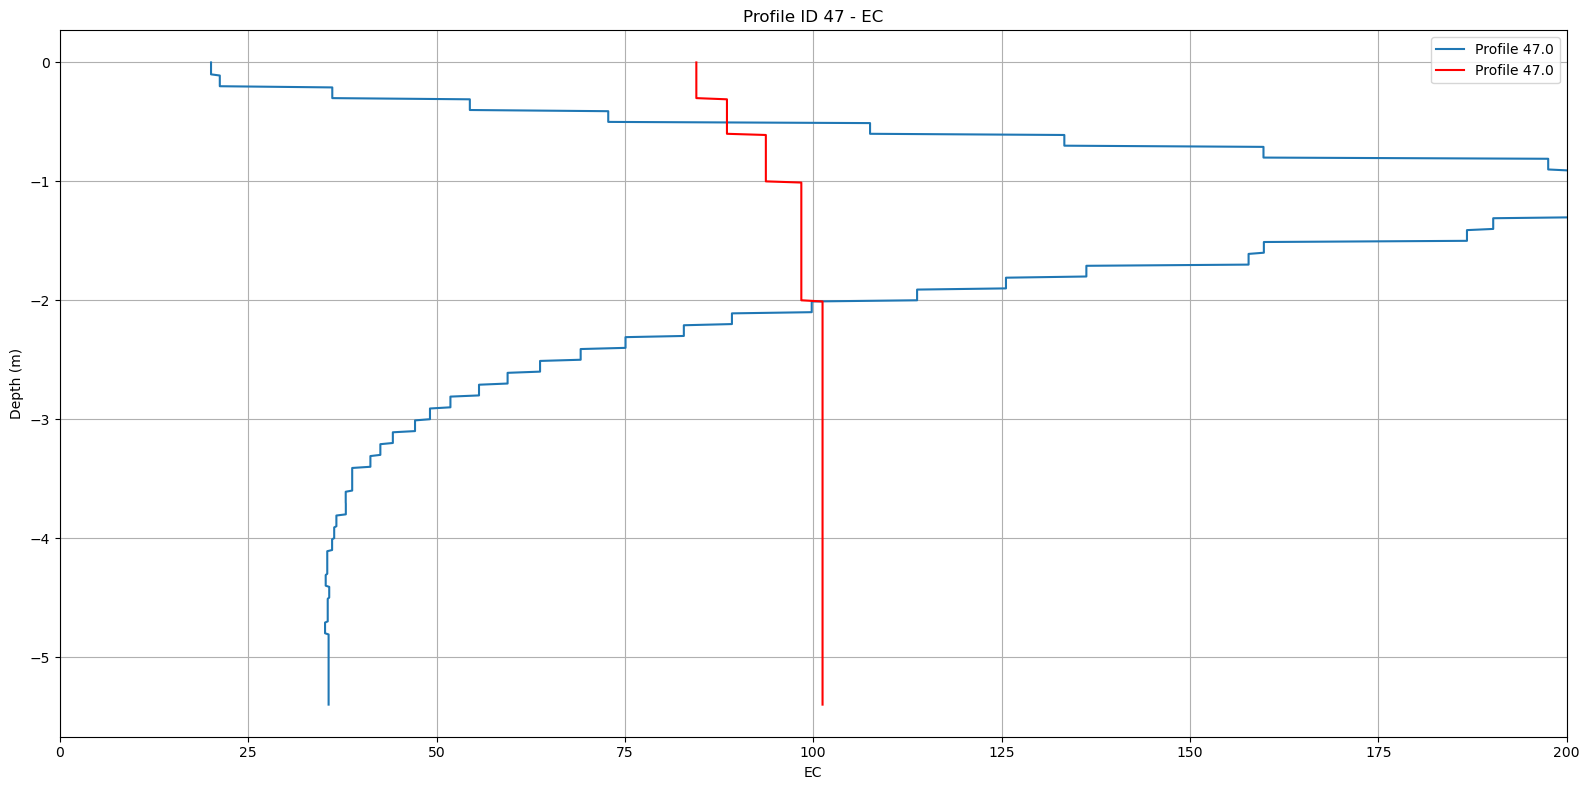

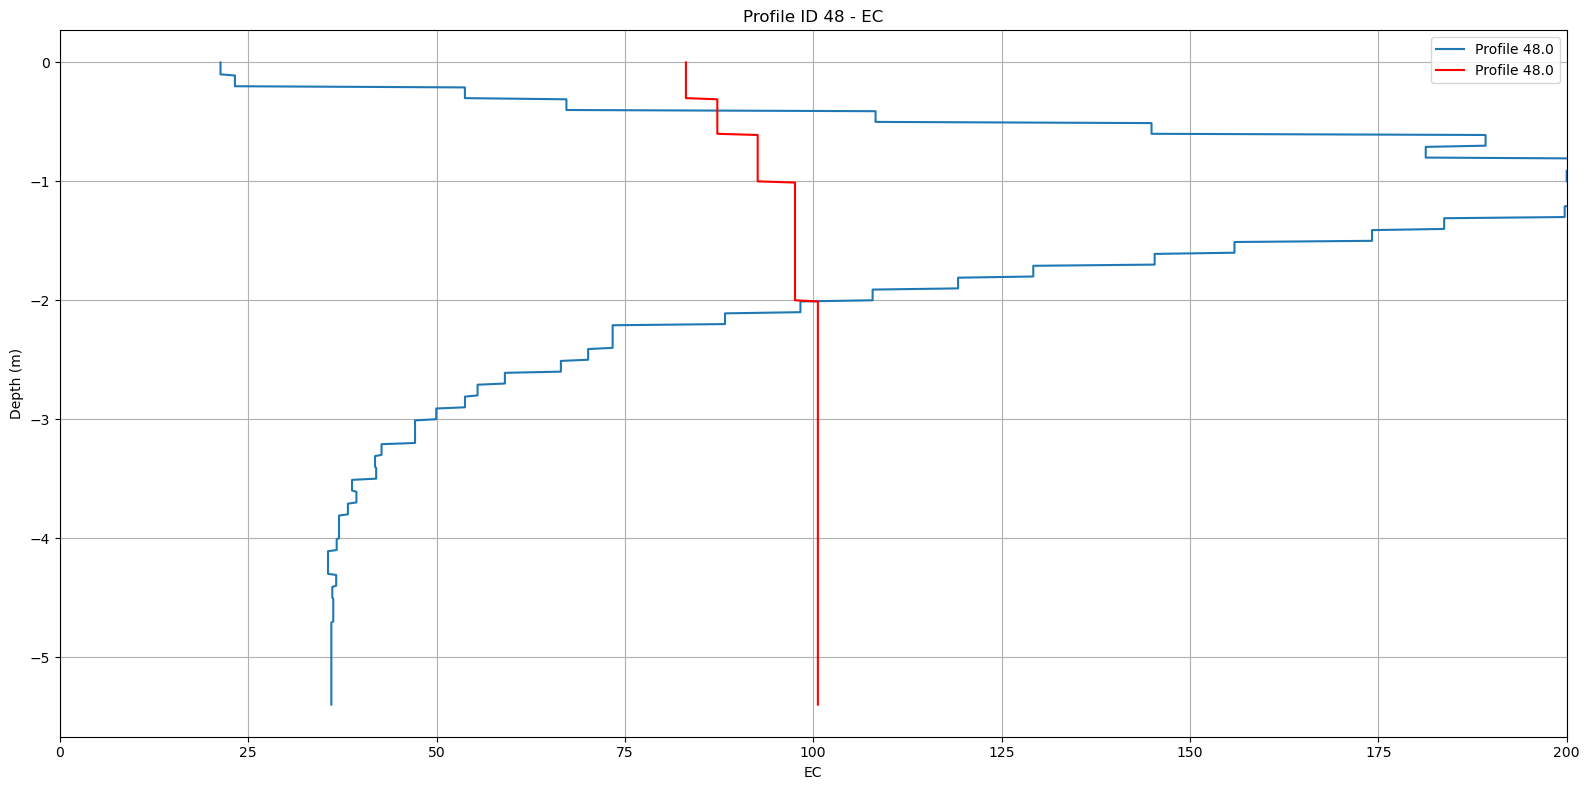

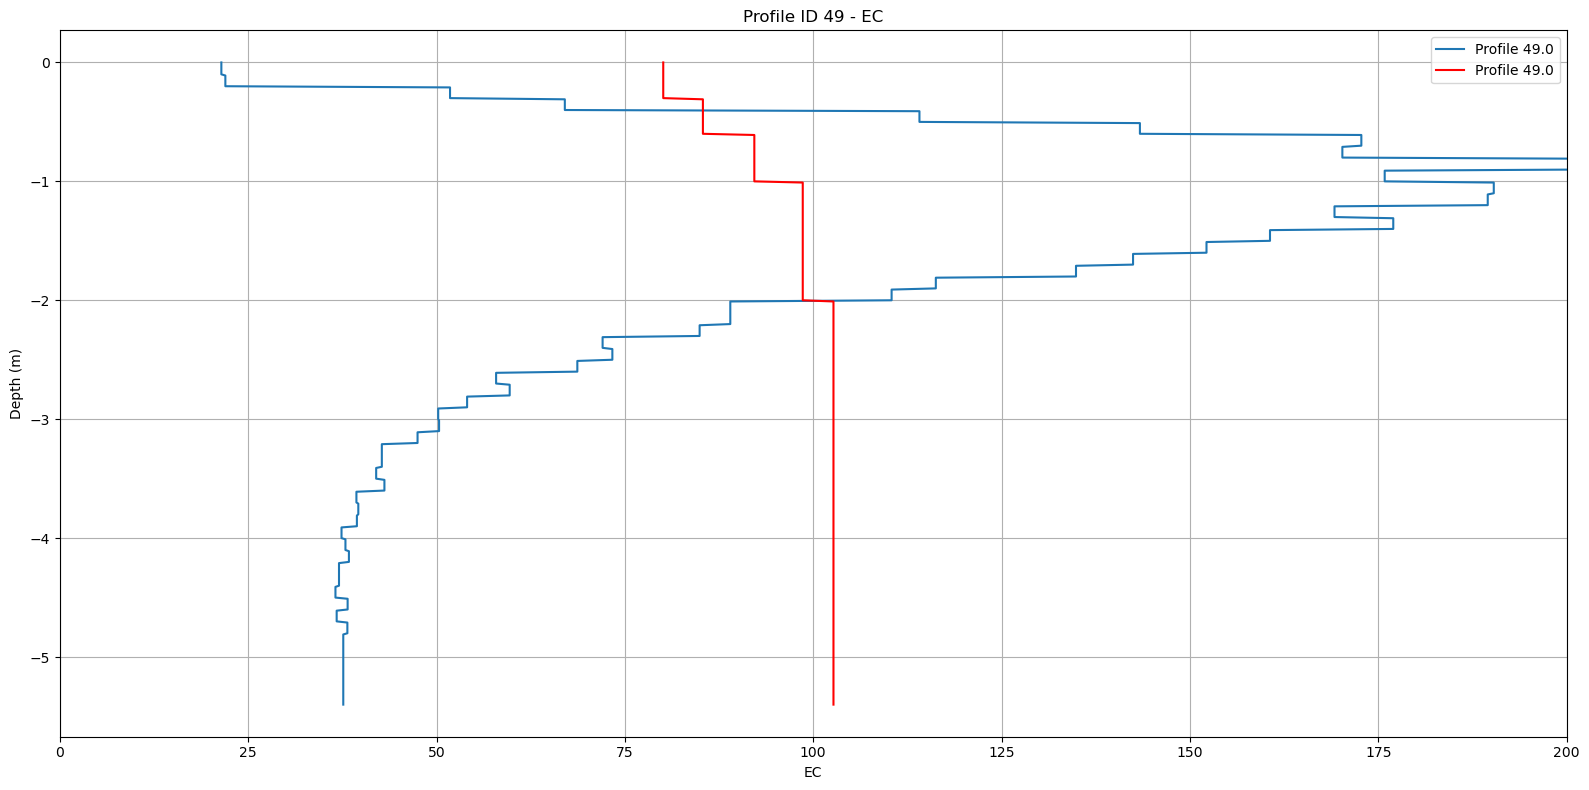

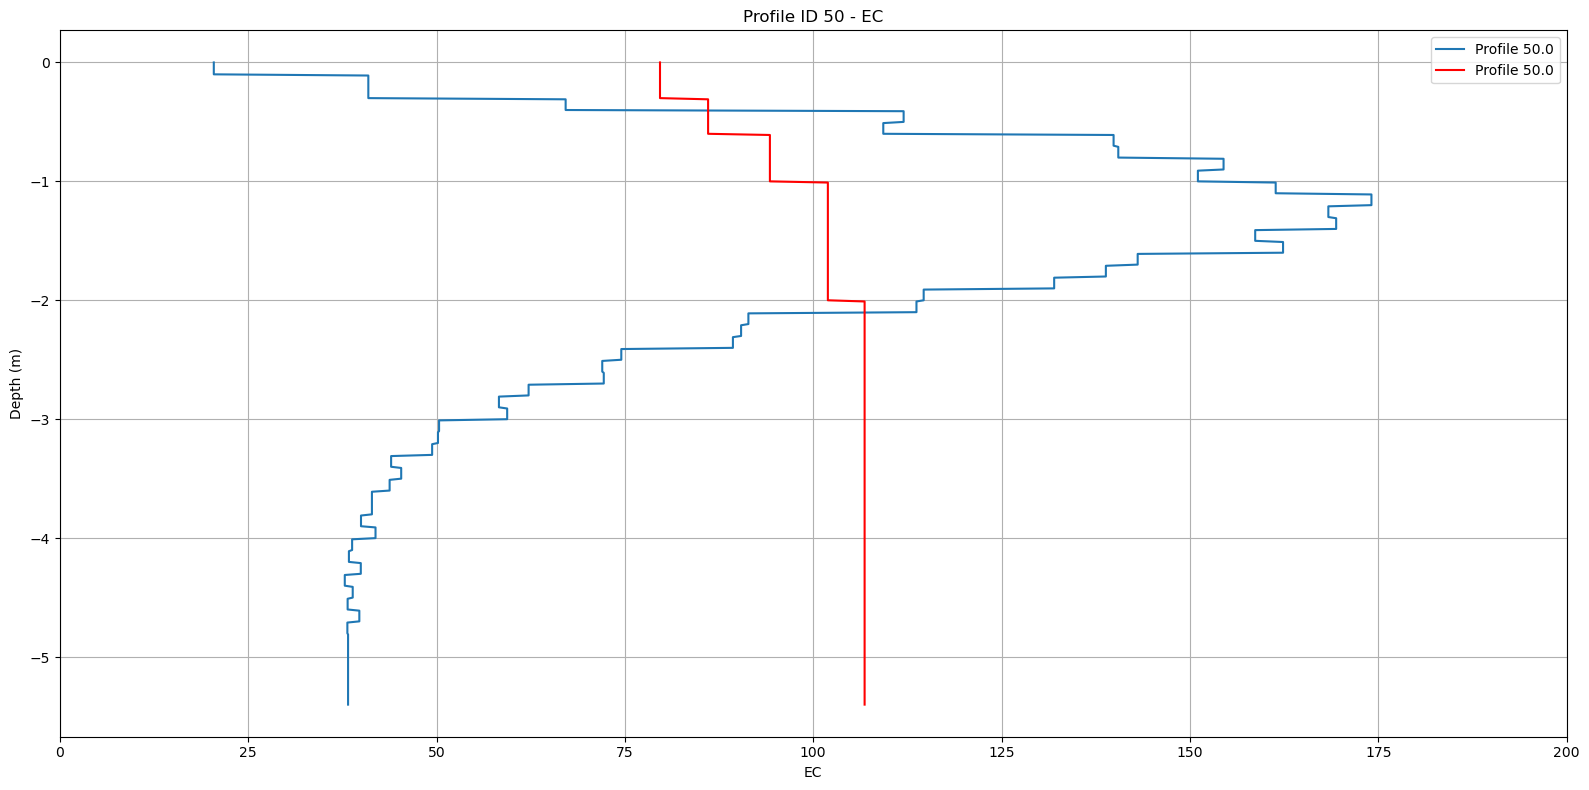

In [9]:
%autoreload

if not only_samples:
    # Function to extract depth from column name
    def extract_depth(col_name):
        if col_name.startswith('EC_'):
            return float(col_name.split('_')[1])
        return None

    # Extracting depth values and sorting them
    depth_cols = [col for col in dt_inv.columns if col.startswith('EC_')]
    depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
    depths.sort()

    # Calculate depth for 'EC_end'
    if depths:
        end_depth = depths[-1] + depths[0]
        depths.append(end_depth)

    # Creating the new DataFrame
    transformed_data = {
        'z': [],
        'EC': [],
        'easting': [],
        'northing': [],
        'ID': []
    }

    # Populating the new DataFrame
    for _, row in dt_inv.iterrows():
        for depth, depth_col in zip(depths, depth_cols):
            transformed_data['z'].append(-depth)
            transformed_data['EC'].append(row[depth_col])
            transformed_data['easting'].append(row['x'])
            transformed_data['northing'].append(row['y'])
            transformed_data['ID'].append(row['pos'])

    transformed_df = pd.DataFrame(transformed_data)

    pdf_files = []
    inv_meth = config['fs_emp']
    for i in transformed_df['ID'].unique():
        profile_label = str(i)
        if '.0' in profile_label:
            profile_label = profile_label.split('.')[0]
        filename = plot_profile(dc_corr, i, dataset_name,
                    compare=True, compare_df = transformed_df, compare_name = 'EC',
                    xlims=(0,200),
                    block=True,
                    save_plot = True, 
                    plot_name = f'{inv_meth}_inversion_p{profile_label}'
                    ) # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):
        
        pdf_files.append(filename)

    # Merge and save PDFs
    merger = PdfMerger()
    for pdf in pdf_files:
        merger.append(pdf)
    merged_pdf_filename = f'{now}_{emfile_prefix}_{inv_meth}_transect.pdf'
    outfile_transect_pdf = os.path.join(inv_folder, merged_pdf_filename)
    merger.write(outfile_transect_pdf)
    merger.close()
    for pdf in pdf_files:
        os.remove(pdf)
    clear_output(wait=False)

In [10]:
pd.set_option('display.max_columns', None)

# Perform inversion on sampling locations (to be used in pedophysical modelling)

if 'code' in em_samples.columns:
    em_samples = em_samples.rename(columns={'code': 'ID'})

# if config['n_omit'] != 0:
#     unique_ids = em_input['ID'].unique()
#     print(unique_ids)
#     selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
#     em_input = em_input.loc[em_input['ID'].isin(selected_ids)]

temp_dir = 'temp_emp' 
infile_name = 'infile.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
n = 4
em_samples.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_samples.columns.values[n:n+i] = new_columns

em_samples.to_csv(temp_file)

# transect inversion settings
print('em_samples', em_samples.head())

s_rec = Problem()
s_rec.createSurvey(temp_file)
#t_rec.rollingMean(window=12)

s_rec.setInit(
    depths0=np.flipud(mod_layers),
    conds0=conductivities
    # fixedDepths=startmodel['fixedDepths'],
    # fixedConds=startmodel['fixedConds']
    )
#print(np.flipud(mod_layers), conductivities)

shutil.rmtree(temp_dir)

if config['remove_coil']:
    if type(config['coil_n']) == list:
        config['coil_n'] = sorted(config['coil_n'])
        for i in enumerate(config['coil_n']):
            r_coil = s_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
            s_rec.removeCoil(config['coil_n'][i[0]]-i[0])
    else:
        s_rec.removeCoil(config['coil_n'])

print(f'Data used for inversion: {s_rec.coils}')

em_samples                    x              y          z         t  HCP0.5f90000.165  \
5166   107720.117738  183326.959903  26.190915  40954.67         52.187318   
19244  107755.589191  183331.100490  26.895158  42473.18         16.512444   
22350  107797.401545  183278.578992  28.470657  42812.37         90.708144   
19352  107763.815598  183318.112287  27.344669  42491.37          8.642003   
1556   107723.005061  183309.181769  26.586000  40592.63         66.431144   

       PRP0.6f9000h0.165  HCP1.0f9000h0.165  PRP1.1f9000h0.165  \
5166           49.052734          51.618105          63.832856   
19244          18.074690          21.883807          24.230130   
22350          57.723088         119.370212          83.447332   
19352          14.845471           9.100944          17.492703   
1556           58.135345          64.488759          74.754468   

       HCP2.0f9000h0.165  PRP2.1f9000h0.165  HCP0.5f9000h0.165_inph  \
5166           35.850098          55.752786         

Inversion using FSeq with Gauss-Newton, reg=l2, alpha=0.5
15/15 inverted

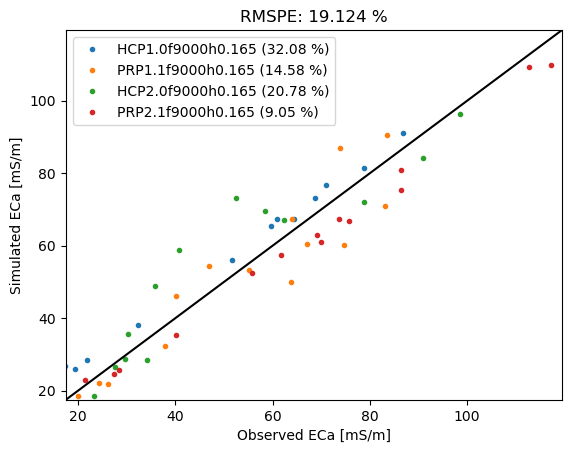

In [11]:
# invert using ROPE solver (RObust Parameter Estimation)
warnings.filterwarnings('ignore')
opt_meth = config['opt_method']
inv_meth = config['fs_emp']
reg_meth = config['regularization']
alph_param = config['alpha']
if opt_meth in ['MCMC', 'ROPE']:
    if config['constrain']:

        print(type(s_rec), s_rec, 's_rec')

        print(type(bounds), bounds, 'bounds')
        print(type(reg_meth), reg_meth, 'reg_meth')
        print(type(alph_param), alph_param, 'alph_param')
    
        print(f'Constrained inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        s_rec.invert(forwardModel=config['fs_emp'], method=opt_meth, 
                regularization=reg_meth, alpha=alph_param, 
                bnds=bounds
                )
    else:
        print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        s_rec.invert(forwardModel=config['fs_emp'], method=opt_meth, 
        regularization=reg_meth, alpha=alph_param, njobs=-1
        )

else:
    print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
    s_rec.invert(forwardModel='FSeq', method='Gauss-Newton', alpha=alph_param,regularization=reg_meth)
s_rec.showOne2one()

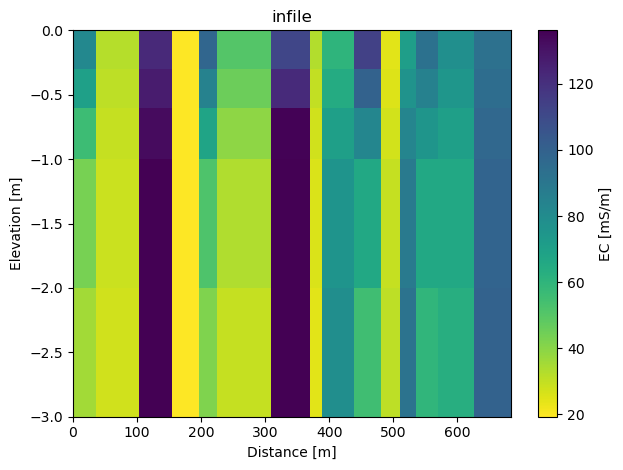

In [12]:
# 4.1: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------
csv_filename = f'{now}_{emfile_prefix}_inverted_samples_{opt_meth}.csv'

# ******************************************************************** #

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).
s_rec.showResults(dist=True, errorbar = True) 

# Extracting the values from the first row of the transect.depths[0] array
depth_values = s_rec.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[s_rec.surveys[0].df[['x', 'y']].values, s_rec.models[0]]

# Creating the final dataframe with the desired column names
ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
ds_inv['pos'] = em_samples['ID'].to_numpy()
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
outfile_transect = os.path.join(inv_folder, csv_filename)
ds_inv.to_csv(outfile_transect)

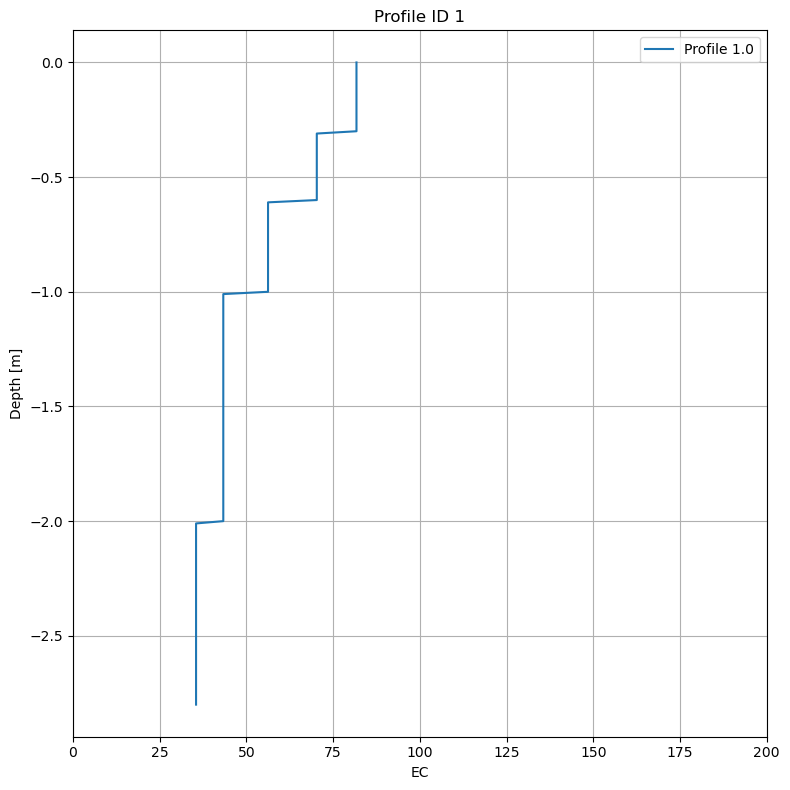

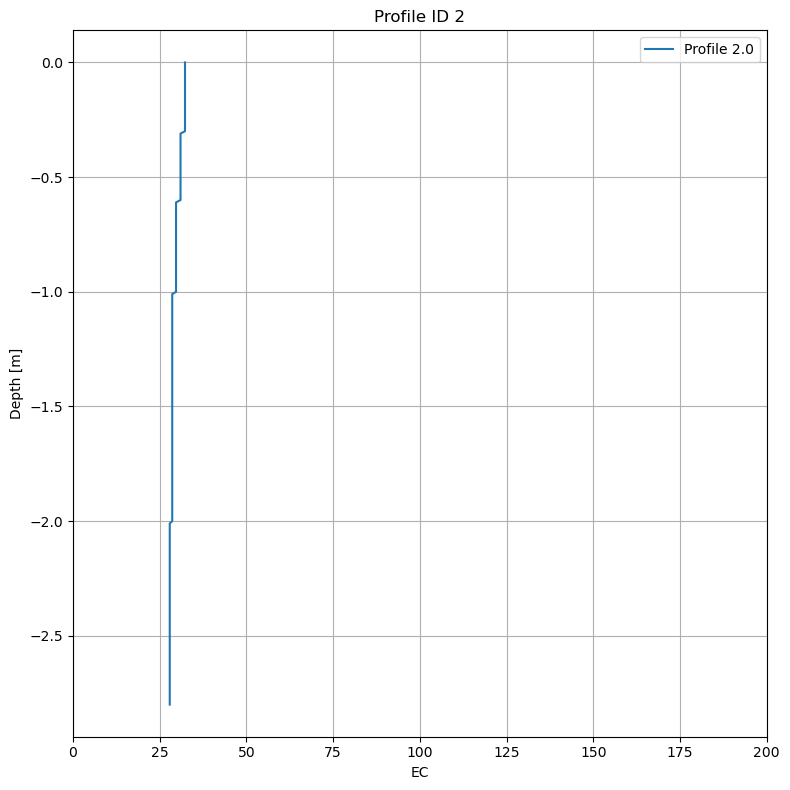

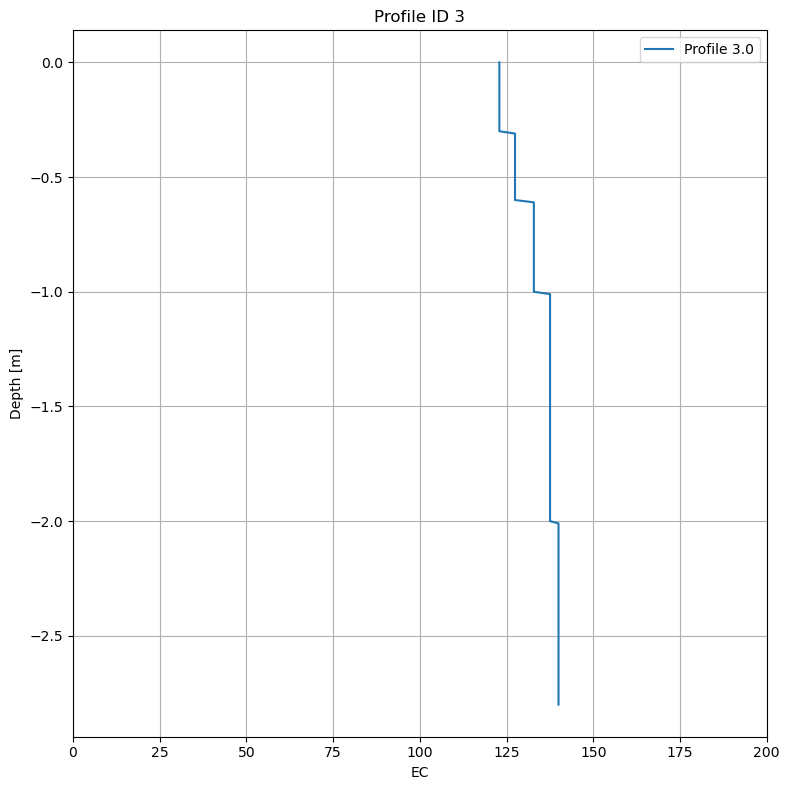

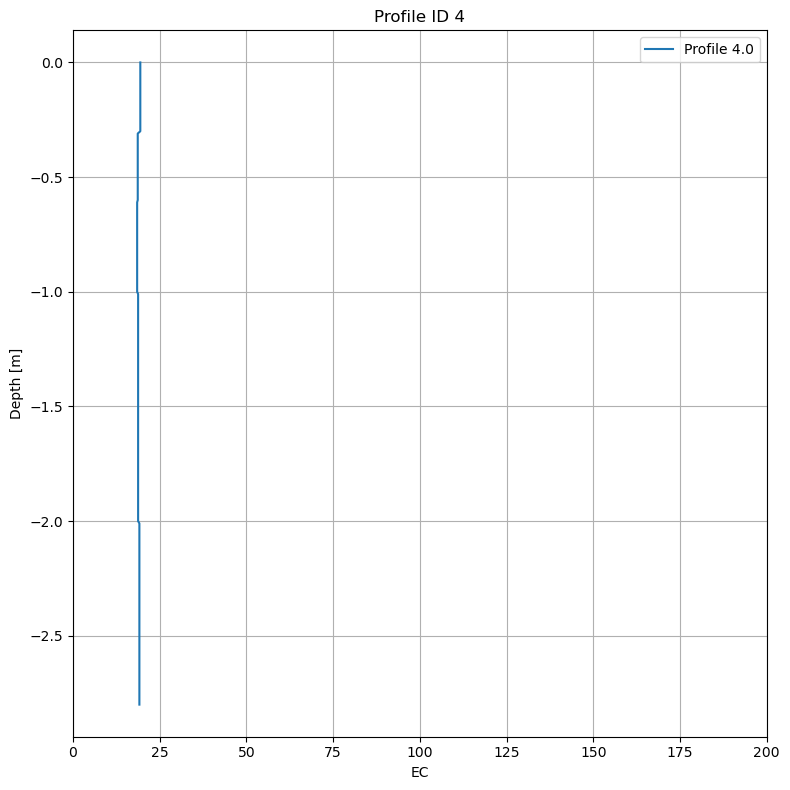

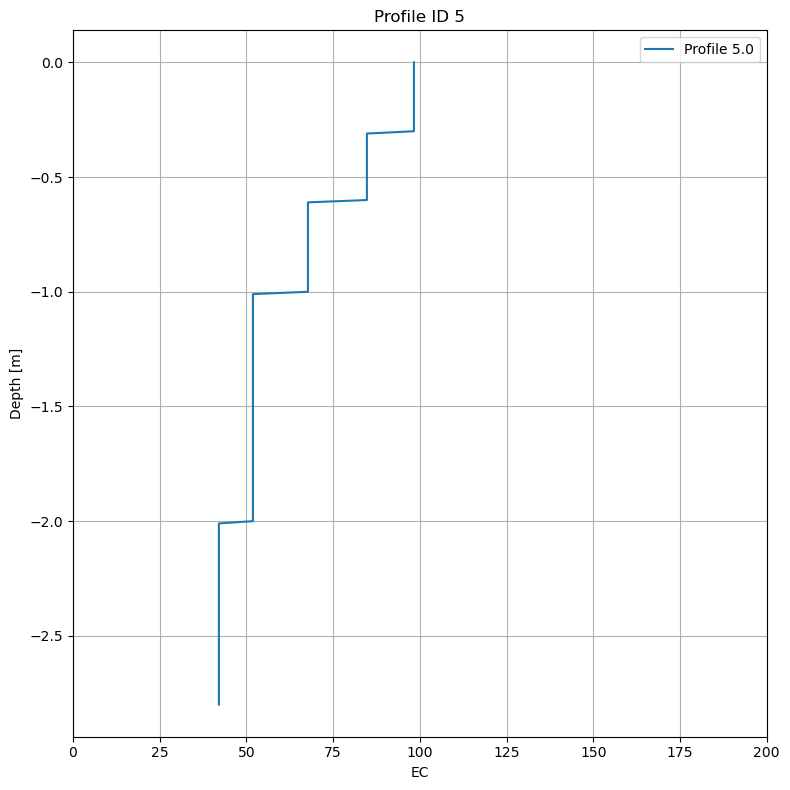

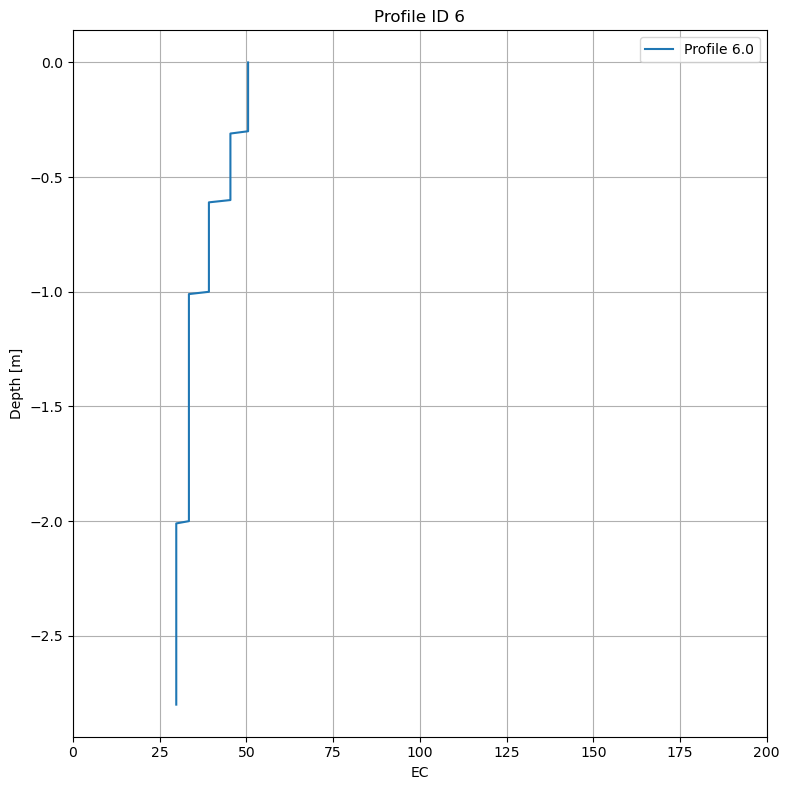

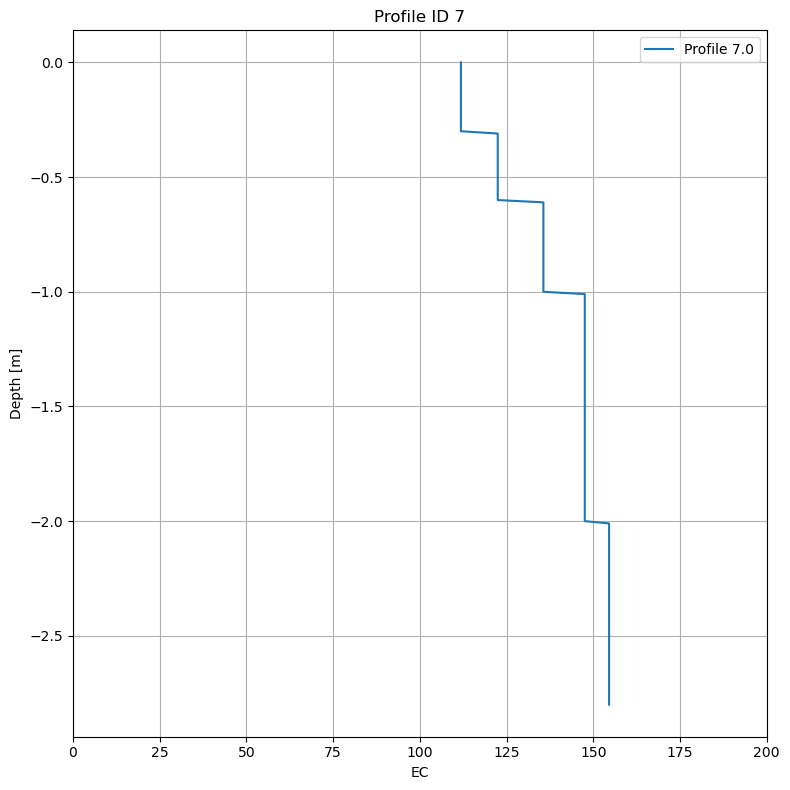

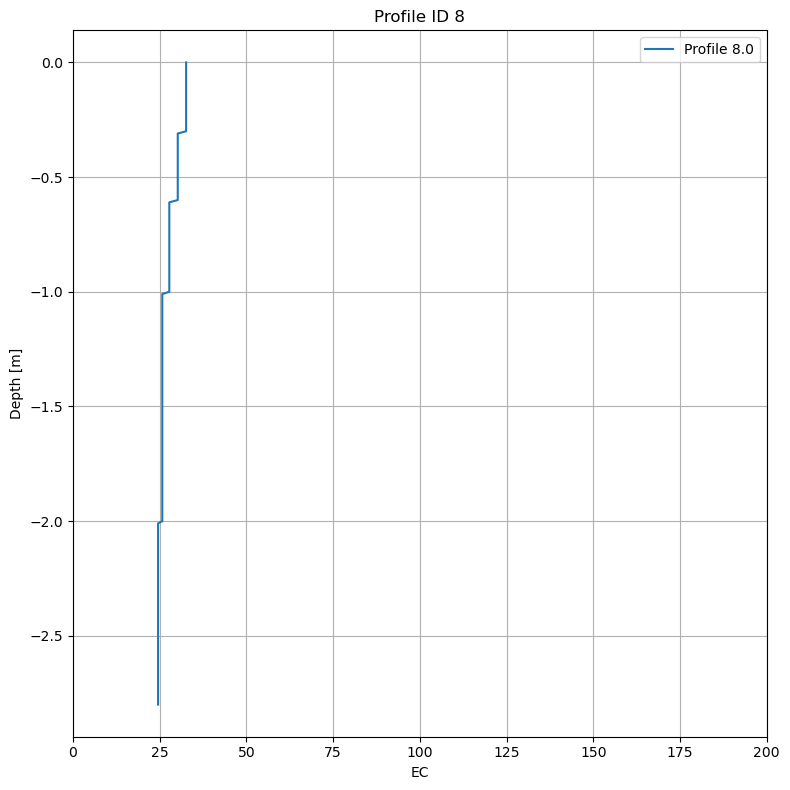

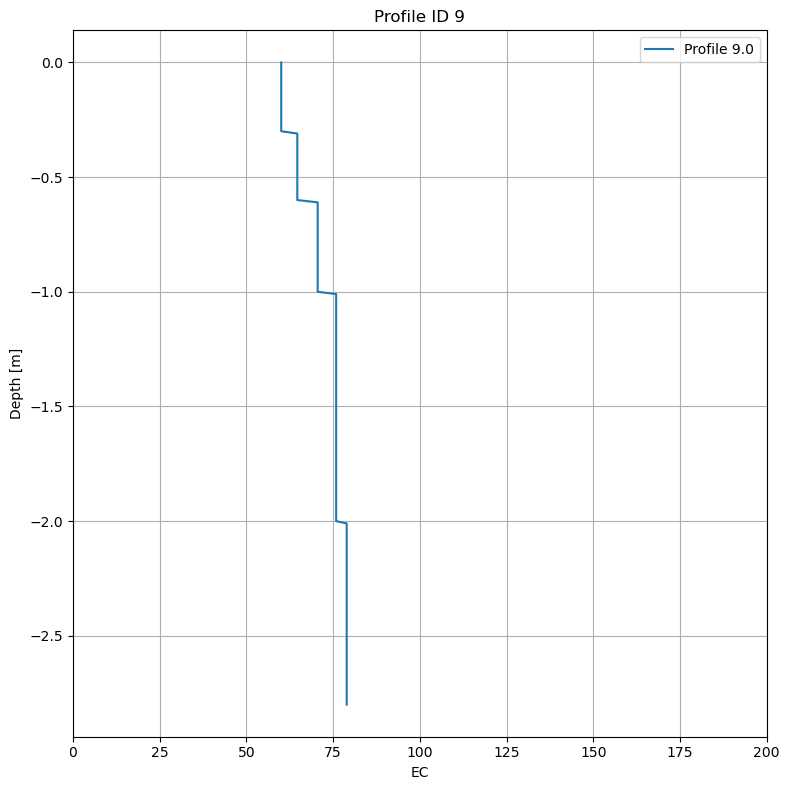

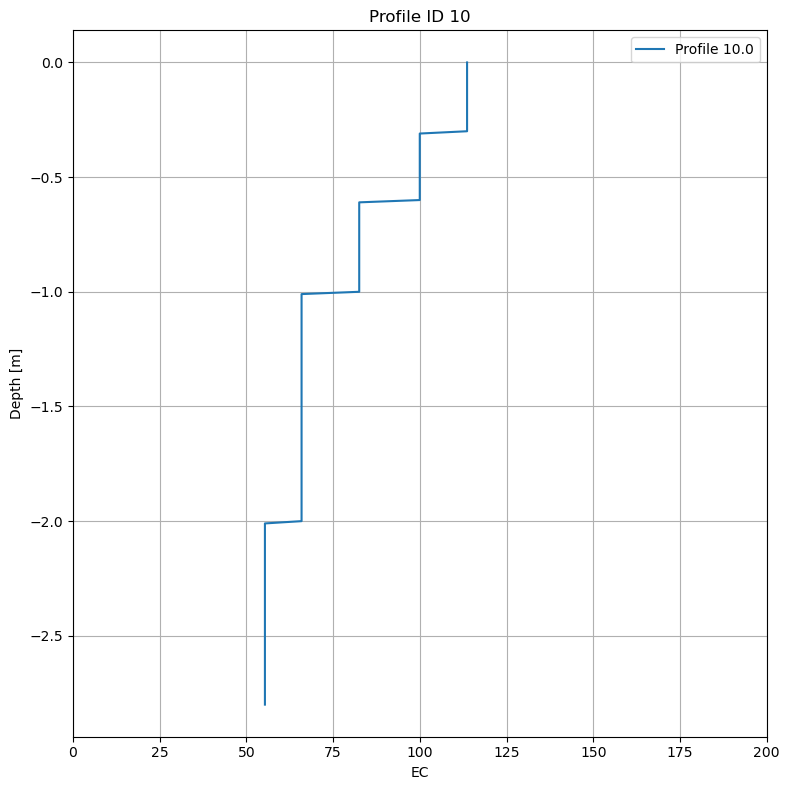

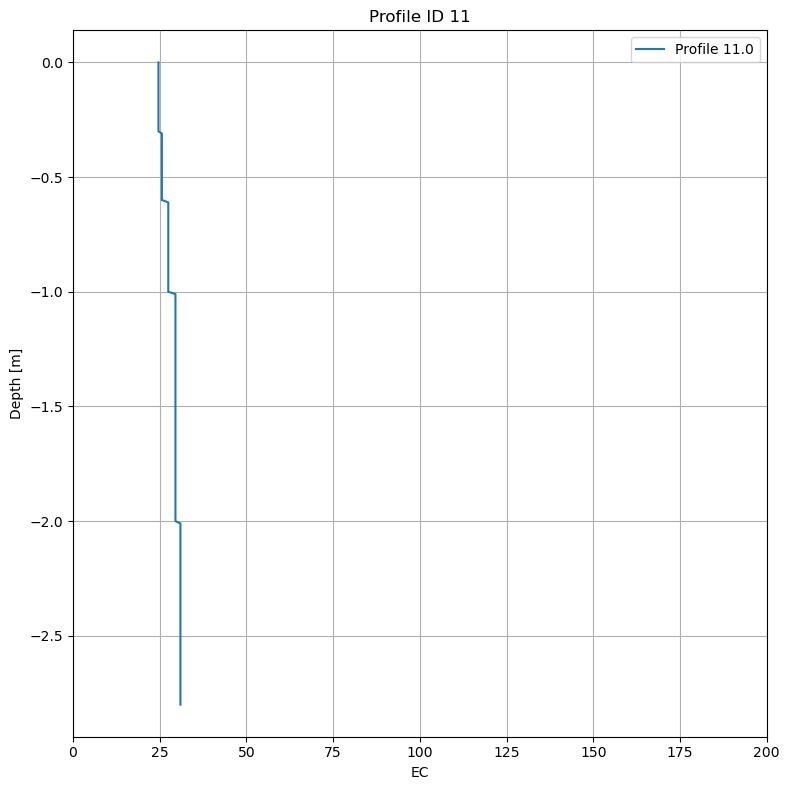

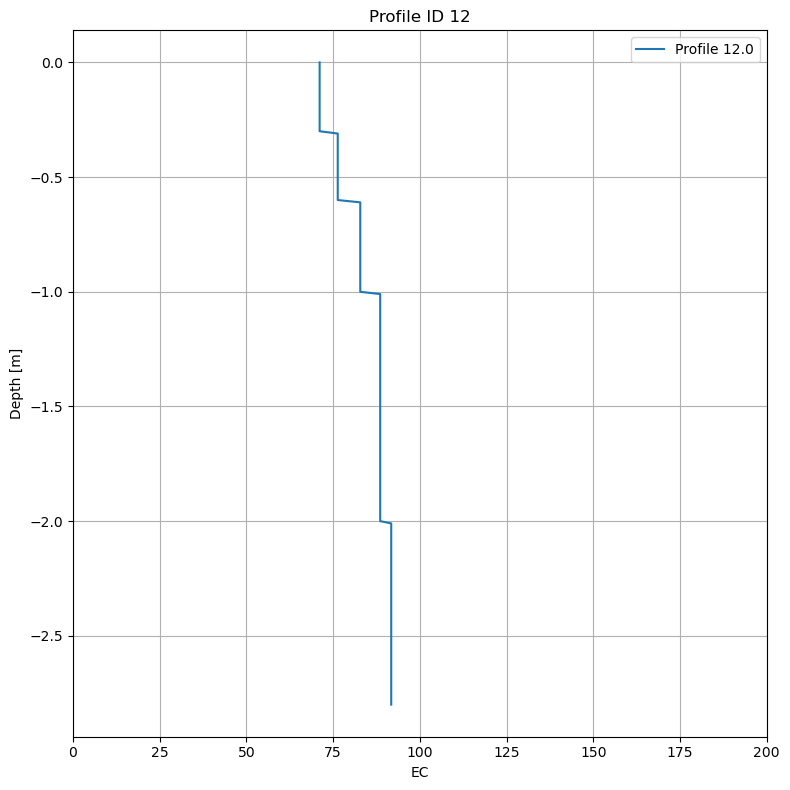

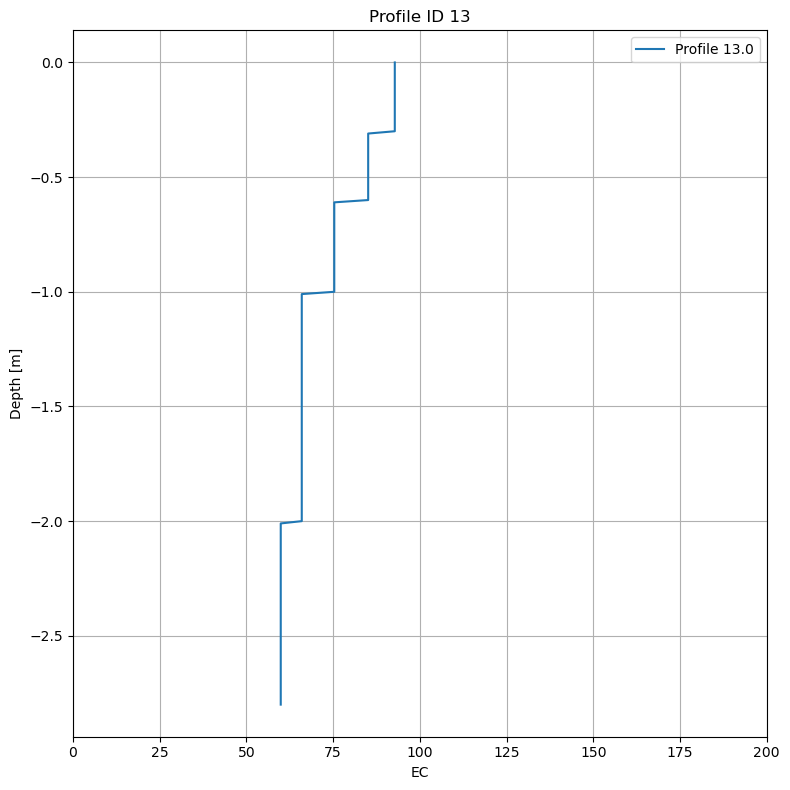

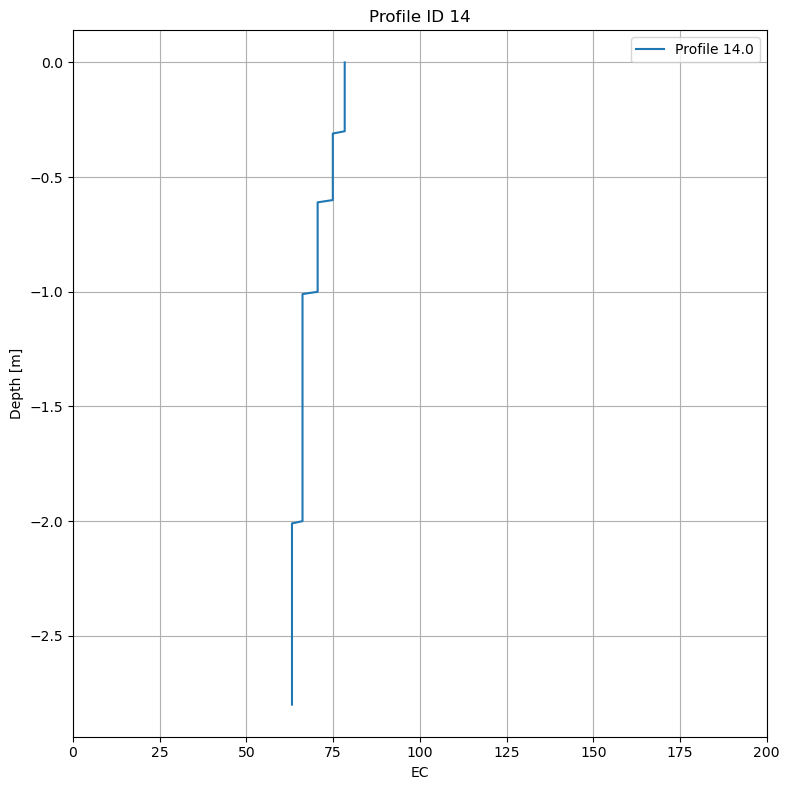

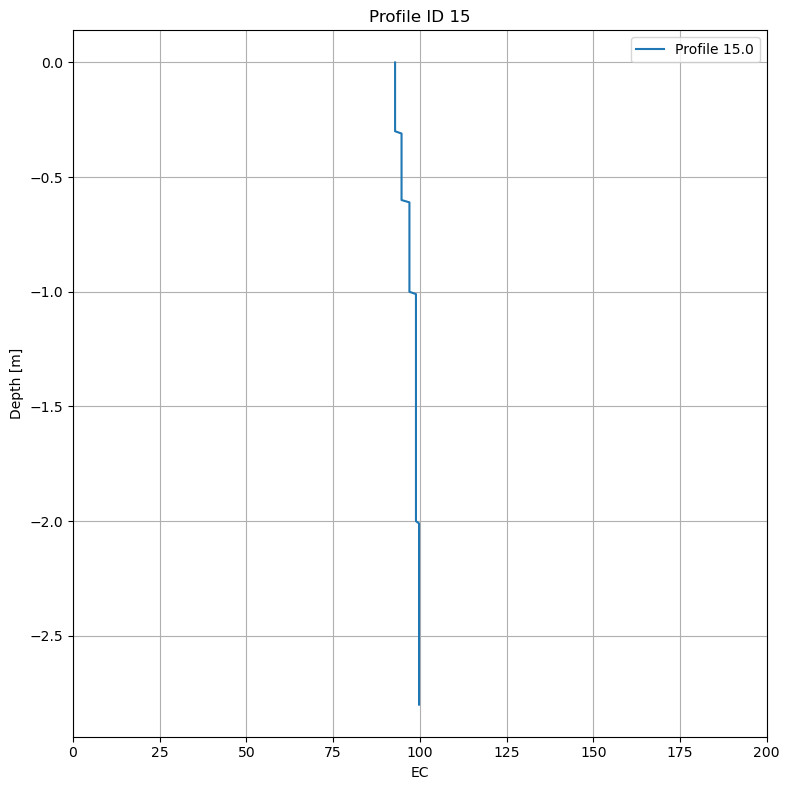

In [13]:
%autoreload
# Function to extract depth from column name
def extract_depth(col_name):
    if col_name.startswith('EC_'):
        return float(col_name.split('_')[1])
    return None

# Extracting depth values and sorting them
depth_cols = [col for col in ds_inv.columns if col.startswith('EC_')]
depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
depths.sort()

# Calculate depth for 'EC_end'
if depths:
    end_depth = depths[-1] + depths[0]
    depths.append(end_depth)

# Creating the new DataFrame
transformed_data = {
    'z': [],
    'EC': [],
    'easting': [],
    'northing': [],
    'ID': []
}

# Populating the new DataFrame
for _, row in ds_inv.iterrows():
    for depth, depth_col in zip(depths, depth_cols):
        transformed_data['z'].append(-depth)
        transformed_data['EC'].append(row[depth_col])
        transformed_data['easting'].append(row['x'])
        transformed_data['northing'].append(row['y'])
        transformed_data['ID'].append(row['pos'])

transformed_df = pd.DataFrame(transformed_data)

pdf_files = []
inv_meth = config['fs_emp']
for i in transformed_df['ID'].unique():
    profile_label = str(i)
    if '.0' in profile_label:
        profile_label = profile_label.split('.')[0]
    filename = plot_profile(transformed_df, i, 'EC', xlims=(0,200),
                 block=True,
                 save_plot = True, 
                 plot_name = f'{inv_meth}_inversion_p{profile_label}'
                 ) # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):
    
    pdf_files.append(filename)

# Merge and save PDFs
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)
merged_pdf_filename = f'{now}_{emfile_prefix}_{inv_meth}_samples.pdf'
outfile_samples_pdf = os.path.join(inv_folder, merged_pdf_filename)
merger.write(outfile_samples_pdf)
merger.close()
for pdf in pdf_files:
    os.remove(pdf)
clear_output(wait=False)

In [14]:
filename = f"{now}_{emfile_prefix}_parameters.json"
filepath = os.path.join(inv_folder,filename)
file = open(filepath, 'w')

file.write('\t"input file + path": "{}",'.format(infile) + '\n\n')
file.write('\t"instrument": "{}",'.format(config['instrument_code'] ) + '\n')
file.write('\t"instrument mode": "{}",'.format(config['instrument_orientation']) + '\n')
file.write('\t"instrument height (m)": {:.3f},'.format(config['instrument_height']) + '\n')

if config['remove_coil']:
    rem_coils = instrument.cc_names[config['coil_n']]
    file.write('\t"configurations not used in inversion": "{}",'.format(rem_coils) + '\n\n')

file.write('\t"forward model": "{}",'.format(config['fs_emp']) + '\n')
file.write('\t"optimisation method":"{}",'.format(config['opt_method']) + '\n')
file.write('\t"regularisation": "{}",'.format(config['regularization']) + '\n')
file.write('\t"alpha parameter": "{}",'.format(alph_param) + '\n\n')
file.write('\t"reference EC profile":"{}",'.format(config['reference_profile']) + '\n')

if config['constrain']:
    file.write('\t "constrained inversion":' + '\n')
    if config['n_int']:
        file.write('\t"custom interface boundaries": "{}"\n'.format(config['interface']) + '\n')
    if config['custom_bounds']:
        file.write('\t"custom inversion constraints (bnds)": "{}" \n'.format(config['bounds']) + '\n')
    else:
        file.write('\t"automated inversion constraints (bnds)": "{}"\n'.format(bounds) + '\n')
file.close()

# 03 Code

In [15]:
sampleprop = os.path.join(datafolder, f'{profile_prefix}_soil_analysis.csv')
samples_analysis = pd.read_csv(sampleprop, sep=',', header=0)
em_sample_prop = get_coincident(em_survey, samples_analysis)
instrument_code = '21HS' # 421S, '21HS'
cal = 'calibrated' # 'non_calibrated', 'drift_calibrated'


In [16]:
pd.options.future.infer_string = True
ds_c = em_sample_prop.copy()

print(ds_c.head())

# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

ds_c['bulk_ec_dc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                              bulk_ec = ds_c.bulk_ec_hp.values))

ds_c['bulk_ec_tc_hp'] = SheetsHendrickxEC( ds_c.bulk_ec_hp, ds_c.temp)
ds_c['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values,
                                                    bulk_ec_dc = ds_c.bulk_ec_dc_hp.values
                                                    ))

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)
ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

                   x              y          z         t     HCPHQP  \
5166   107720.117738  183326.959903  26.190915  40954.67  52.187318   
19244  107755.589191  183331.100490  26.895158  42473.18  16.512444   
22350  107797.401545  183278.578992  28.470657  42812.37  90.708144   
19352  107763.815598  183318.112287  27.344669  42491.37   8.642003   
1556   107723.005061  183309.181769  26.586000  40592.63  66.431144   

          PRPHQP      HCP1QP     PRP1QP      HCP2QP      PRP2QP    HCPHIP  \
5166   49.052734   51.618105  63.832856   35.850098   55.752786  0.944680   
19244  18.074690   21.883807  24.230130   29.554972   28.433310  0.958050   
22350  57.723088  119.370212  83.447332  137.357386  117.228374  0.958535   
19352  14.845471    9.100944  17.492703   23.299553   15.155927  0.958229   
1556   58.135345   64.488759  74.754468   40.828757   69.191764  0.952039   

         PRPHIP    HCP1IP    PRP1IP    HCP2IP    PRP2IP  Unnamed: 0  \
5166   1.007451  1.009043  0.446184  1.

In [17]:
inv_columns = ds_inv.columns[3:-1]
ds_c[inv_columns] = np.nan

for idc, c in enumerate(inv_columns):

    for i in range(len(ds_inv.x)):
        ds_c.loc[ds_c.code == i+1, c] = ds_inv.loc[i, c]

def closest_ec(row):
    depth = row['depth']
    # Filter columns that start with 'EC_' but not 'EC_end'
    ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
    # Convert the part after 'EC_' to float and calculate the absolute difference with depth
    differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
    # Find the column name with the minimum difference
    closest_col = min(differences, key=differences.get)
    return row[closest_col]

print(ds_c.head())

# Apply the function to each row
ds_c['bulk_ec_inv'] = ds_c.apply(closest_ec, axis=1)

ds_c['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values+273.15,
                                                      frequency_ec = 9e3,
                                                      bulk_ec = ds_c.bulk_ec_inv.values/1000))*1000


ds_c['ideal_bulk_ec'] = predict.BulkEC(
                                        Soil(temperature = ds_c.temp.values+273.15,
                                             water = ds_c.vwc.values,
                                             clay = ds_c.clay.values,
                                             bulk_density = ds_c.bd.values,
                                             water_ec = ds_c.water_ec_hp.values,
                                             frequency_ec = 9e3
                                            )

)

if instrument_code == '21HS':
    feature_set = [
        'HCPHQP',
        'HCP1QP',
        'HCP2QP',
        'PRPHQP',
        'PRP1QP',
        'PRP2QP',
        'bulk_ec_inv',
    #    'bulk_ec_dc_tc_inv',
    #    'bulk_ec_hp',
    #    'bulk_ec_dc_tc_hp'
    ]
elif instrument_code == '421S':
    feature_set = [
        'HCP1QP',
        'HCP2QP',
        'HCP4QP',
        'PRP1QP',
        'PRP2QP',
        'PRP4QP',
        'bulk_ec_inv',
    #    'bulk_ec_dc_tc_inv',
    #    'bulk_ec_hp',
    #    'bulk_ec_dc_tc_hp'
    ]
    
folder_path = 'output_tables/'
file_name = 'ds_c_'+profile_prefix+'.csv'
ds_c.to_csv(folder_path + file_name, index=False)

                   x              y          z         t     HCPHQP  \
5166   107720.117738  183326.959903  26.190915  40954.67  52.187318   
19244  107755.589191  183331.100490  26.895158  42473.18  16.512444   
22350  107797.401545  183278.578992  28.470657  42812.37  90.708144   
19352  107763.815598  183318.112287  27.344669  42491.37   8.642003   
1556   107723.005061  183309.181769  26.586000  40592.63  66.431144   

          PRPHQP      HCP1QP     PRP1QP      HCP2QP      PRP2QP    HCPHIP  \
5166   49.052734   51.618105  63.832856   35.850098   55.752786  0.944680   
19244  18.074690   21.883807  24.230130   29.554972   28.433310  0.958050   
22350  57.723088  119.370212  83.447332  137.357386  117.228374  0.958535   
19352  14.845471    9.100944  17.492703   23.299553   15.155927  0.958229   
1556   58.135345   64.488759  74.754468   40.828757   69.191764  0.952039   

         PRPHIP    HCP1IP    PRP1IP    HCP2IP    PRP2IP  Unnamed: 0  \
5166   1.007451  1.009043  0.446184  1.

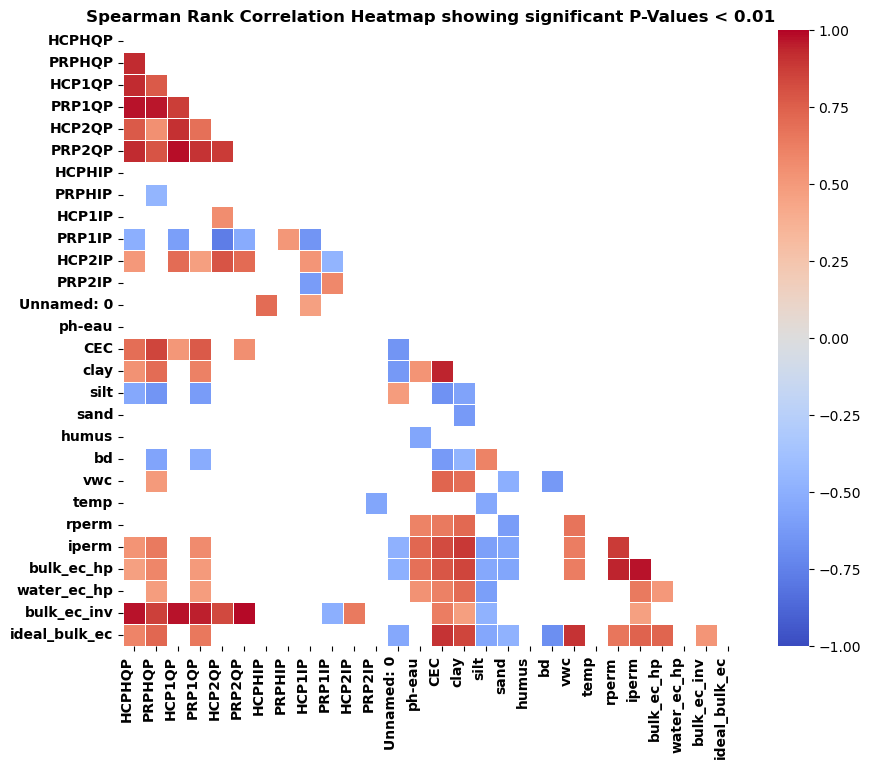

In [18]:
filtered_features = ['x', 'y', 'z', 't', 'geometry', 'code', 'TOC', 'x_clhs', 'y_clhs', 'depth', 'copeky', 'bulk_ec_dc_hp', 'bulk_ec_tc_hp', 'bulk_ec_dc_tc_hp', 'water_ec_hp_t', 'iperm_water_t', 'bulk_ec_dc_tc_inv']

# Filter out columns that start with 'EC_' and are not constant
non_ec_columns = [col for col in ds_c.columns if col not in filtered_features and not col.startswith('EC_') and not col.endswith('_inph')]

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(ds_c[non_ec_columns], nan_policy='omit')

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=non_ec_columns, columns=non_ec_columns)
p_value_df = pd.DataFrame(p_value, index=non_ec_columns, columns=non_ec_columns)

# Create a mask for significant p-values (e.g., p < 0.01)
p_value_mask = 0.01
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 8})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
plt.title('Spearman Rank Correlation Heatmap showing significant P-Values < '+str(p_value_mask), fontsize=12, fontweight='bold')

# Show the plot

folder_path = 'output_images/'
filename = f"Corr_{s_site}_{cal}_{em_intype}.pdf"
plt.savefig(folder_path + filename)
plt.show()

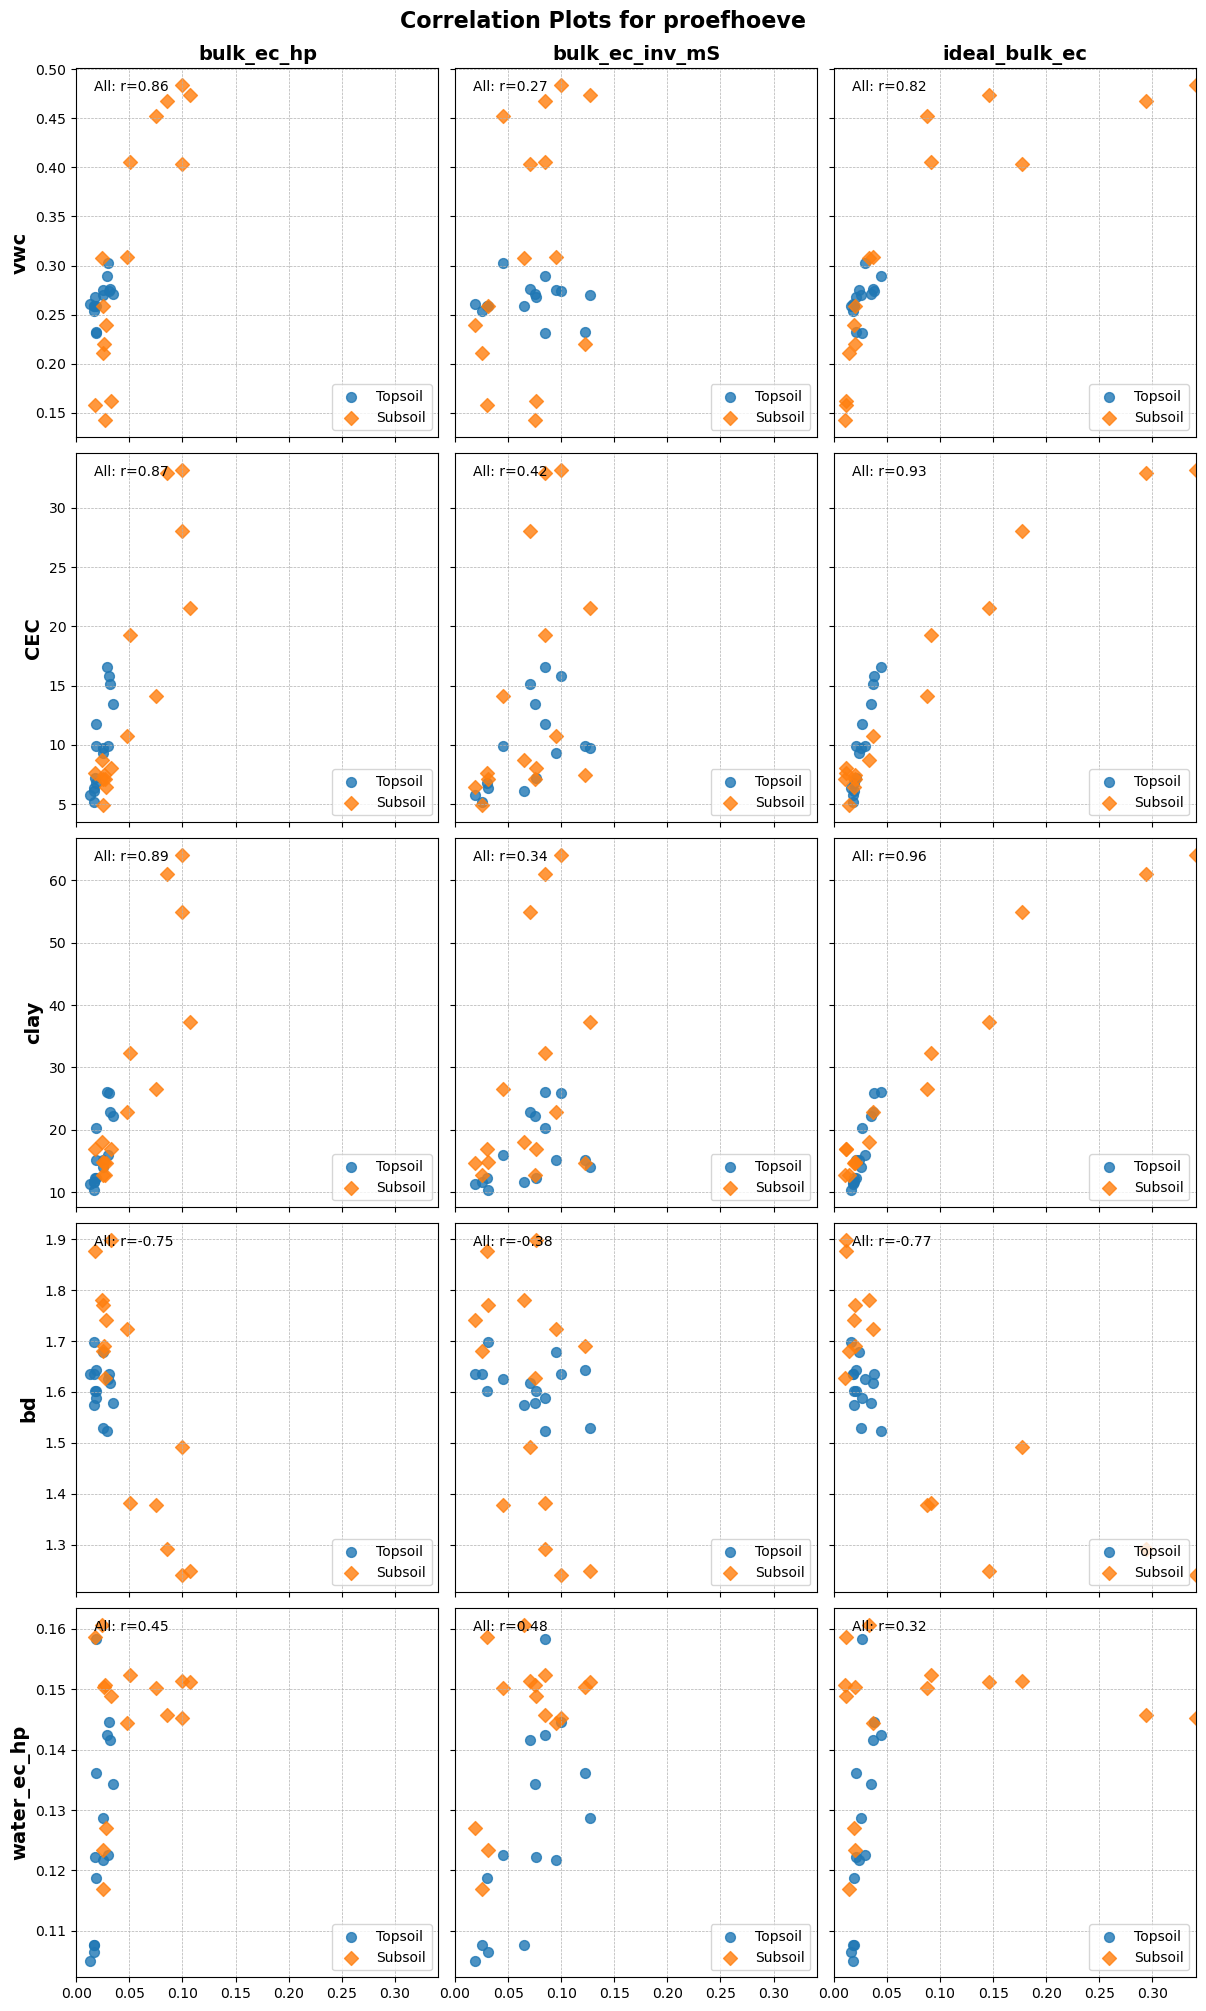

In [19]:
fig, axes = plt.subplots(5, 3, figsize=(12, 20))
ss = 50  # Reduced size for scatter points

ds_c['bulk_ec_inv_mS'] = ds_c.bulk_ec_inv/1000
preds = ['bulk_ec_hp', 'bulk_ec_inv_mS', 'ideal_bulk_ec']

def corr_plot(df, preds, targets):
    global_max_x = float('-inf')

    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):
            ax = axes[target_index, pred_index]
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            #ax.set_aspect('equal')  # Ensure each subplot is square

            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                label = 'Topsoil' if layer_cm == 10 else 'Subsoil'
                ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o' if layer_cm == 10 else 'D', label=label)

            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:
                ax.set_xticklabels([])
            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:
                ax.set_yticklabels([])

            # Update global max x value
            global_max_x = max(global_max_x, x_data.max())

            ax.legend(loc='lower right')  # Add the legend in the lower right corner

    # Set the same x-axis limits for all subplots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlim(0, global_max_x)

corr_plot(ds_c, preds, ['vwc', 'CEC', 'clay', 'bd', 'water_ec_hp'])

plt.subplots_adjust(top=0.7)  # You can adjust this value as needed
plt.suptitle(f"Correlation Plots for {profile_prefix}", fontweight='bold', fontsize=16, y=0.999)  # Adjust y as needed
plt.tight_layout(pad=0.5, w_pad=0.4, h_pad=0.8)

folder_path = 'output_images/'
filename = f"Plot_{s_site}.pdf"
plt.savefig(folder_path + filename)
plt.show()

# Deterministic modelling

## Implementation

In [20]:
clay_50cm = np.mean(ds_c.clay[ds_c['depth']==50])
clay_10cm = np.mean(ds_c.clay[ds_c['depth']==10])
bd_50cm = np.mean(ds_c.bd[ds_c['depth']==50])
bd_10cm = np.mean(ds_c.bd[ds_c['depth']==10])
water_ec_hp_50cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==50])
water_ec_hp_10cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==10])
water_ec_hp_50cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==50])
water_ec_hp_10cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==10])
clay_mean = np.mean(ds_c.clay)
bd_mean = np.mean(ds_c.bd)
water_ec_hp_mean = np.mean(ds_c.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds_c.water_ec_hp_t)
temp_50cm = np.mean(ds_c.temp[ds_c['depth']==50])
temp_10cm = np.mean(ds_c.temp[ds_c['depth']==10])
temp_mean = np.mean(ds_c.temp)
vwc_50cm = np.mean(ds_c.vwc[ds_c['depth']==50])
vwc_10cm = np.mean(ds_c.vwc[ds_c['depth']==10])
vwc_mean = np.mean(ds_c.vwc)

In [21]:
def deterministic(feature, target, df, iters=100, round_n=3):
  df.reset_index(drop=True, inplace=True)

  ### Extract indices for 10 cm and 50 cm layers
  idx_layer_10 = df[df['depth'] == 10].index
  idx_layer_50 = df[df['depth'] == 50].index
  ### Select data at 10 cm depth
  X_layer_10 = df.loc[idx_layer_10, feature].values.reshape(-1, 1)
  Y_layer_10 = df.loc[idx_layer_10, target].values
  ### Select data at 50 cm depth
  X_layer_50 = df.loc[idx_layer_50, feature].values.reshape(-1, 1)
  Y_layer_50 = df.loc[idx_layer_50, target].values

  f_ec = 9000
  t_conv = 273.15
  t_50cm_conv = temp_50cm+t_conv
  t_10cm_conv = temp_10cm+t_conv
  t_mean_conv = temp_mean+t_conv

  # Preallocate lists
  DR2_LS, DRMSE_LS = [None] * iters, [None] * iters
  DR2_LT, DRMSE_LT = [None] * iters, [None] * iters
  DR2_10, DRMSE_10 = [None] * iters, [None] * iters
  DR2_50, DRMSE_50 = [None] * iters, [None] * iters
  DR2_ID, DRMSE_ID, ypred_ID_ = [None] * iters, [None] * iters, [None] * iters
  y_ = [None] * iters
  
  for i in range(iters):
    ### Split data of 10cm layer and keep track of test indices
    X_train10, X_test10, y_train10, y_test10, idx_train10, idx_test10 = train_test_split(X_layer_10, Y_layer_10, idx_layer_10, test_size=0.3, random_state=i)
    ### Split data of 50cm layer and keep track of test indices
    X_train50, X_test50, y_train50, y_test50, idx_train50, idx_test50 = train_test_split(X_layer_50, Y_layer_50, idx_layer_50, test_size=0.3, random_state=i)

    ### Combine test indices from both layers
    idx_test = np.concatenate((idx_test10, idx_test50))
    y_test = np.concatenate((y_test10, y_test50)).flatten()
    X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
    y_[i] = y_test

    ### Predict using layer together 
    LT = Soil( 
                bulk_ec = X_test,
                frequency_ec=f_ec,
                clay = clay_mean,
                bulk_density = bd_mean,
                water_ec = water_ec_hp_mean,
                temperature = t_mean_conv
                  )
    Dypred_LT = predict.Water(LT)
    DR2_LT[i] = round(r2_score(y_test, Dypred_LT), round_n)
    DRMSE_LT[i] = round(RMSE(y_test, Dypred_LT), round_n)

    ### Predict using 10 cm layer
    layer_10 = Soil( 
                bulk_ec = X_test10.flatten()/1000,
                frequency_ec=f_ec,
                clay = clay_10cm,
                bulk_density = bd_10cm,
                water_ec = water_ec_hp_10cm,
                temperature = t_10cm_conv
                  )
    Dypred_10 = predict.Water(layer_10)
    DR2_10[i] = round(r2_score(y_test10, Dypred_10), round_n)
    DRMSE_10[i] = round(RMSE(y_test10, Dypred_10), round_n)

    ### Predict using 50 cm layer
    layer_50 = Soil( 
                bulk_ec = X_test50.flatten()/1000,
                frequency_ec=f_ec,
                clay = clay_50cm,
                bulk_density = bd_50cm,
                water_ec = water_ec_hp_50cm,
                temperature = t_50cm_conv
                  )
    Dypred_50 = predict.Water(layer_50)
    DR2_50[i] = round(r2_score(y_test50, Dypred_50), round_n)
    DRMSE_50[i] = round(RMSE(y_test50, Dypred_50), round_n)

    ### Stochastic modelling for layers separate. 
    ### This is a combination of both layer's prediction
    Dypred_LS = np.concatenate((Dypred_10, Dypred_50))
    DR2_LS[i] = round(r2_score(y_test, Dypred_LS), round_n)
    DRMSE_LS[i] = round(RMSE(y_test, Dypred_LS), round_n)

    ### Predict using ideal samples
    filtered_df = df.loc[idx_test]
    ID =  Soil( 
                bulk_ec = X_test,
                frequency_ec=f_ec,
                clay = filtered_df['clay'].values,
                bulk_density = filtered_df['bd'].values,
                water_ec = filtered_df['water_ec_hp'].values,
                temperature = filtered_df['temp'].values+t_conv
                  )
    Dypred_ID = predict.Water(ID)
    ypred_ID_[i] = Dypred_ID
    DR2_ID[i] = round(r2_score(y_test, Dypred_ID), round_n)
    DRMSE_ID[i] = round(RMSE(y_test, Dypred_ID), round_n)

  return DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50

Dresults = {}
target = 'vwc'
%timeit

for feature in feature_set:
  DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50 = deterministic(feature, target, ds_c)

  Dresults[feature] = {
        'LT': {'R2': DR2_LT, 'RMSE': DRMSE_LT},
        'LS': {'R2': DR2_LS, 'RMSE': DRMSE_LS},
        'ID': {'R2': DR2_ID, 'RMSE': DRMSE_ID},
  'layer 10': {'R2': DR2_10, 'RMSE': DRMSE_10},
  'layer 50': {'R2': DR2_50, 'RMSE': DRMSE_50}
  }
  %timeit
%timeit

## Process results

In [22]:
# Convert results to DataFrame for easier processing
Dresults_df = pd.DataFrame(Dresults).T.stack().reset_index()
Dresults_df.columns = ['Feature', 'Model', 'Scores']
Dresults_df = Dresults_df.join(pd.DataFrame(Dresults_df.pop('Scores').values.tolist()))

# Calculate median of each list in RMSE and R2 columns
Dresults_df['Median RMSE'] = Dresults_df['RMSE'].apply(lambda x: np.median(x))
Dresults_df['Median R2'] = Dresults_df['R2'].apply(lambda x: np.median(x))

# Create a DataFrame for median scores
median_scores = Dresults_df[['Feature', 'Model', 'Median RMSE', 'Median R2']]

# Find best features based on criteria
error_criteria = 'R2'  # Change to 'R2' to select based on R2
if error_criteria == 'RMSE':
    best_features = median_scores.loc[median_scores.groupby('Model')['Median RMSE'].idxmin()]
else:
    best_features = median_scores.loc[median_scores.groupby('Model')['Median R2'].idxmax()]

# Prepare final DataFrame
DR2_results = pd.DataFrame({
    'Target': target,
    'Best Feature LT': best_features.loc[best_features['Model'] == 'LT', 'Feature'].values[0],
    'R2 LT':           best_features.loc[best_features['Model'] == 'LT', 'Median R2'].values[0],
    'Best Feature ID': best_features.loc[best_features['Model'] == 'ID', 'Feature'].values[0],
    'R2 ID':           best_features.loc[best_features['Model'] == 'ID', 'Median R2'].values[0],
    'Best Feature LS': best_features.loc[best_features['Model'] == 'LS', 'Feature'].values[0],
    'R2 LS':           best_features.loc[best_features['Model'] == 'LS', 'Median R2'].values[0],
    'Best Feature 10': best_features.loc[best_features['Model'] == 'layer 10', 'Feature'].values[0],
    'R2 10':           best_features.loc[best_features['Model'] == 'layer 10', 'Median R2'].values[0],
    'Best Feature 50': best_features.loc[best_features['Model'] == 'layer 50', 'Feature'].values[0],
    'R2 50':           best_features.loc[best_features['Model'] == 'layer 50', 'Median R2'].values[0]
}, index=[0])

folder_path = 'output_tables/'
file_name = 'DR2_results' + '_' + s_site + '_' + em_intype + '_' + cal + '_' + instrument_code + '.xlsx'
DR2_results.to_excel(folder_path + file_name, index=False)
DR2_results

bulk_ec_inv_data = median_scores[median_scores['Feature'] == 'bulk_ec_inv']

DR2_results_inv = pd.DataFrame({
    'Target': target,
    'Inverted EC LT R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'LT', 'Median R2'].values[0],
    'Inverted EC ID R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'ID', 'Median R2'].values[0],
    'Inverted EC LS R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'LS', 'Median R2'].values[0],
    'Inverted EC 10 R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'layer 10', 'Median R2'].values[0],
    'Inverted EC 50 R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'layer 50', 'Median R2'].values[0],
    }, index=[0])

folder_path = 'output_tables/'
file_name = 'DR2_results_inv_' + '_' + s_site + '_' + em_intype + '_' + cal + '_' + instrument_code + '.xlsx'
DR2_results_inv.to_excel(folder_path + file_name, index=False)
DR2_results_inv

Target  Inverted EC LT R2  Inverted EC ID R2  Inverted EC LS R2  \
0    vwc             -5.963            -8.2715             -6.444   

   Inverted EC 10 R2  Inverted EC 50 R2  
0           -317.042            -1.4405

## Plot results

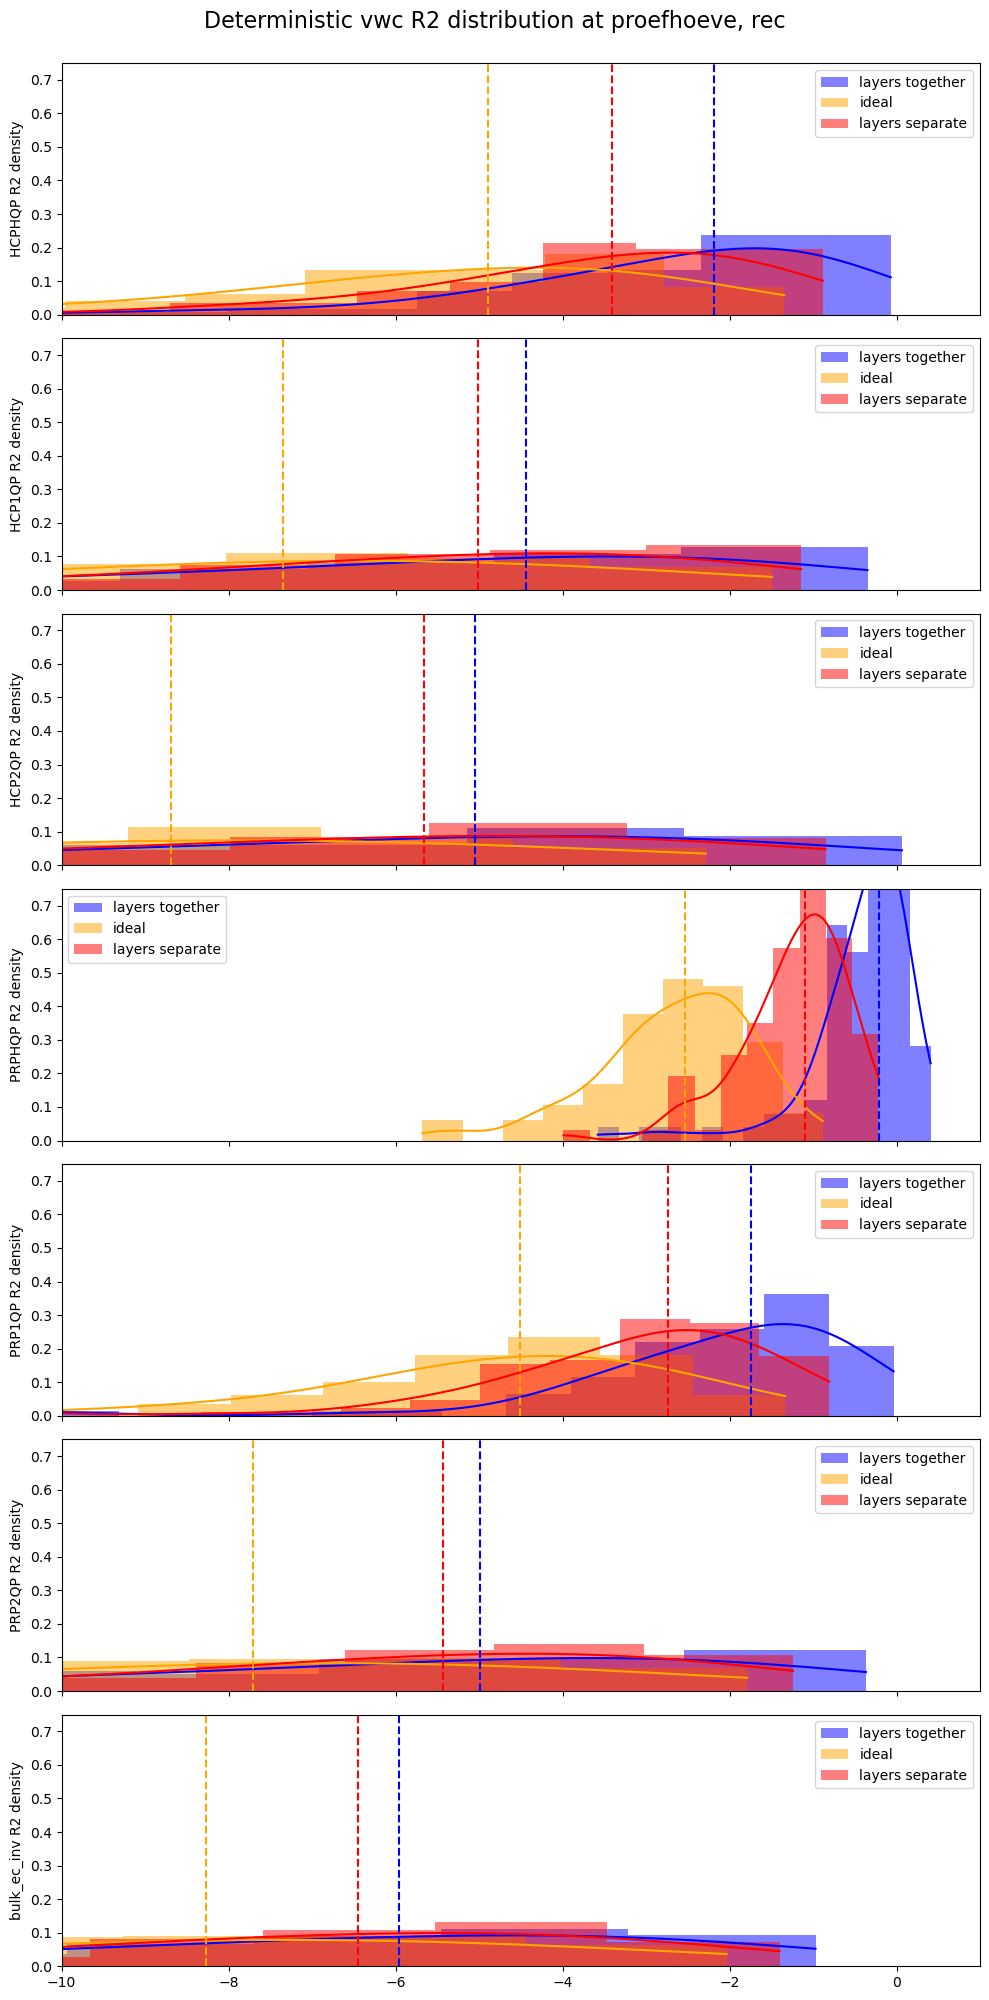

In [23]:
plot_det(Dresults, feature_set, target, profile_prefix, em_intype, cal, s_site, 'R2', 'blue', 'red', 'orange')

# Stochastic modelling

## Implementation

In [24]:
def stochastic(features, target, df, criteria='R2', n=4, iters=100, round_n=3):
    ### Defining lists to store results and error indicators
    SR2_train_10_, SR2_test_10_, Sypred_test_10_ = [], [], []
    SR2_train_50_, SR2_test_50_, Sypred_test_50_ = [], [], []
    SR2_train_LT_, SR2_test_LT_ = [], []
    SR2_train_LS_, SR2_test_LS_ = [], []
    y_test_ = []

    ### Extract indices for 10 cm and 50 cm layers
    idx_layer_10 = df[df['depth'] == 10].index
    idx_layer_50 = df[df['depth'] == 50].index
    ### Select data at 10 cm depth
    X_layer_10 = df.loc[idx_layer_10, features].values.reshape(-1, 1)
    Y_layer_10 = df.loc[idx_layer_10, target].values
    ### Select data at 50 cm depth
    X_layer_50 = df.loc[idx_layer_50, features].values.reshape(-1, 1)
    Y_layer_50 = df.loc[idx_layer_50, target].values

    for i in range(iters):
        ### Split data of 10cm layer and keep track of test indices
        X_train10, X_test10, y_train10, y_test10 = train_test_split(X_layer_10, Y_layer_10, test_size=0.3, random_state=i)
        SR2_train_10, SR2_test_10, Sypred_test_10 = [], [], []
        ### Split data of 50cm layer and keep track of test indices
        X_train50, X_test50, y_train50, y_test50 = train_test_split(X_layer_50, Y_layer_50, test_size=0.3, random_state=i)
        SR2_train_50, SR2_test_50, Sypred_test_50 = [], [], []
        ### Combine test indices from both layers
        y_train = np.concatenate((y_train10, y_train50))
        y_test = np.concatenate((y_test10, y_test50)).flatten()
        X_train = np.concatenate((X_train10, X_train50))
        X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
        y_test_.append(y_test)

        SR2_train_LS, SR2_test_LS = [], []
        SR2_train_LT, SR2_test_LT = [], []

        for k in range(n):

            #### Stochastic modelling for layers together
            polyLT = PolynomialFeatures(degree=k)
            polyLT.fit(X_train)
            Xt_trainLT = polyLT.transform(X_train)
            Xt_testLT = polyLT.transform(X_test.reshape(-1, 1))
            LinRegLT = LinearRegression()
            LinRegLT.fit(Xt_trainLT, y_train)
            Sypred_trainLT = LinRegLT.predict(Xt_trainLT)
            Sypred_testLT = LinRegLT.predict(Xt_testLT)
                # Save results and error indicators over polinomial degrees
            SR2_train_LT.append(round(r2_score(y_train, Sypred_trainLT), round_n))
            SR2_test_LT.append(round(r2_score(y_test, Sypred_testLT), round_n))

            #### Stochastic modelling 10 cm layer
            LinReg10 = LinearRegression()
            poly10 = PolynomialFeatures(degree=k)
            poly10.fit(X_train10)
            Xt_train10 = poly10.transform(X_train10)
            Xt_test10 = poly10.transform(X_test10)
            LinReg10.fit(Xt_train10, y_train10)
            Sypred_train10 = LinReg10.predict(Xt_train10)
            Sypred_test10 = LinReg10.predict(Xt_test10)
                # Save results and error indicators over polinomial degrees
            Sypred_test_10.append(Sypred_test10)
            SR2_train_10.append(round(r2_score(y_train10, Sypred_train10), round_n))
            SR2_test_10.append(round(r2_score(y_test10, Sypred_test10), round_n))

            #### Stochastic modelling 50 cm layer
            LinReg50 = LinearRegression()
            poly50 = PolynomialFeatures(degree=k)
            poly50.fit(X_train50)
            Xt_train50 = poly50.transform(X_train50)
            Xt_test50 = poly50.transform(X_test50)
            LinReg50.fit(Xt_train50, y_train50)
            Sypred_train50 = LinReg50.predict(Xt_train50)
            Sypred_test50 = LinReg50.predict(Xt_test50)
                # Save results and error indicators over polinomial degrees
            Sypred_test_50.append(Sypred_test50)
            SR2_train_50.append(round(r2_score(y_train50, Sypred_train50), round_n))
            SR2_test_50.append(round(r2_score(y_test50, Sypred_test50), round_n))

            ### Stochastic modelling for layers separate. 
            ### This is a combination of both layer's prediction
            Sypred_train_LS = np.concatenate((Sypred_train10, Sypred_train50))
            Sypred_test_LS = np.concatenate((Sypred_test10, Sypred_test50))

            SR2_train_LS.append(round(r2_score(y_train, Sypred_train_LS), round_n))
            SR2_test_LS.append(round(r2_score(y_test, Sypred_test_LS), round_n))

        # Save results over all splits
        SR2_train_10_.append(SR2_train_10)
        SR2_test_10_.append(SR2_test_10)
        Sypred_test_10_.append(Sypred_test_10)

        SR2_train_50_.append(SR2_train_50)
        SR2_test_50_.append(SR2_test_50)
        Sypred_test_50_.append(Sypred_test_50)

        SR2_train_LS_.append(SR2_train_LS)
        SR2_test_LS_.append(SR2_test_LS)

        SR2_train_LT_.append(SR2_train_LT)
        SR2_test_LT_.append(SR2_test_LT)

        SR2_test_LS0 = [inner_list[0] for inner_list in SR2_test_LS_]
        SR2_test_LS1 = [inner_list[1] for inner_list in SR2_test_LS_]
        SR2_test_LS2 = [inner_list[2] for inner_list in SR2_test_LS_]
        SR2_test_LS3 = [inner_list[3] for inner_list in SR2_test_LS_]

        SR2_test_LT0 = [inner_list[0] for inner_list in SR2_test_LT_]
        SR2_test_LT1 = [inner_list[1] for inner_list in SR2_test_LT_]
        SR2_test_LT2 = [inner_list[2] for inner_list in SR2_test_LT_]
        SR2_test_LT3 = [inner_list[3] for inner_list in SR2_test_LT_]
        #####

        SR2_test_10_0 = [inner_list[0] for inner_list in SR2_test_10_]
        SR2_test_10_1 = [inner_list[1] for inner_list in SR2_test_10_]
        SR2_test_10_2 = [inner_list[2] for inner_list in SR2_test_10_]
        SR2_test_10_3 = [inner_list[3] for inner_list in SR2_test_10_]

        SR2_test_50_0 = [inner_list[0] for inner_list in SR2_test_50_]
        SR2_test_50_1 = [inner_list[1] for inner_list in SR2_test_50_]
        SR2_test_50_2 = [inner_list[2] for inner_list in SR2_test_50_]
        SR2_test_50_3 = [inner_list[3] for inner_list in SR2_test_50_]

    #########################
    if criteria == 'R2':

        SR2_10 = [SR2_test_10_0, SR2_test_10_1, SR2_test_10_2, SR2_test_10_3]
        SR2_meadian_10 = [np.median(sublist) for sublist in SR2_10]
        best_n_10 = SR2_meadian_10.index(np.max(SR2_meadian_10))
        SR2_test_10b = SR2_10[best_n_10]

        SR2_50 = [SR2_test_50_0, SR2_test_50_1, SR2_test_50_2, SR2_test_50_3]
        SR2_meadian_50 = [np.median(sublist) for sublist in SR2_50]
        best_n_50 = SR2_meadian_50.index(np.max(SR2_meadian_50))
        SR2_test_50b = SR2_50[best_n_50]

        SR2_LT = [SR2_test_LT0, SR2_test_LT1, SR2_test_LT2, SR2_test_LT3]
        SR2_meadian_LT = [np.median(sublist) for sublist in SR2_LT]
        best_n_LT = SR2_meadian_LT.index(np.max(SR2_meadian_LT))
        SR2_test_LTb = SR2_LT[best_n_LT]

        SR2_LS = [SR2_test_LS0, SR2_test_LS1, SR2_test_LS2, SR2_test_LS3]
        SR2_meadian_LS = [np.median(sublist) for sublist in SR2_LS]
        best_n_LS = SR2_meadian_LS.index(np.max(SR2_meadian_LS))
        SR2_test_LSb = SR2_LS[best_n_LS]

        ### Based on the best dgrees per layer, make up the LS2 model, the one that uses models for layer which are not necesarely equal. 
        SR2_test_LS2b = []
        for j in range(iters):
            Sypred_test_10b = [inner_list[best_n_10] for inner_list in Sypred_test_10_][j]
            Sypred_test_50b = [inner_list[best_n_50] for inner_list in Sypred_test_50_][j]

            Sypred_LS2b = np.concatenate((Sypred_test_10b, Sypred_test_50b))
            SR2_test_LS2b.append(round(r2_score(y_test_[j], Sypred_LS2b), round_n))

        best_n_LS2 = [best_n_10, best_n_50]
    best_ns = [best_n_LT, best_n_LS, best_n_LS2]
    return SR2_test_LTb, SR2_test_LSb, SR2_test_LS2b, SR2_test_10b, SR2_test_50b, best_ns

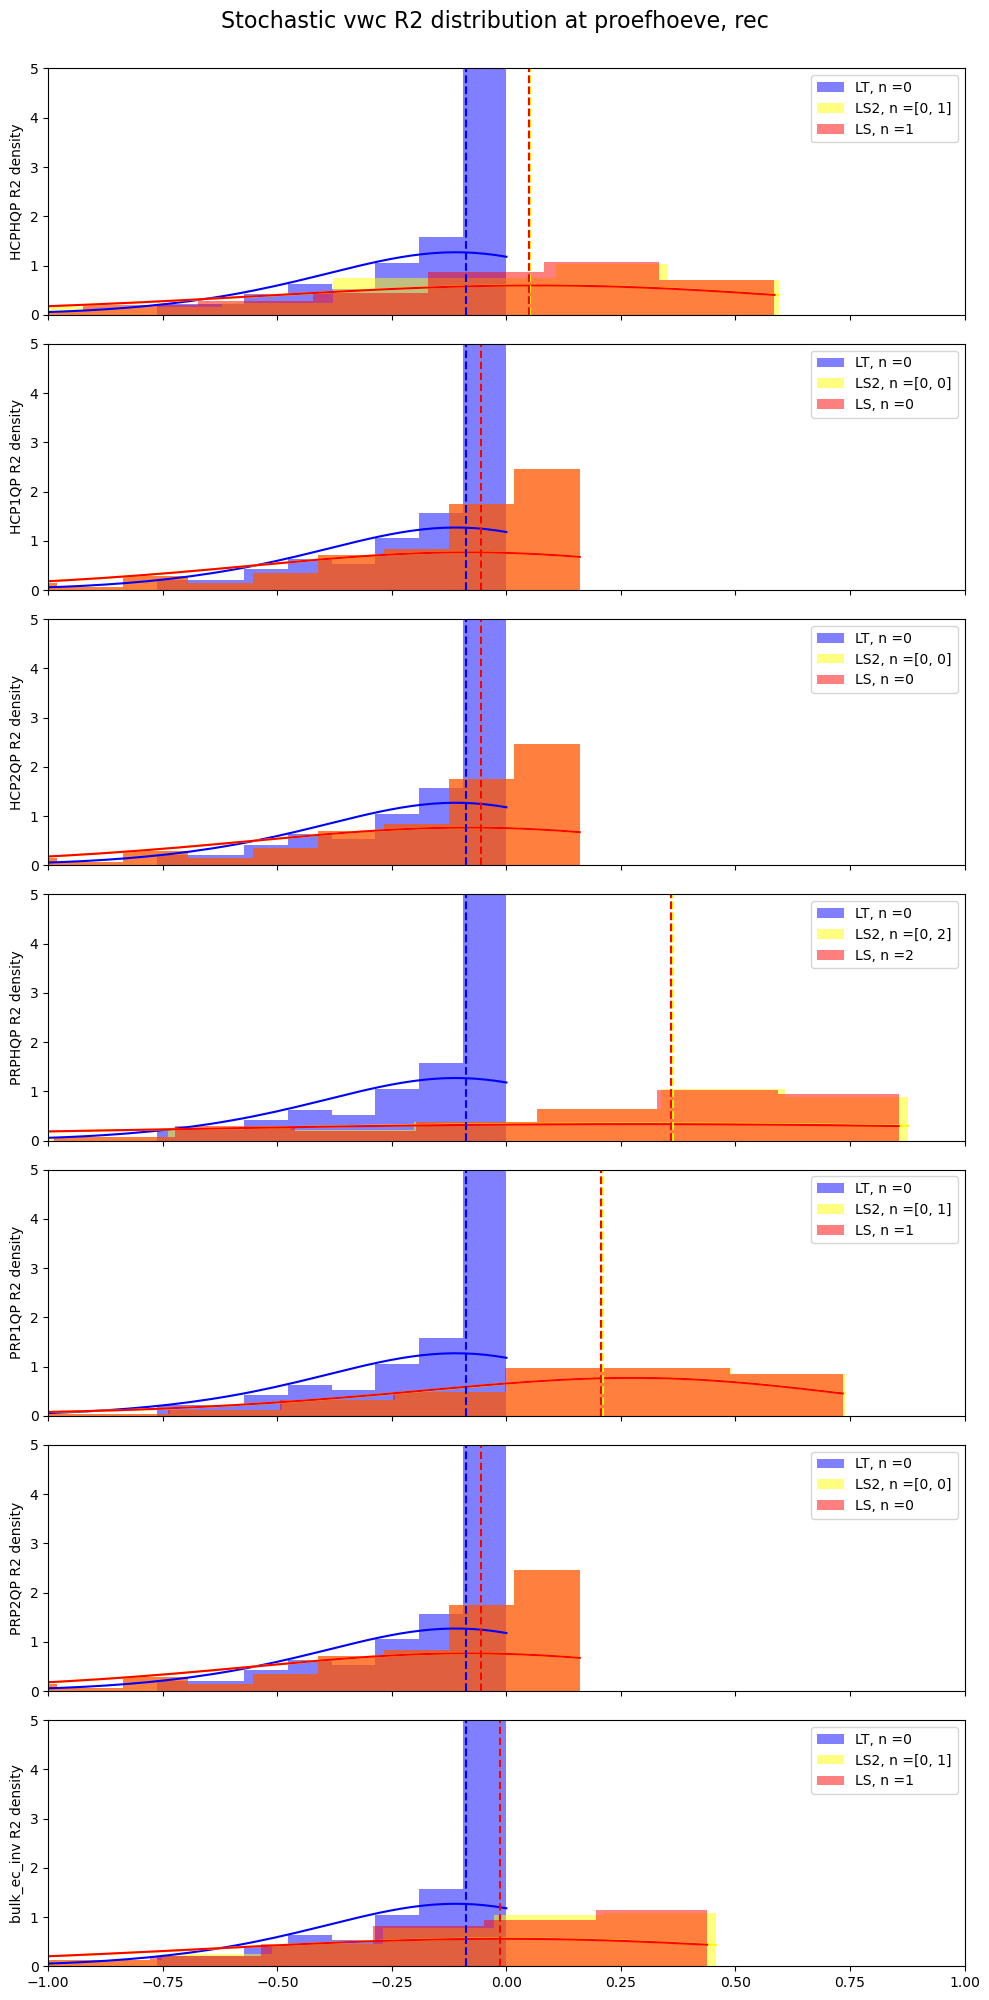

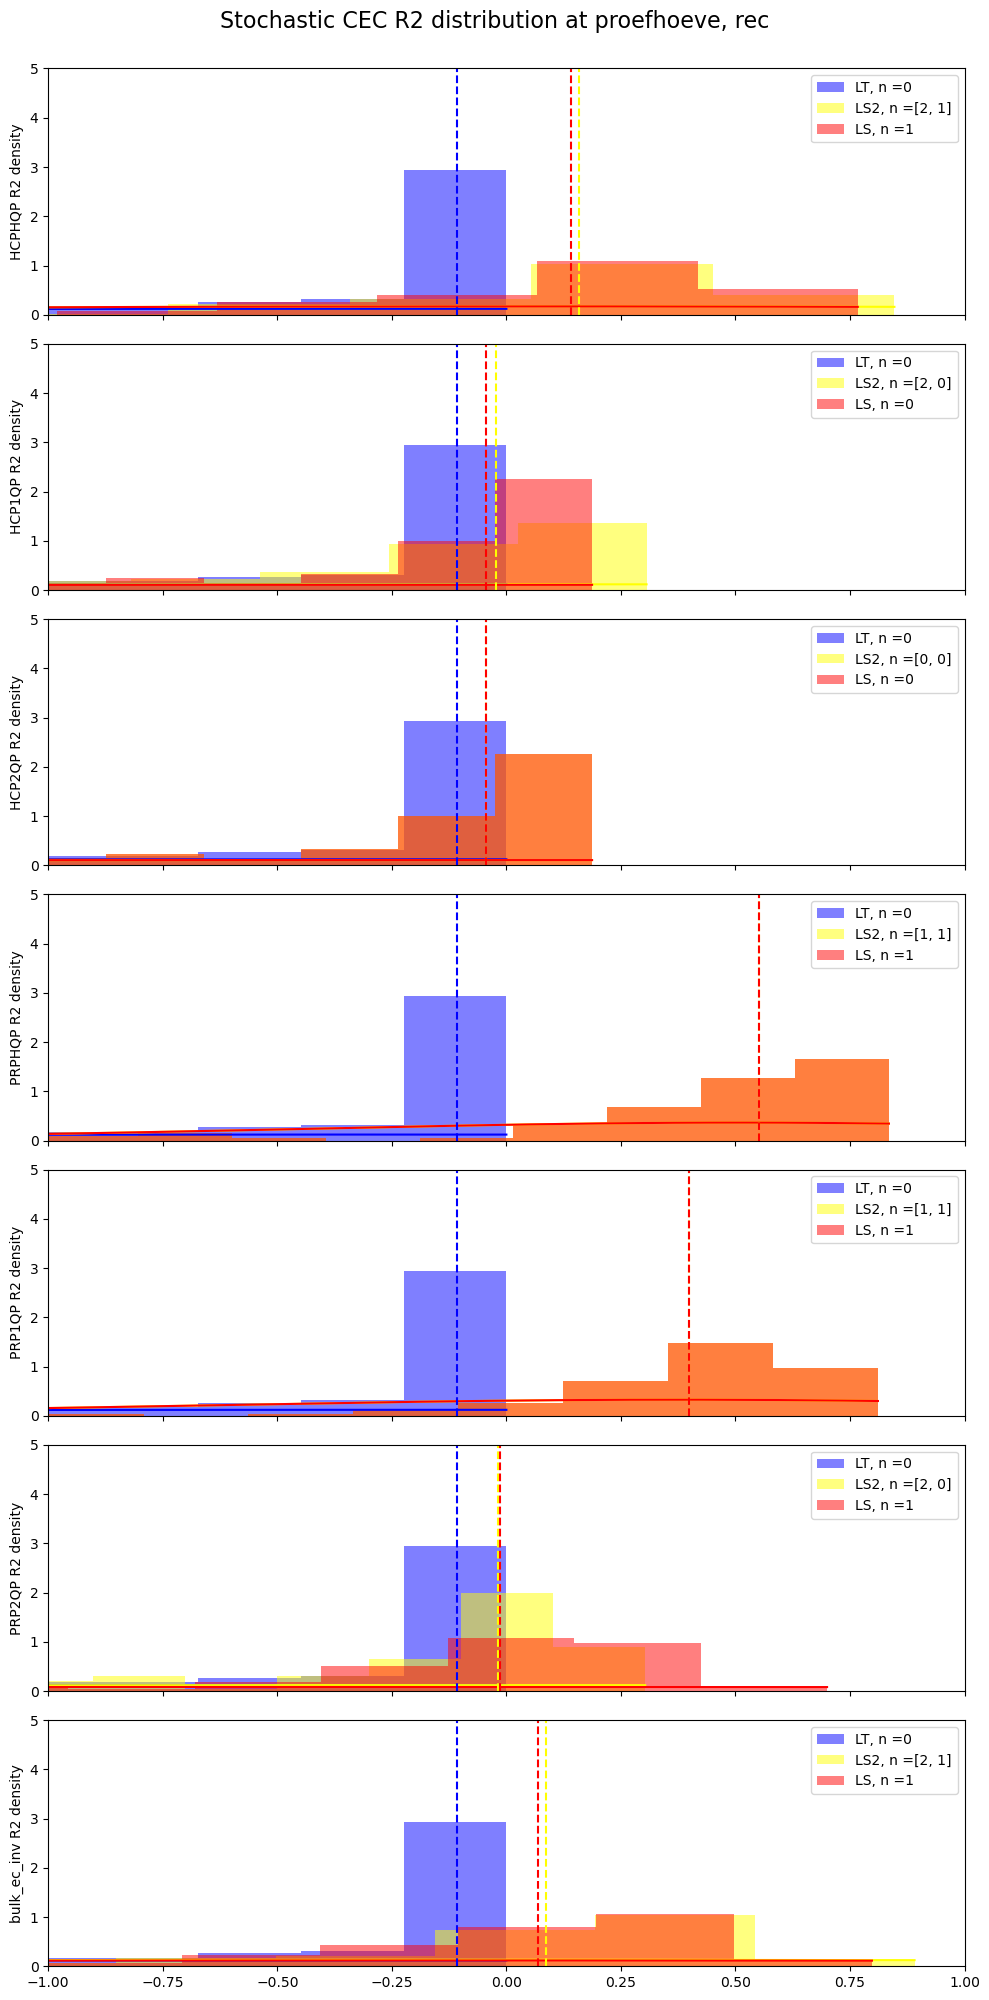

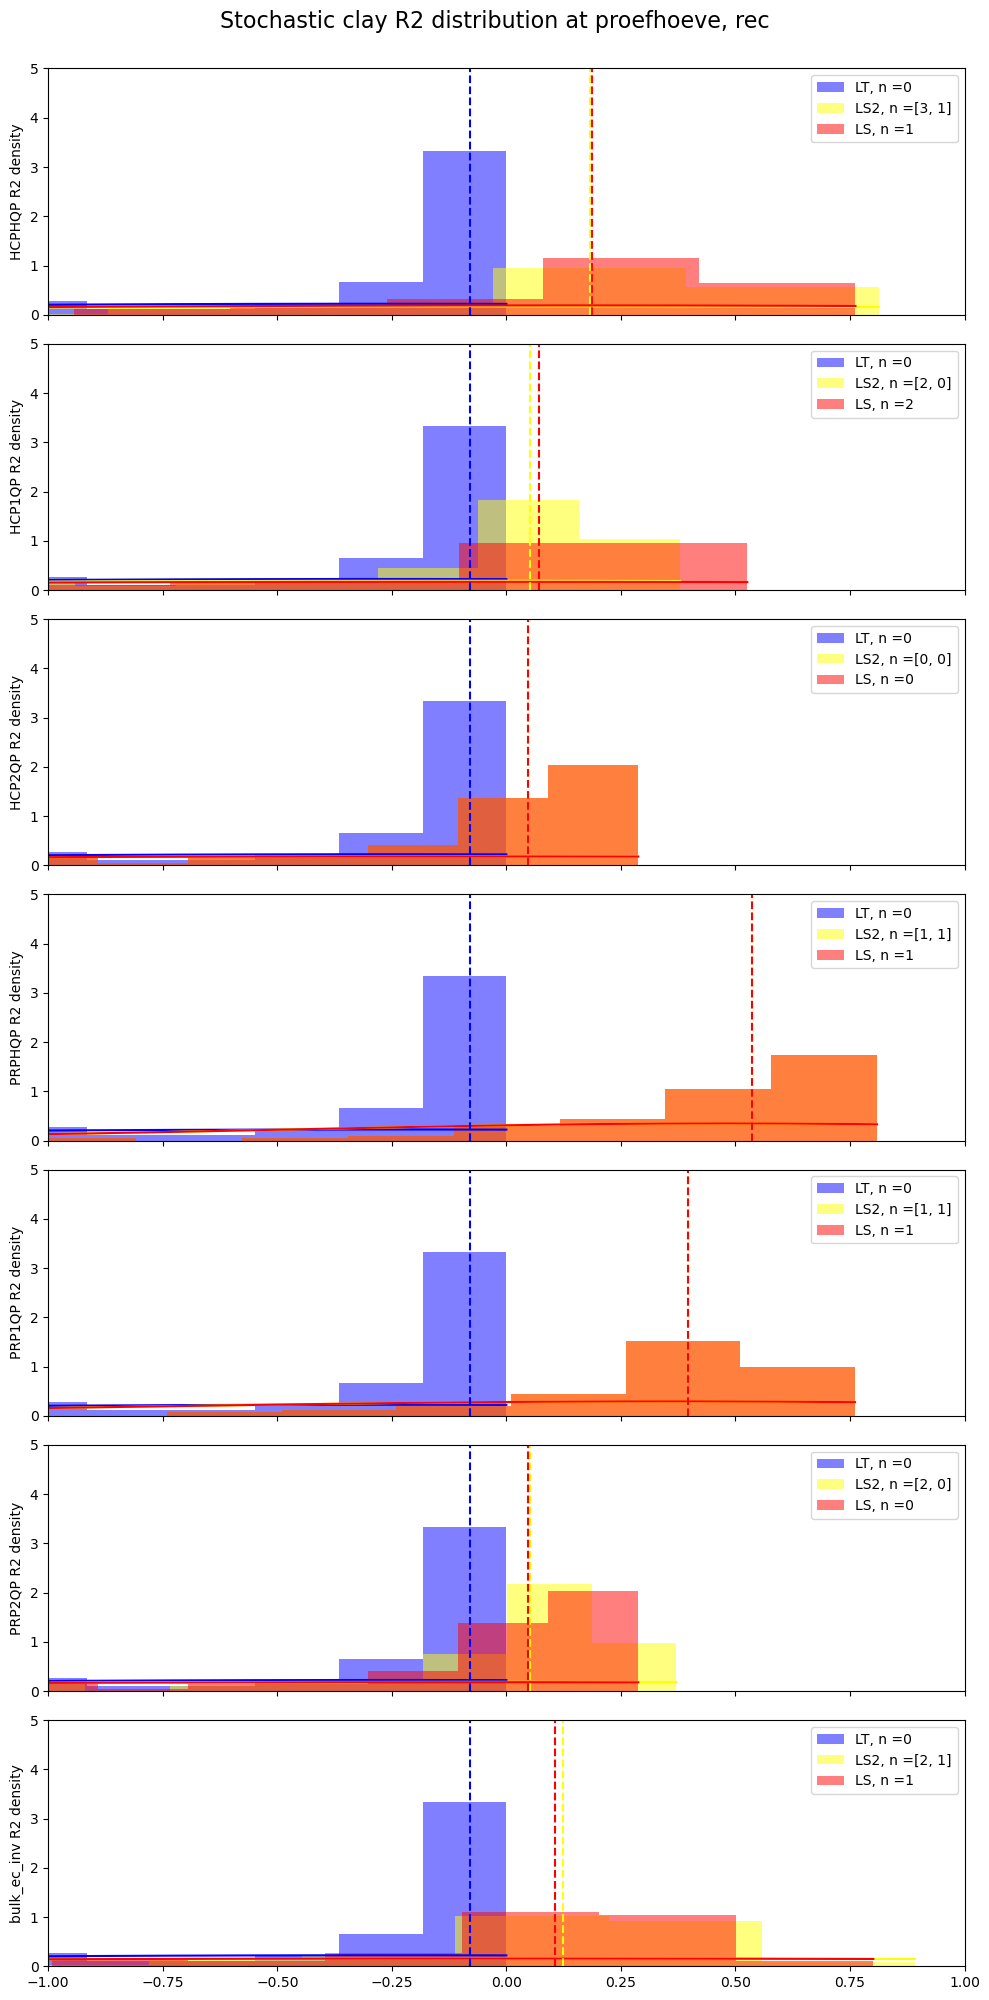

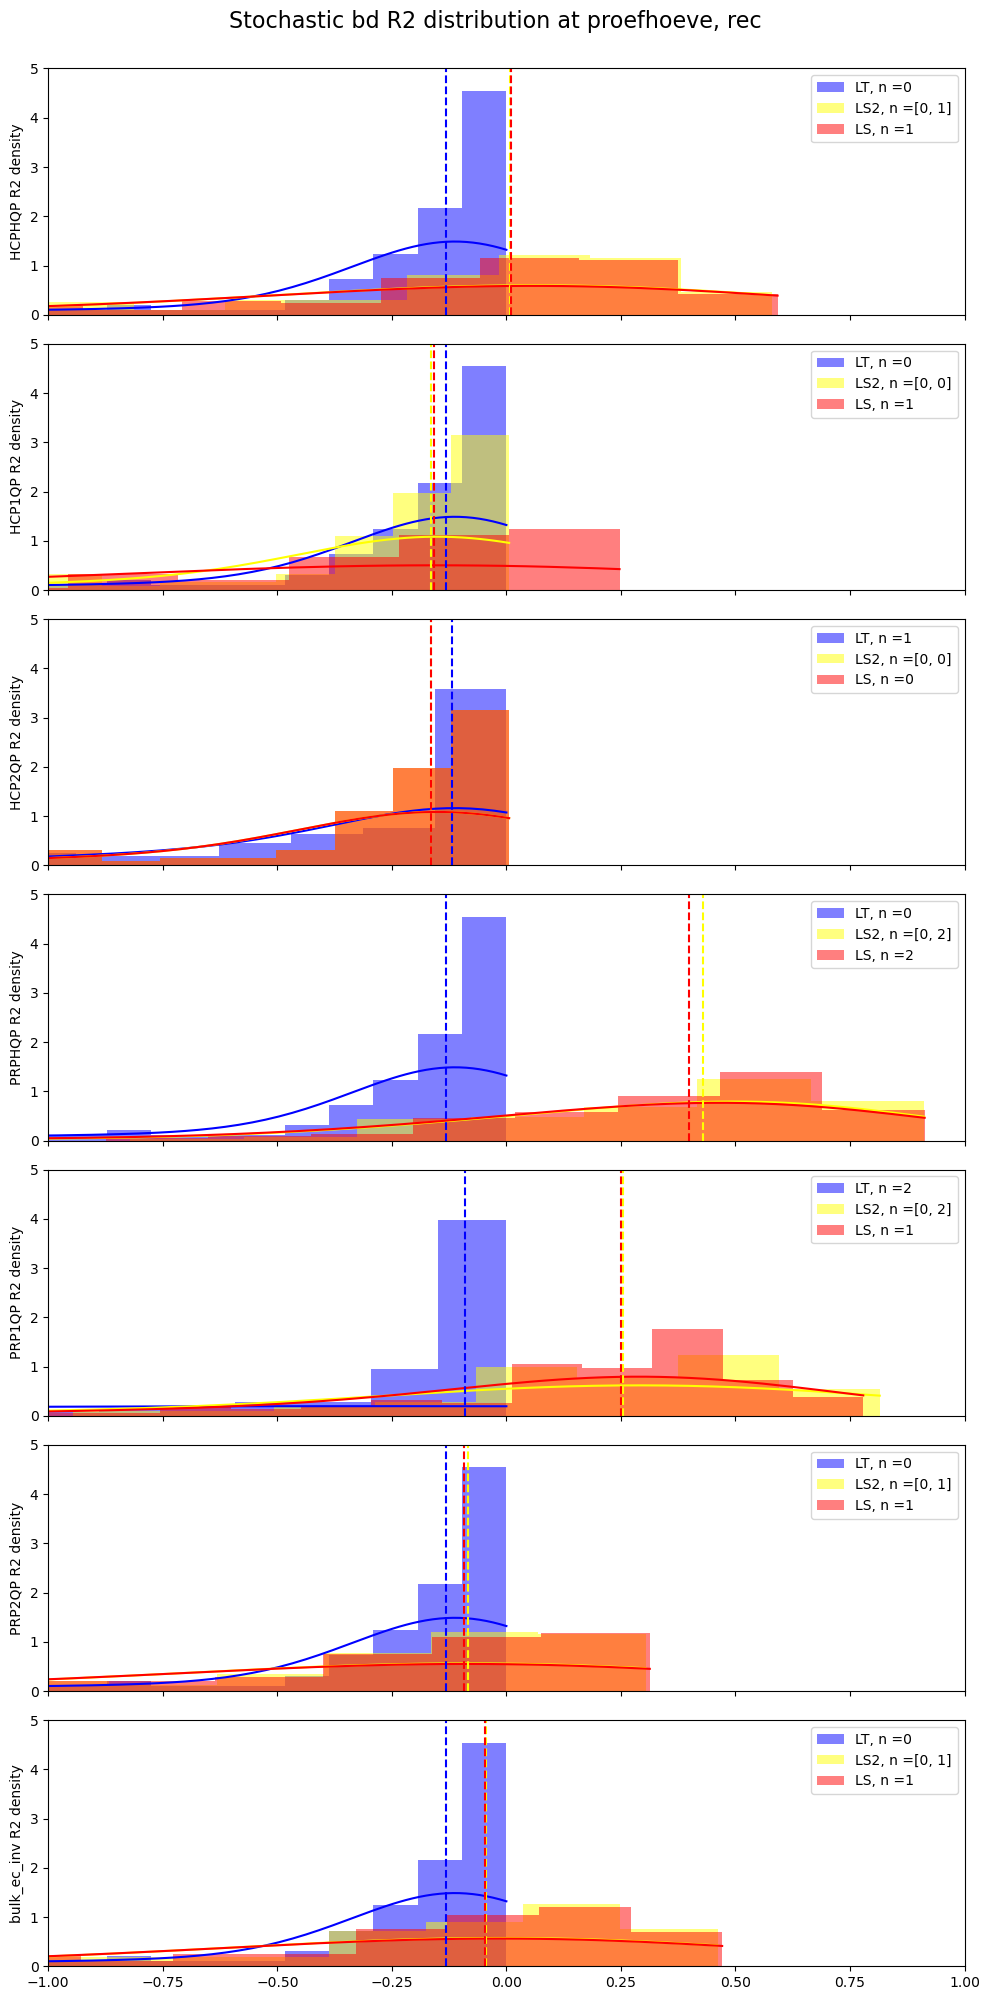

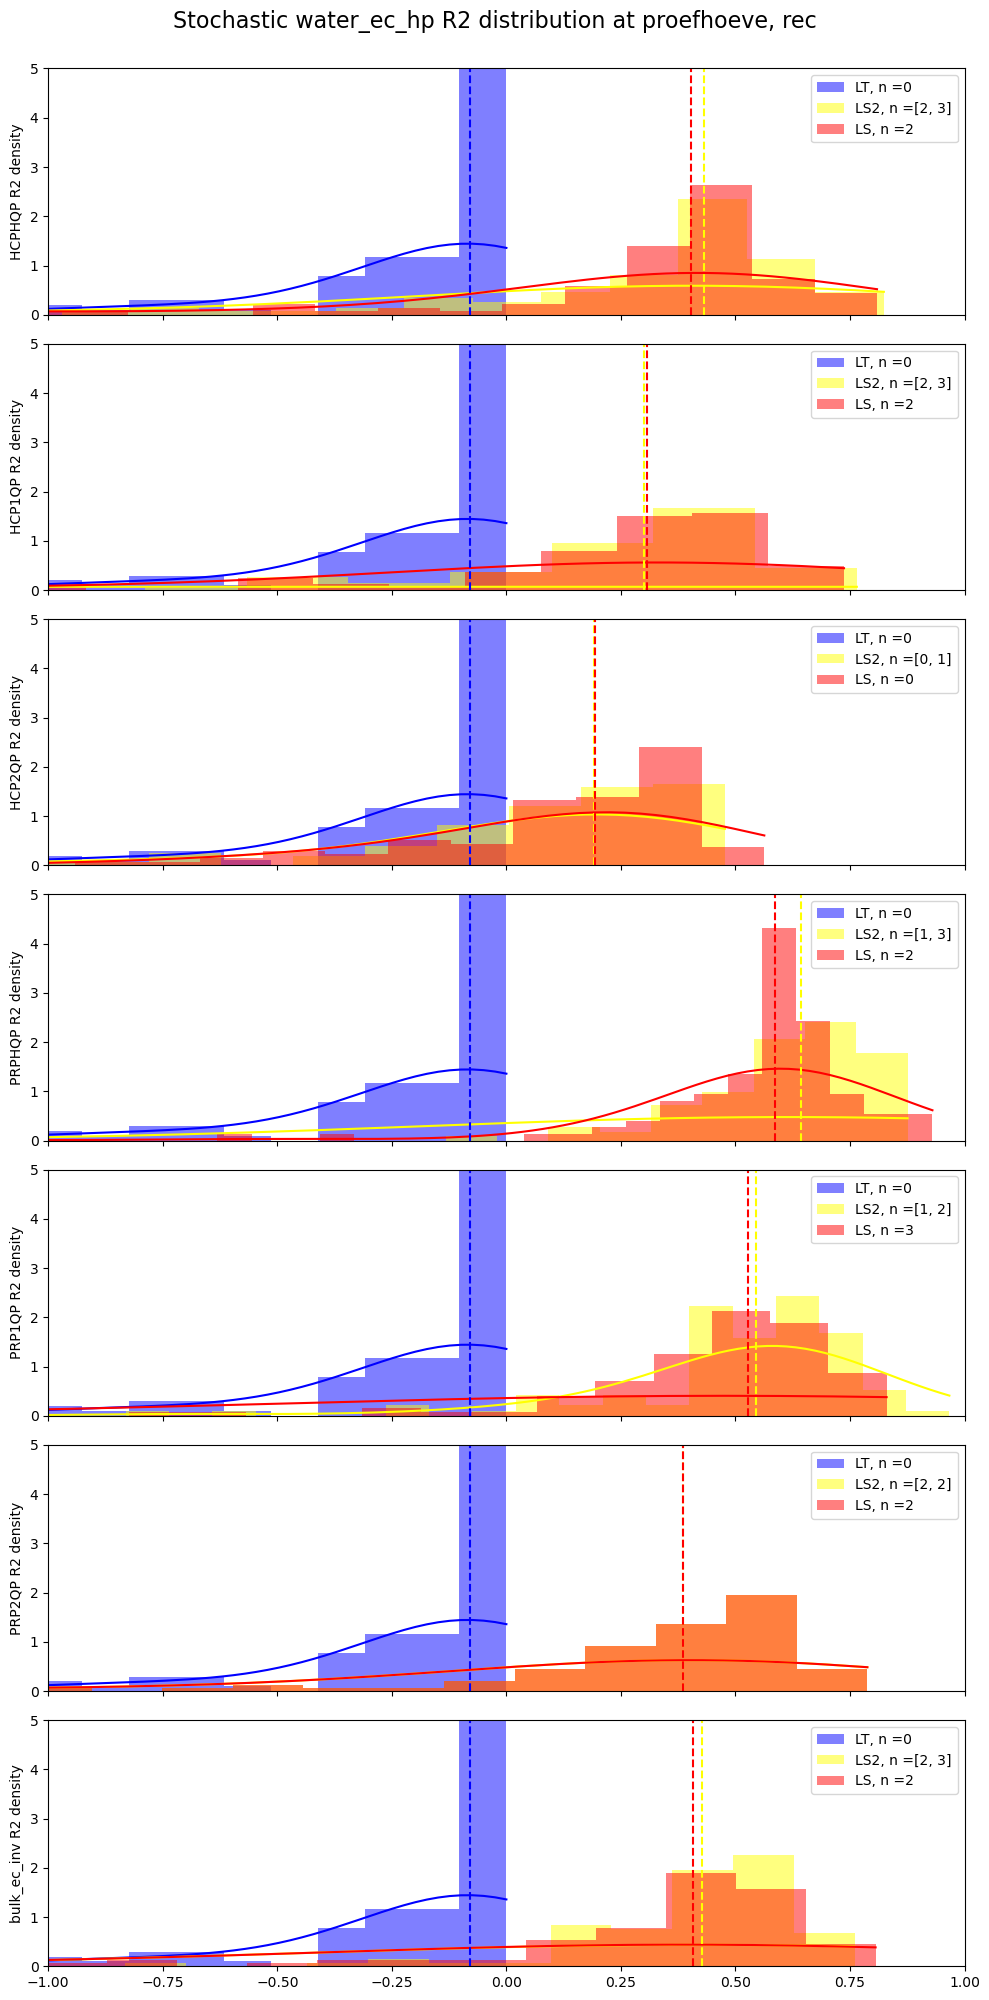

In [25]:
###########################
#### Store results ########
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp'
]

pdfs = []
Sresults = {}
SR2_results = pd.DataFrame(columns=['Target', 'Best Feature LT', 'R2 LT', 'Best Feature LS', 'R2 LS', 'Best Feature LS2', 'R2 LS2'
                               , 'Best Feature 10', 'R2 10', 'Best Feature 50', 'R2 50'])

for i, target in enumerate(target_set):
    max_r2_lt = -float('inf')
    max_r2_ls = -float('inf')
    max_r2_ls2 = -float('inf')
    max_r2_10 = -float('inf')
    max_r2_50 = -float('inf')
    best_feature_lt = None
    best_feature_ls = None
    best_feature_ls2 = None

    for feature in feature_set:
        SR2_test_LT, SR2_test_LS, SR2_test_LS2, SR2_test_10, SR2_test_50, best_ns = stochastic(feature, target, ds_c)

        Sresults[feature] = {
            'LT': {'R2': SR2_test_LT, 'n': best_ns[0]},
            'LS': {'R2': SR2_test_LS, 'n': best_ns[1]},
            'LS2': {'R2': SR2_test_LS2, 'n': best_ns[2]},
            '10': {'R2': SR2_test_10, 'n': best_ns[2]},
            '50': {'R2': SR2_test_50, 'n': best_ns[2]}
        }

    for feature, result in Sresults.items():
        if np.median(result['LT']['R2']) > max_r2_lt:
            max_r2_lt = np.median(result['LT']['R2'])
            best_feature_lt = feature

        if np.median(result['LS']['R2']) > max_r2_ls:
            max_r2_ls = np.median(result['LS']['R2'])
            best_feature_ls = feature

        if np.median(result['LS2']['R2']) > max_r2_ls2:
            max_r2_ls2 = np.median(result['LS2']['R2'])
            best_feature_ls2 = feature

        if np.median(result['10']['R2']) > max_r2_10:
            max_r2_10 = np.median(result['10']['R2'])
            best_feature_10 = feature

        if np.median(result['50']['R2']) > max_r2_50:
            max_r2_50 = np.median(result['50']['R2'])
            best_feature_50 = feature

    SR2_results.loc[i, 'Target'] = target
    SR2_results.loc[i, 'Best Feature LT'] = best_feature_lt
    SR2_results.loc[i, 'R2 LT'] = max_r2_lt
    SR2_results.loc[i, 'Best Feature LS'] = best_feature_ls
    SR2_results.loc[i, 'R2 LS'] = max_r2_ls
    SR2_results.loc[i, 'Best Feature LS2'] = best_feature_ls2
    SR2_results.loc[i, 'R2 LS2'] = max_r2_ls2
    SR2_results.loc[i, 'Best Feature 10'] = best_feature_10
    SR2_results.loc[i, 'R2 10'] = max_r2_10
    SR2_results.loc[i, 'Best Feature 50'] = best_feature_50
    SR2_results.loc[i, 'R2 50'] = max_r2_50

    file_name = plot_stoch(Sresults, feature_set, target, profile_prefix, em_intype, cal, s_site, 'R2', 'blue', 'red', 'yellow')
    pdfs.append(file_name)

In [26]:
folder_path = 'output_images/'

# Merge and save PDFs
merger = PdfMerger()
for pdf in pdfs:
    merger.append(folder_path + pdf)
merged_pdf_filename = f"R2_stoch_{s_site}_{cal}_{em_intype}.pdf"
outfile_transect_pdf = os.path.join(folder_path, merged_pdf_filename)
merger.write(outfile_transect_pdf)
merger.close()
for pdf in pdfs:
    os.remove(folder_path + pdf)
clear_output(wait=False)

In [27]:
folder_path = 'output_tables/'
file_name = 'SR2_results'+'_'+s_site+'_'+em_intype+'_'+cal+'_'+instrument_code+'.xlsx'
SR2_results.to_excel(folder_path + file_name, index=False)

SR2_results

Target Best Feature LT   R2 LT Best Feature LS   R2 LS  \
0          vwc          HCPHQP  -0.088          PRPHQP  0.3595   
1          CEC          HCPHQP -0.1075          PRPHQP  0.5525   
2         clay          HCPHQP   -0.08          PRPHQP  0.5365   
3           bd          PRP1QP -0.0895          PRPHQP  0.3995   
4  water_ec_hp          HCPHQP   -0.08          PRPHQP   0.587   

  Best Feature LS2  R2 LS2 Best Feature 10   R2 10 Best Feature 50   R2 50  
0           PRPHQP   0.364          HCPHQP -0.2645          PRPHQP   0.268  
1           PRPHQP  0.5525          PRPHQP  0.4055          PRPHQP   0.494  
2           PRPHQP  0.5365          PRPHQP  0.3115          PRPHQP   0.405  
3           PRPHQP  0.4285          HCPHQP  -0.205          PRPHQP   0.434  
4           PRPHQP  0.6425          PRPHQP  0.5025          PRPHQP  0.3845

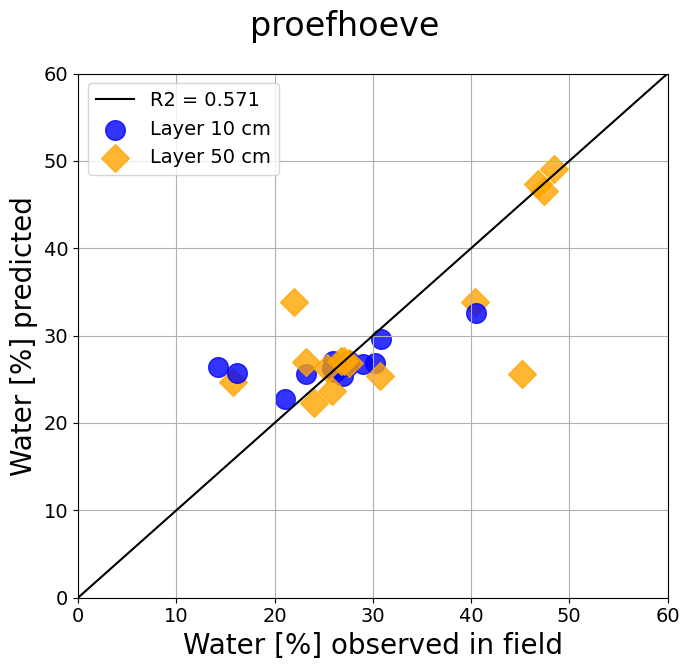

In [28]:
round_n = 3
target = 'vwc'

feature_10 = SR2_results[SR2_results['Target'] == 'vwc']['Best Feature 10'].iloc[0]
feature_50 = SR2_results[SR2_results['Target'] == 'vwc']['Best Feature 50'].iloc[0]

n_10 = Sresults[feature_10]['LS2']['n'][0]
n_50 = Sresults[feature_50]['LS2']['n'][1]

### Extract indices for 10 cm and 50 cm layers
idx_10 = ds_c[ds_c['depth'] == 10].index
idx_50 = ds_c[ds_c['depth'] == 50].index

### Select data at 10 cm depth
X_10 = ds_c.loc[idx_10, feature_10].values.reshape(-1, 1)
Y_10 = ds_c.loc[idx_10, target].values
### Select data at 50 cm depth
X_50 = ds_c.loc[idx_50, feature_50].values.reshape(-1, 1)
Y_50 = ds_c.loc[idx_50, target].values

#### Stochastic modelling for layers together
polySP_10 = PolynomialFeatures(degree=n_10)
polySP_10.fit(X_10)

Xt_10 = polySP_10.transform(X_10)
#Yt_10 = polySP_10.transform(Y_10)

LinRegSP = LinearRegression()
LinRegSP.fit(Xt_10, Y_10)
Ypred_10 = LinRegSP.predict(Xt_10)

#### Stochastic modelling for layers together
polySP_50 = PolynomialFeatures(degree=n_50)
polySP_50.fit(X_50)

Xt_50 = polySP_50.transform(X_50)

LinRegSP = LinearRegression()
LinRegSP.fit(Xt_50, Y_50)
Ypred_50 = LinRegSP.predict(Xt_50)

Y = np.concatenate((Y_10, Y_50))
Y_pred = np.concatenate((Ypred_10, Ypred_50))

r2 = round(r2_score(Y, Y_pred), round_n)

plot_stoch_implementation(ds_c, Y, Y_pred, r2, profile_prefix)

In [29]:
data = Y - Y_pred
std_dev = np.std(data)

# Specify the percentiles you're interested in
percentiles = [50, 90]

# Calculate the values at these percentiles
percentile_values = np.percentile(data, percentiles)

# If you want to see how spread out the data is at these percentiles, you can calculate the standard deviation of these percentile values
std_dev_of_percentiles = np.std(percentile_values)

print(f"Standard Deviation of the array: {std_dev}")
print(f"Values at {percentiles} percentiles: {percentile_values}")
print(f"Standard Deviation of the percentile values: {std_dev_of_percentiles}")

Standard Deviation of the array: 0.05869167244581111
Values at [50, 90] percentiles: [0.00129749 0.05464005]
Standard Deviation of the percentile values: 0.026671281692115235
